# Making and Testing Dips 

In this notebook, we're going to simulate some dips

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("whitegrid")

import numpy as np
import pandas as pd
import datetime

import lightkurve as lk
from dipper import measure_dip


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Kyle has a basic function in his notebook that I think we can extend:

In [2]:
def dip(time, depth, tdip, width, mean_flux=1):
    """
    Function to generate the flux for a dip and surrounding
    flat light curve, given a set of time stamps.

    Parameters
    ----------
    depth : float, or iterable
        A value or list of values for the depth(s) of the dip(s)

    tdip : float, or iterable
        A value or list of values for the location(s) of the dip(s)

    width : float, or iterable
        A value or list of values for the width(s) of the dip(s)

    mean_flux : float, default 1
        The constant flux of the star

    Returns
    -------
    flux : numpy.ndarray
        An array of flux values corresponding to the time stamps
        in `time`

    """
    time = np.array(time)

    # make flux
    if np.size(depth) > 1:
        flux = mean_flux
        for i in range(len(depth)):
            flux -= depth[i] * np.exp(-(time-tdip[i])**2 / (2 * width[i]**2))
    else:
        flux = mean_flux - depth * np.exp(-(time-tdip)**2 / (2 * width**2))

    return flux

In [3]:
def simulate_dip_flux(tseg=851, coverage=3.0, width=5, depth=0.2, tdip="random"):
    """
    Simulate normalized flux for one or multiple dips on an evenly sampled 
    grid.
    
    Parameters
    ----------
    tseg : float
        The duration of the total light curve in days
    
    coverage : float
        The number of data points per day in the finely 
        sampled light curve.
        
    width : float, or iterable
        The width of the dip in days
        
    depth : float [0,1], or iterable
        The depth of the dip, as a fraction of the flux normalized to 1. 
        Must be between 0 and 1
    
    tdip : float or None or "random"
        If no dip position is given in the time unit of the light curve, 
        either the dip is put in the middle (or equally spaced for multiple dips), if None, 
        or the position is randomized across the light curve (for "random") 
        
        
    Returns
    -------
    time : numpy.ndarray
        An array with time stamps for the flux measurements
        
    flux : numpy.ndarray
        An array with the flux measurements
    
    """
    # if my width and depth are numbers, I want to turn them 
    # into arrays so I can loop over them and won't need to 
    # treat that case separately later
    if np.size(width) == 1:
        width = np.array([width])
    if np.size(depth) == 1:
        depth = np.array([depth])

    # if tdip is None, then randomly scatter dip into the 
    # light curve, otherwise make sure it's an array
    if tdip is not None and tdip != "random":
        if np.size(tdip) == 1:
            tdip = np.array([tdip])
    elif tdip == "random":
        w = np.max(width) * 5.0
        tdip = np.random.uniform(0+w, tseg-w, size=len(width))
    else:
        if np.size(width) == 1:
            tdip = np.array([tseg/2.0])
        # if there's more than one dip, scatter through light curve
        # at regular intervals
        else:
            w = np.max(width) * 5.0
            tdip = np.linspace(w, tseg-w, len(width))
            
    # check that inputs are correct
    if np.any(width >= tseg):
        raise ValueError("The dip must be smaller than the length of the light curve.")

    # check that the depth is smaller than 1, or we'll have negative flux
    if np.any(depth >= 1.0):
        raise ValueError("The depth of the dip must be < 1.")

    # the number of points is the days times the coverage:
    npoints = int(tseg * coverage)

    # create evenly sampled time array
    time = np.linspace(0.0, tseg, npoints)

    # calculate_flux
    flux = dip(time, depth, tdip, width, mean_flux=1)

    return time, flux

Let's simulate a light curve and see what it looks like.

We need the total duration of the ZTF survey:

In [4]:
# ZTF First Light
ztf_start = datetime.date(2017, 11, 1)

# Pick a recent date
today = datetime.date(2020, 3, 1)

# difference in days
tseg = today - ztf_start
tseg = tseg.days

In [5]:
coverage = 5
width = 5.0
depth = 0.2

np.random.seed(400)

time, flux = simulate_dip_flux(tseg, coverage, width, depth)

<IPython.core.display.Javascript object>


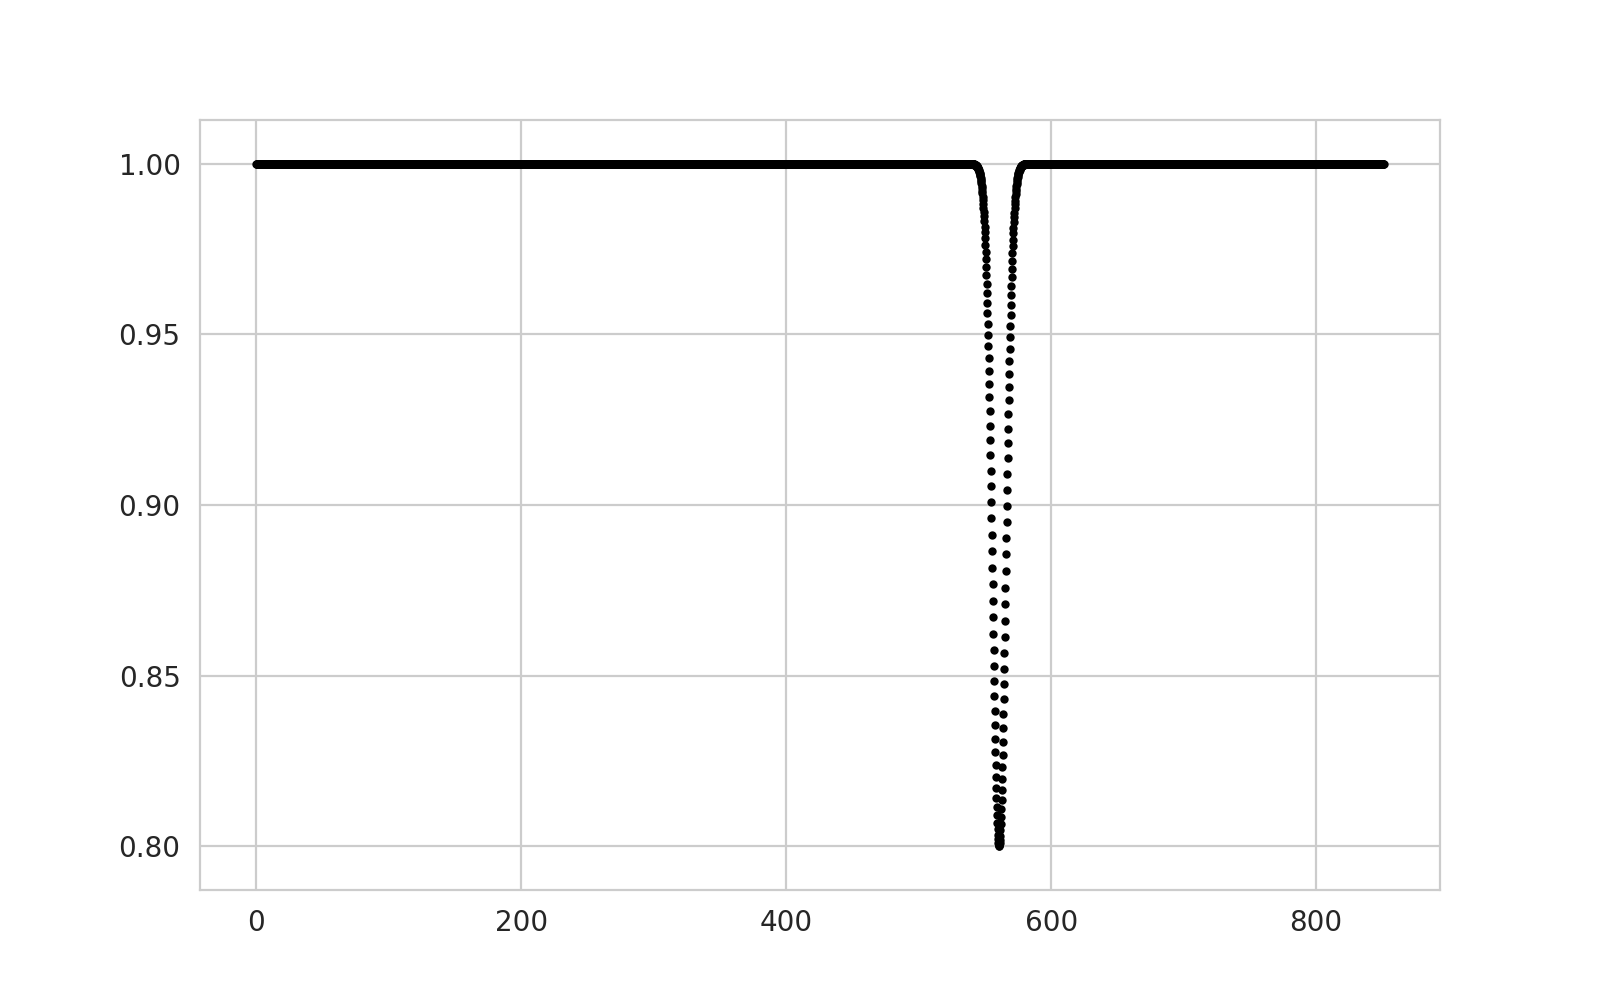

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.scatter(time, flux, color="black", s=4)


Okay, cool, now we want to generate light curves:

In [10]:
def simulate_lightcurves_from_fluxes(time, flux, nbands=1, cadence=None, npoints=None,
                         err=0.02, mean_mag=12.0):

    if cadence is None and npoints is None:
        raise ValueError("Either cadence or npoints need to have a value.")
    if cadence is not None:
        if cadence.shape[0] != nbands:
            raise ValueError("Need to have a set of cadences for all bands defined in `nbands`")
    if npoints is not None:
        if np.size(npoints) != nbands:
            raise ValueError("Need to have a set of `npoints` for all bands defined in `nbands`")
    if np.size(err) != 1 and len(err) != nbands:
        raise ValueError("The errors need to be either a single number or a list" + \
                         "of numbers corresponding to the number of bands.")
    if np.size(mean_mag) == 1:
        mean_mag = np.array([mean_mag])
    if np.size(err) == 1:
        err = np.array([err])
    if np.size(npoints) == 1:
        npoints = np.array([npoints])
    if cadence is not None:
        npoints = np.array([len(c) for c in cadence])

    lc_all = []
    # loop over different bands:
    for i in range(nbands):
        # if the cadence is not defined, randomly sample from times 
        if cadence is None:
            idx = np.sort(np.random.choice(np.arange(time.shape[0]), replace=False, size=npoints[i]))
        else:
            cad = cadence[i]
            idx = time.searchsorted(cad)

        new_time = time[idx]
        new_flux = flux[idx]

        mag = -2.5*np.log10(new_flux) + np.random.normal(mean_mag[i], err[i], size=npoints[i])

        magerr = np.ones_like(mag) * err[i]

        lc = lk.LightCurve(time=new_time,
                                   flux=mag,
                                   flux_err=magerr)
        lc_all.append(lc)

    return lc_all


In [11]:
def simulate_lightcurves_from_function(width, depth, tdip="random",  tseg=851, nbands=1, cadence=None, npoints=None,
                         err=0.02, mean_mag=12.0):

    if cadence is None and npoints is None:
        raise ValueError("Either cadence or npoints need to have a value.")
    
    if cadence is not None:
        if cadence.shape[0] != nbands:
            raise ValueError("Need to have a set of cadences for all bands defined in `nbands`")
    
    if npoints is not None:
        if np.size(npoints) != nbands:
            raise ValueError("Need to have a set of `npoints` for all bands defined in `nbands`")
    
    if np.size(err) != 1 and len(err) != nbands:
        raise ValueError("The errors need to be either a single number or a list" + \
                         "of numbers corresponding to the number of bands.")
    if np.size(mean_mag) == 1:
        mean_mag = np.array([mean_mag])
    
    if np.size(err) == 1:
        err = np.array([err])
    
    if np.size(npoints) == 1:
        npoints = np.array([npoints])
    
    if cadence is not None:
        npoints = np.array([len(c) for c in cadence])

    if np.size(width) == 1:
        width = np.array([width])
    if np.size(depth) == 1:
        depth = np.array([depth])

    # if tdip is None, then randomly scatter dip into the 
    # light curve, otherwise make sure it's an array
    if tdip is not None and tdip != "random":
        if np.size(tdip) == 1:
            tdip = np.array([tdip])
    elif tdip == "random":
        w = np.max(width) * 5.0
        tdip = np.random.uniform(0+w, tseg-w, size=len(width))
    else:
        if np.size(width) == 1:
            tdip = np.array([tseg/2.0])
        # if there's more than one dip, scatter through light curve
        # at regular intervals
        else:
            w = np.max(width) * 5.0
            tdip = np.linspace(w, tseg-w, len(width))

    # check that inputs are correct
    if np.any(width >= tseg):
        raise ValueError("The dip must be smaller than the length of the light curve.")

    # check that the depth is smaller than 1, or we'll have negative flux
    if np.any(depth >= 1.0):
        raise ValueError("The depth of the dip must be < 1.")

    lc_all = []
    # loop over different bands:
    for i in range(nbands):
        # if the cadence is not defined, randomly sample from times 
        if cadence is None:
            time = np.random.uniform(0, tseg, size=npoints[i])

        else:
            time = np.array(cadence[i])

        
        flux = dip(time, depth, tdip, width, mean_flux=1.0)

        mag = -2.5*np.log10(flux) + np.random.normal(mean_mag[i], err[i], size=npoints[i])

        magerr = np.ones_like(mag) * err[i]

        lc = lk.LightCurve(time=time,
                           flux=mag,
                                   flux_err=magerr)
        lc_all.append(lc)

    return lc_all


Now we can generate an actual light curve from a single band:

In [12]:
np.random.seed(200)
lc_all = simulate_lightcurves_from_fluxes(time, flux, nbands=1, npoints=[200], err=0.02, mean_mag=12.0 )

Let's do the same with the function that samples directly from the function:

In [13]:
lc_all = simulate_lightcurves_from_function(width, depth, tdip=tseg/2, tseg=851, nbands=1, npoints=[200], err=0.02, mean_mag=12.0 )

<IPython.core.display.Javascript object>


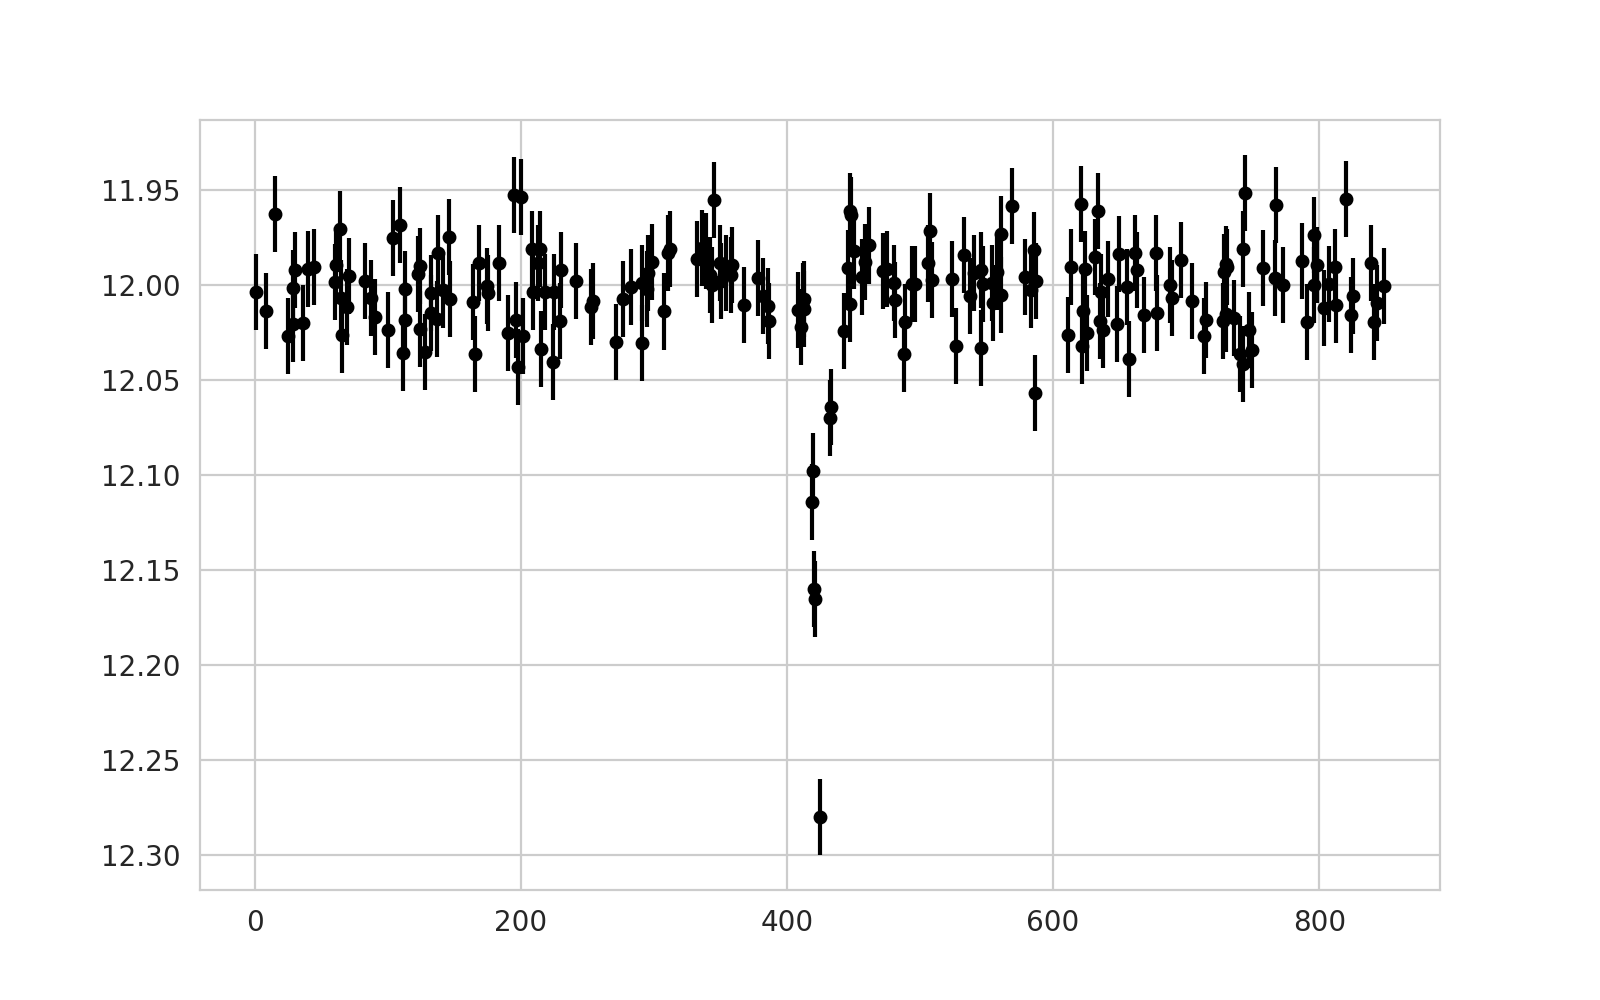

(12.31830459643757, 11.913164243808989)

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.errorbar(lc_all[0].time, lc_all[0].flux, yerr=lc_all[0].flux_err, fmt="o", color="black", markersize=4)
ax.set_ylim(ax.get_ylim()[::-1])

Ok, cool, let's simulate a bunch of these:

<IPython.core.display.Javascript object>


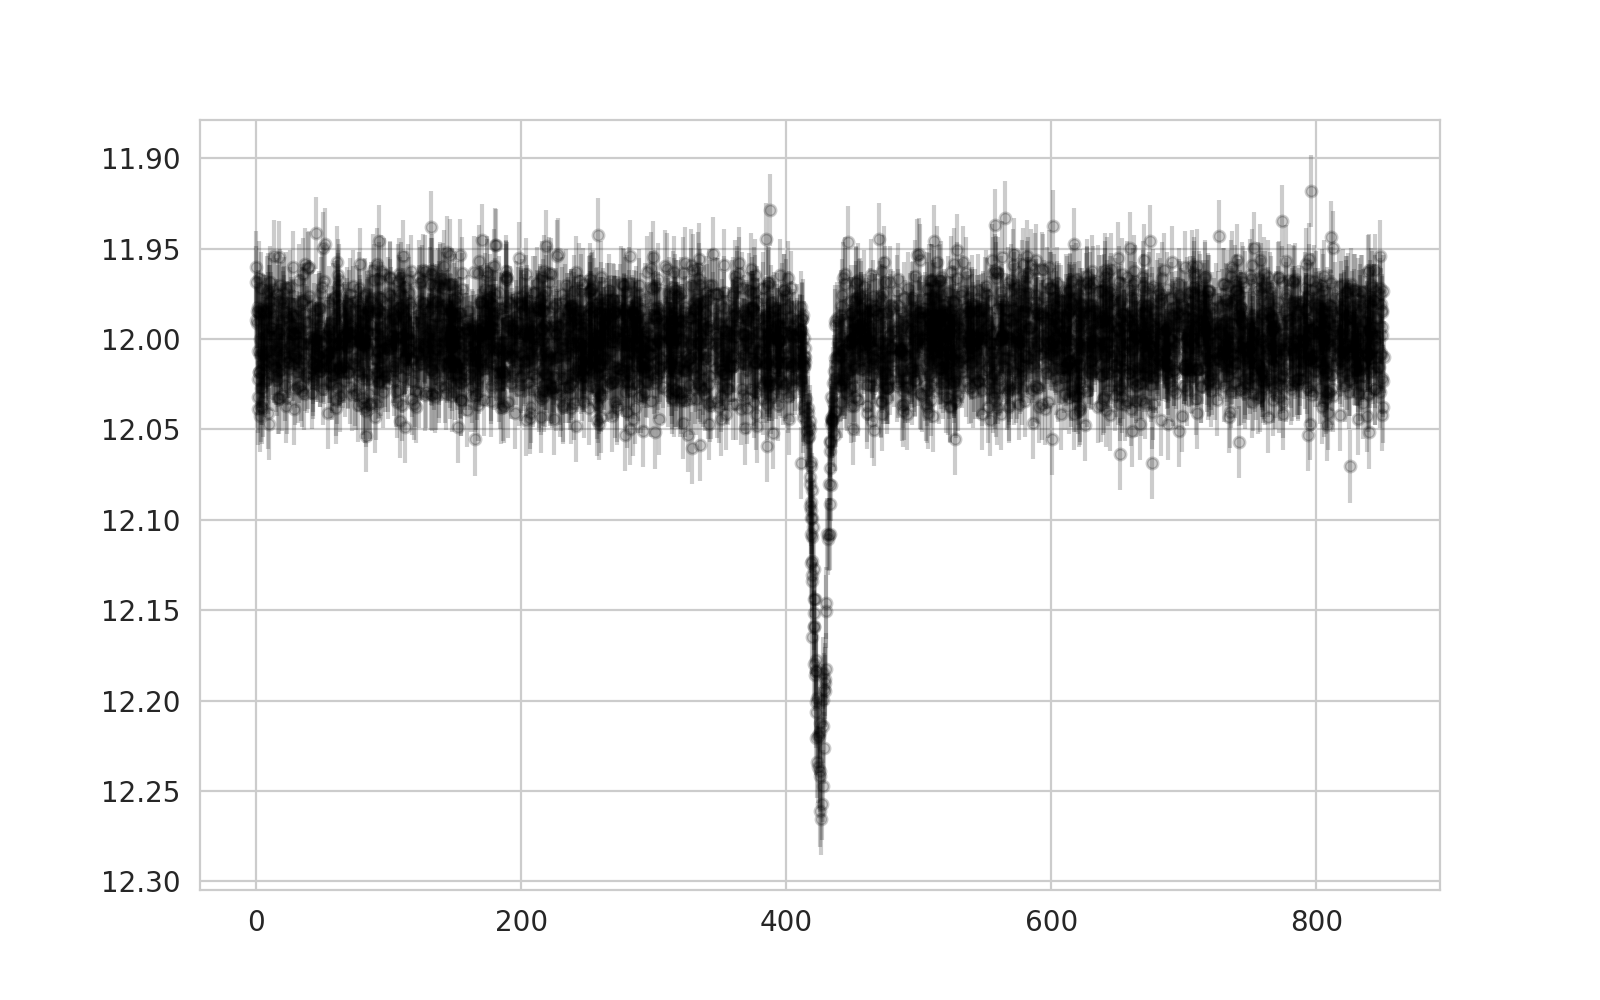

(12.304880800246064, 11.878706824017266)

In [15]:
nsims = 20

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for i in range(nsims):
    
    lc_all = simulate_lightcurves_from_function(width, depth, tdip=tseg/2, tseg=tseg, 
                                                nbands=1, npoints=[200], err=0.02, mean_mag=12.0 )
    ax.errorbar(lc_all[0].time, lc_all[0].flux, yerr=lc_all[0].flux_err, fmt="o", 
                color="black", markersize=4, alpha=0.2)

#ax.set_xlim(470, 530)
ax.set_ylim(ax.get_ylim()[::-1])

### Simulating multiple dips

Let's try simulating three dips, to figure out how that works:

In [16]:
coverage = 10
width = np.array([5.0, 10.0, 7.0])
depth = np.array([0.2, 0.5, 0.1])

In [17]:
np.random.seed(1000)
time, flux = simulate_dip_flux(tseg, coverage, width, depth)

<IPython.core.display.Javascript object>


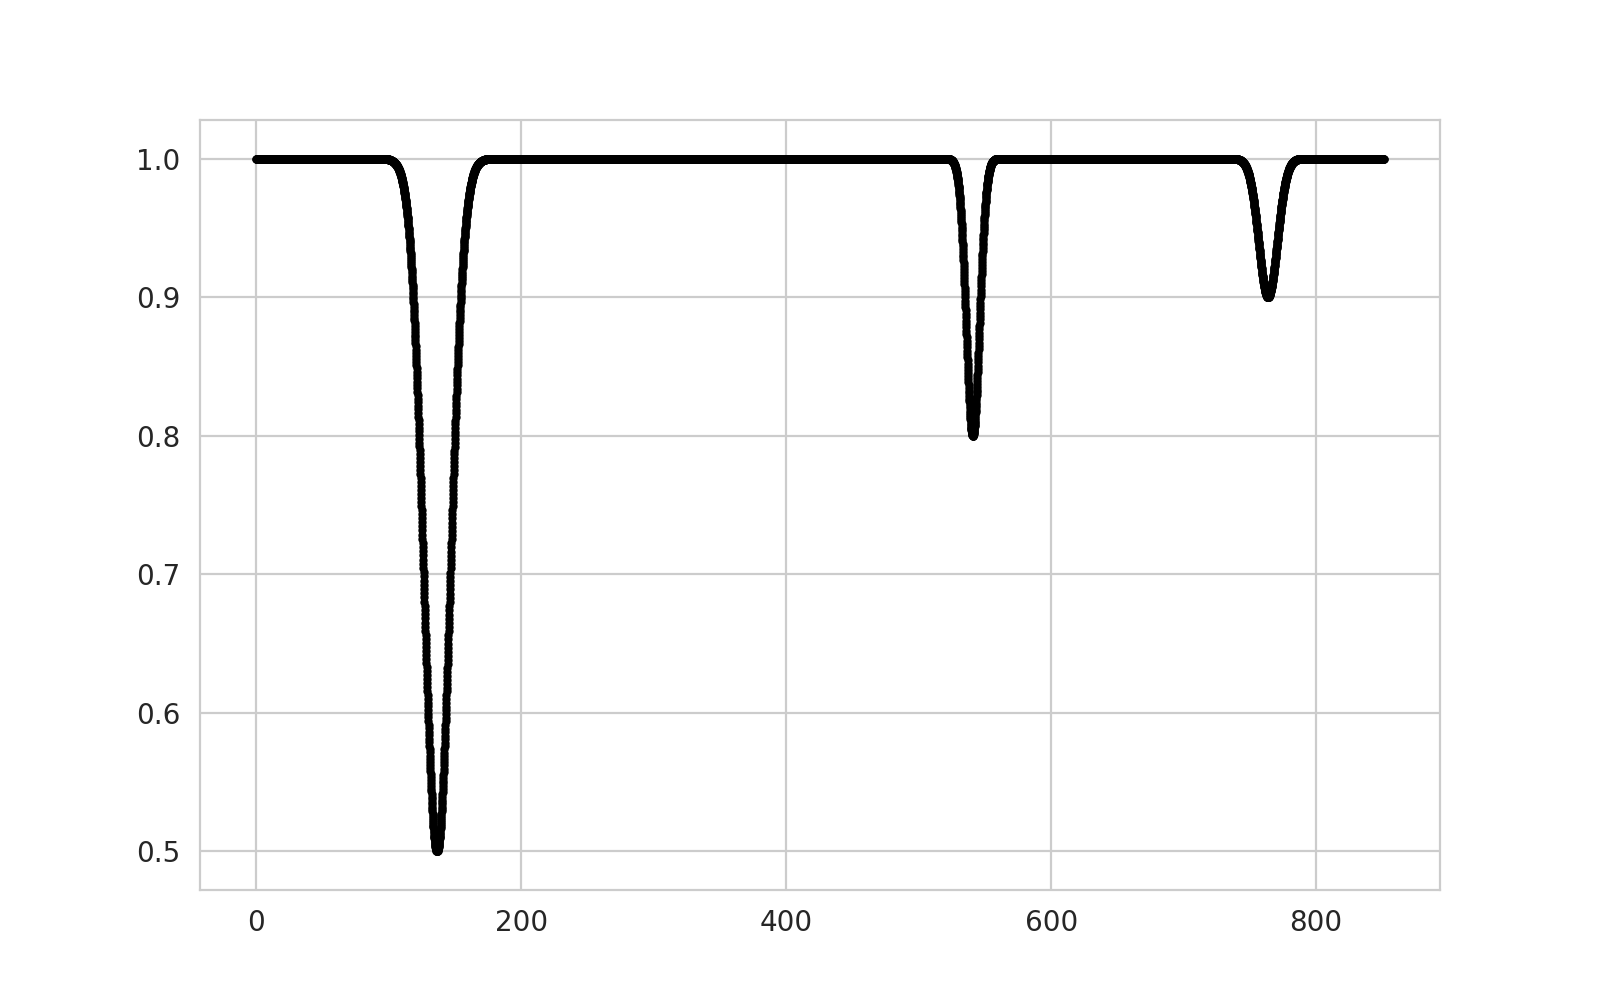

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.scatter(time, flux, color="black", s=4)

Ok, cool: let's make this into an actual light curve:

<IPython.core.display.Javascript object>


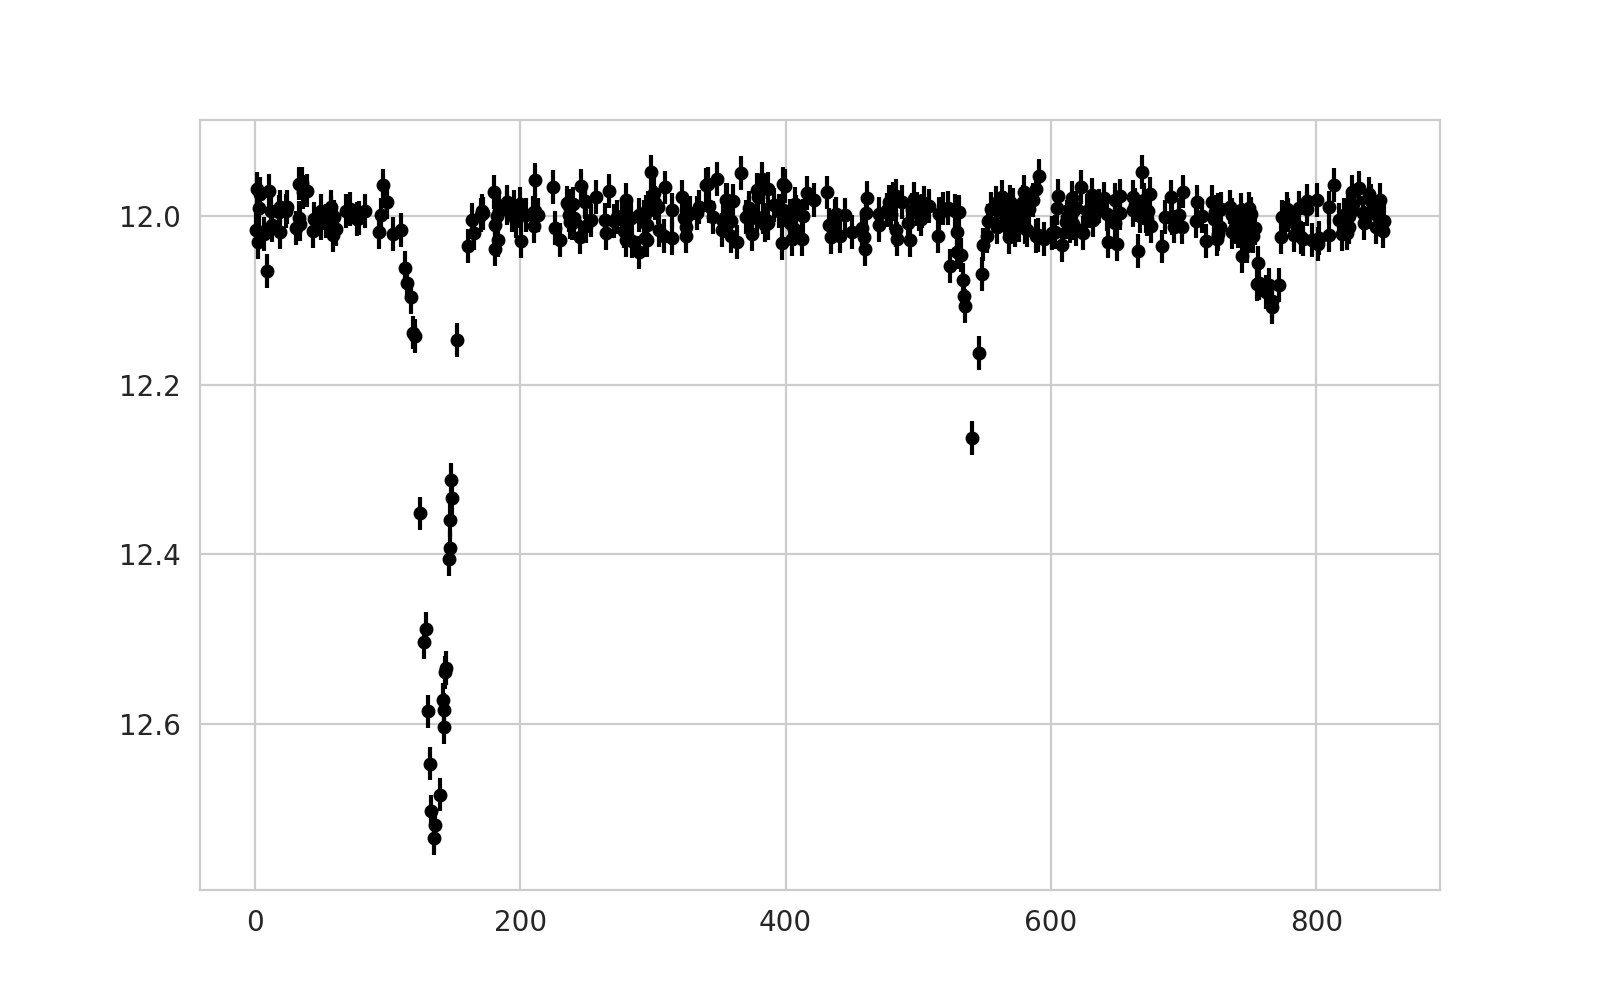

(12.796337538786094, 11.886751721660895)

In [19]:
np.random.seed(200)
lc_all = simulate_lightcurves_from_fluxes(time, flux, nbands=1, npoints=[400], err=0.02, mean_mag=12.0 )

fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.errorbar(lc_all[0].time, lc_all[0].flux, yerr=lc_all[0].flux_err, fmt="o", color="black", markersize=4)
ax.set_ylim(ax.get_ylim()[::-1])

Excellent, that works. Now we really want to generate multiple bands:

<IPython.core.display.Javascript object>


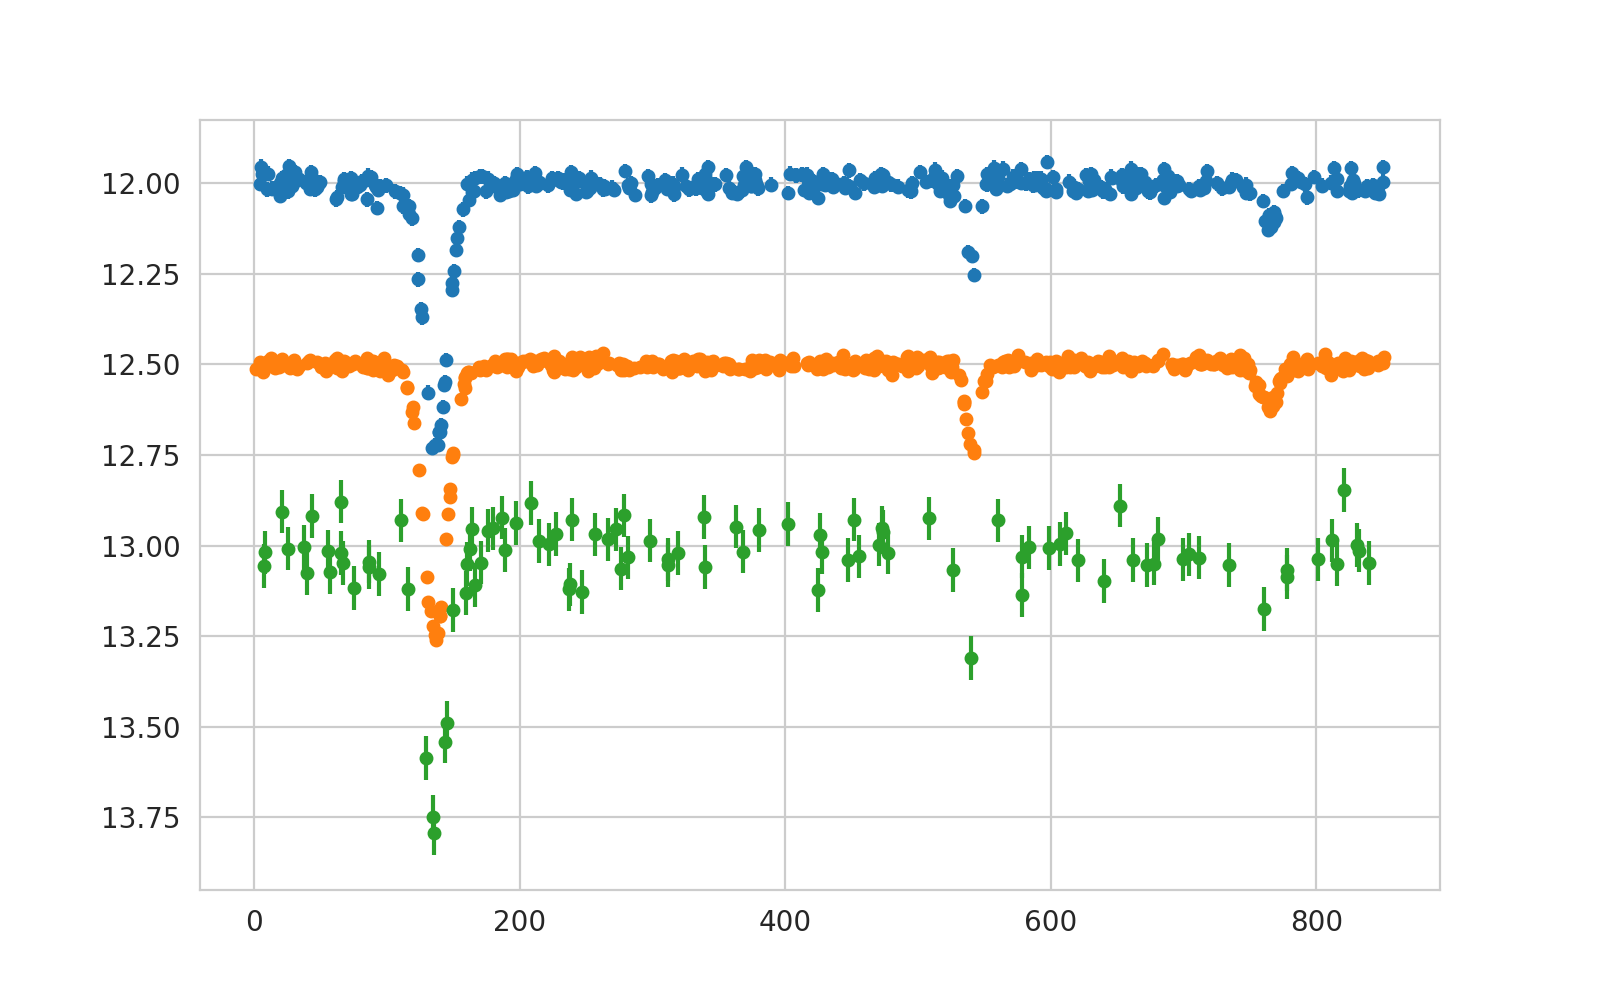

(13.950336396001095, 11.825920542128662)

In [20]:
np.random.seed(400)
lc_all = simulate_lightcurves_from_fluxes(time, flux, nbands=3, npoints=[400, 600, 100], 
                              err=[0.02, 0.01, 0.06], mean_mag=[12.0, 12.5, 13.0])

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for lc in lc_all:
    ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)

ax.set_ylim(ax.get_ylim()[::-1])

Okay, so that seems to work, too. 

Let's decide some actual cadences:

<IPython.core.display.Javascript object>


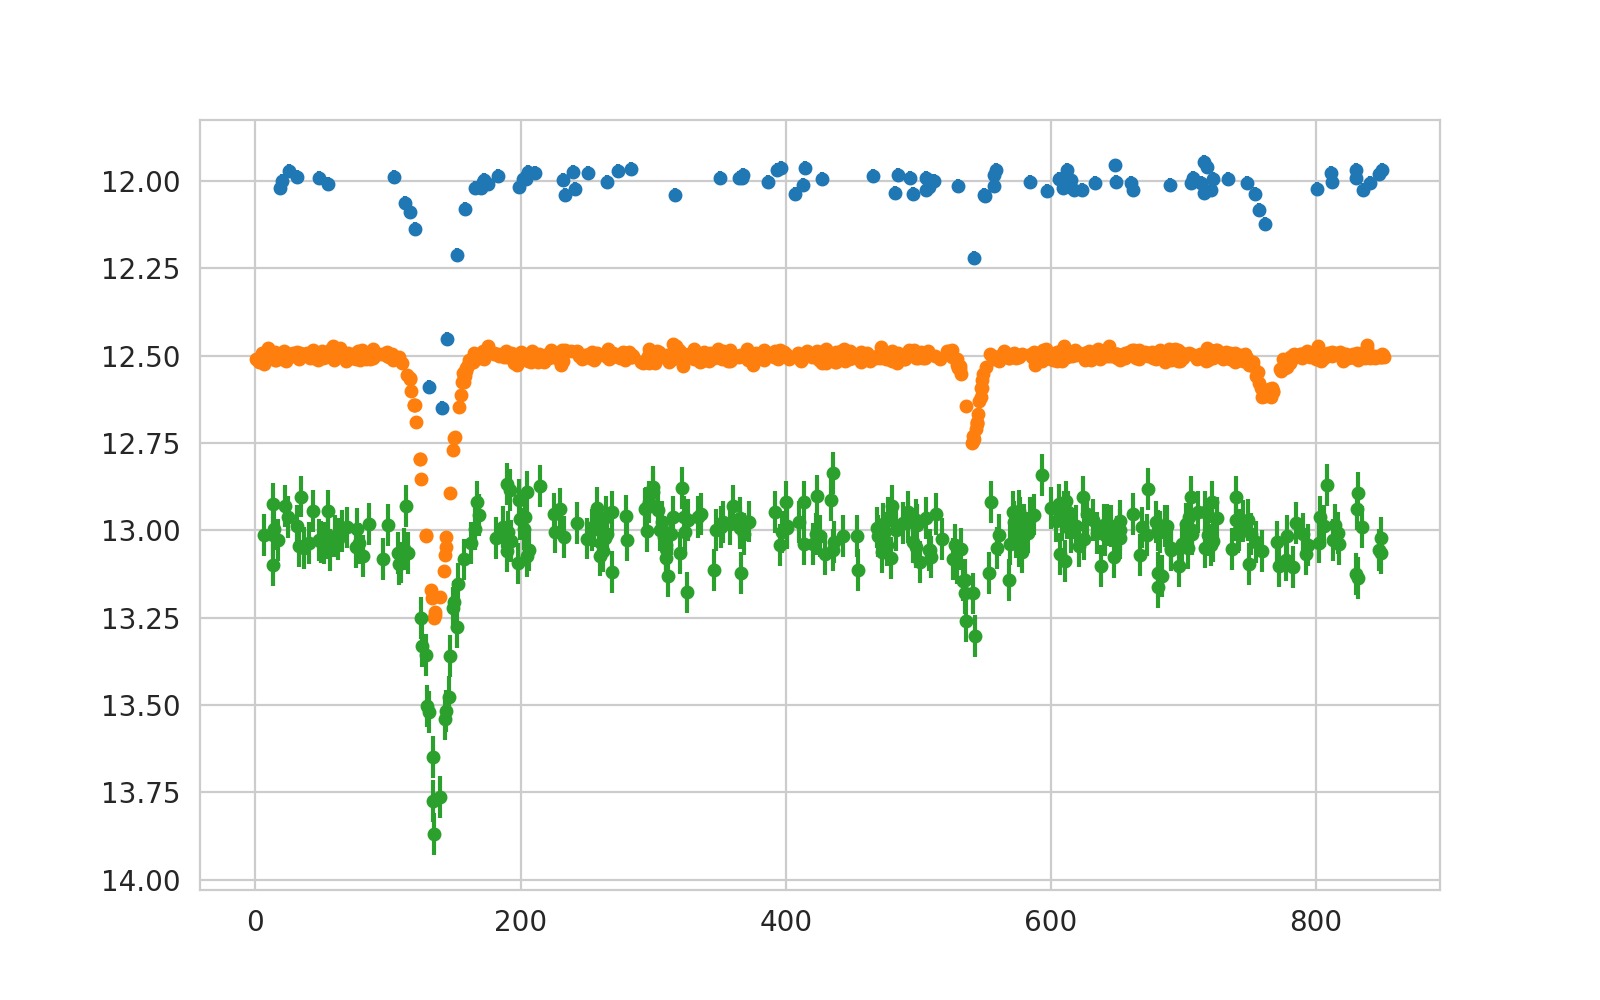

(14.029879602088839, 11.825649139018777)

In [21]:
c1 = np.sort(np.random.uniform(0, tseg, 100))
c2 = np.sort(np.random.uniform(0, tseg, 800))
c3 = np.sort(np.random.uniform(0, tseg, 300))

cadences = np.array([c1, c2, c3])

np.random.seed(1000)
lc_all = simulate_lightcurves_from_function(width, depth, nbands=3, cadence=cadences, 
                              err=[0.02, 0.01, 0.06], mean_mag=[12.0, 12.5, 13.0])

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for lc in lc_all:
    ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)

ax.set_ylim(ax.get_ylim()[::-1])

Hooray, that works, too. 

### Importing ZTF Cadences

Now we can import ZTF cadences and errors and hopefully start making realistic light curves:

In [22]:
datadir = "/epyc/data/boyajian/"

pickle_file = "sample_mjds_2.pkl"

In [23]:
ztf_cadence = pd.read_pickle(datadir + pickle_file)

In [24]:
ztf_cadence.head()

mjd_g  \
0  [58204.201331, 58206.1338889, 58450.4353819, 5...   
1  [58208.4476505, 58208.4842824, 58234.3558912, ...   
2  [58598.42826391111, 58598.42871531111, 58246.3...   
3  [58205.4712847, 58246.3551505, 58728.162881911...   
4  [58599.37923613333, 58235.417419, 58274.377963...   

                                               mag_g  \
0  [18.049786, 17.98969, 17.893917, 17.893661, 17...   
1  [16.587982, 16.418648, 16.603691, 16.678661, 1...   
2  [20.503447, 20.104498, 20.468098, 20.198317, 2...   
3  [19.52711, 19.600018, 19.734375, 19.756207, 19...   
4  [20.6547, 19.874813, 20.611324, 20.21209, 20.3...   

                                            magerr_g  \
0  [0.043785494, 0.042514425, 0.04061343, 0.04060...   
1  [0.027895203, 0.027219111, 0.02796397, 0.02830...   
2  [0.1468122, 0.12067488, 0.120341174, 0.1270227...   
3  [0.07429419, 0.07745236, 0.097713016, 0.084637...   
4  [0.14792758, 0.09857254, 0.13027763, 0.1135262...   

                                               mjd_r  \
0  [58475.45729171111, 58450.3772454, 58475.45774...   
1  [58502.56362271111, 58502.56866901111, 58502.5...   
2  [58694.26076391111, 58723.21578701111, 58217.4...   
3  [58694.26076391111, 58723.21578701111, 58666.3...   
4  [58700.21489581111, 58686.27434031111, 58700.2...   

                                               mag_r  \
0  [17.445889, 17.433268, 17.45091, 17.46019, 17....   
1  [15.69869, 15.667656, 15.66051, 15.677812, 15....   
2  [19.5084, 19.513474, 19.416594, 19.455902, 19....   
3  [18.070387, 18.075138, 18.075306, 18.28212, 18...   
4  [19.047123, 19.245966, 19.162663, 19.18438, 19...   

                                            magerr_r  
0  [0.029131362, 0.029901987, 0.029236319, 0.0294...  
1  [0.012726132, 0.012664719, 0.012650874, 0.0148...  
2  [0.08006927, 0.08037927, 0.08319566, 0.0769301...  
3  [0.029745415, 0.029832937, 0.029836038, 0.0340...  
4  [0.06769094, 0.07629721, 0.07256523, 0.0735206...

I have a function that returns data from that table in a dictionary:

In [25]:
def get_ztf_lightcurve(ztf_df, idx):
    """
    Get a dictionary with ZTF points in r and g bands out 
    of the cadence data frame
    
    Parameters
    ----------
    ztf_df : pd.DataFrame
        A DataFrame with the ZTF data, has columns `mjd_g`, `mag_g`, 
        `magerr_g`, `mjd_r`, `mag_r`, `magerr_r`
        
    idx: int
        An index in ztf_df.index to choose a particular light curve
        
    Returns
    -------
    ztf_lc : dict
        A dictionary with the data in a given row of the DataFrame
    """
    ztf_line = ztf_df.loc[idx]
    # get out data in g-band
    mjd_g = ztf_line[0]
    mag_g = ztf_line[1]
    magerr_g = ztf_line[2]
    # select only "good" observations with 
    # the magnitude error > 0
    good_g = magerr_g > 0.0
    mjd_g = mjd_g[good_g]
    mag_g = mag_g[good_g]
    magerr_g = magerr_g[good_g]
    # make sure data is sorted in time
    g_idx = np.argsort(mjd_g)
    mjd_g = mjd_g[g_idx]
    mag_g = mag_g[g_idx]
    magerr_g = magerr_g[g_idx]

    # get out r-band data
    mjd_r = ztf_line[3]
    mag_r = ztf_line[4]
    magerr_r = ztf_line[5]
    # pick only data points with good errors
    good_r = magerr_r > 0.0
    mjd_r = mjd_r[good_r]
    mag_r = mag_r[good_r]
    magerr_r = magerr_r[good_r]
    # sort in time
    r_idx = np.argsort(mjd_r)
    mjd_r = mjd_r[r_idx]
    mag_r = mag_r[r_idx]
    magerr_r = magerr_r[r_idx]

    tseg_g = mjd_g.max() - mjd_g.min()
    tseg_r = mjd_r.max() - mjd_r.min()

    ztf_lc = {"mjd_g": mjd_g, "mag_g": mag_g, "magerr_g": magerr_g,
              "mjd_r": mjd_r, "mag_r": mag_r, "magerr_r": magerr_r,
              "meanmag_g": np.mean(mag_g), "meanmag_r": np.mean(mag_r),
              "tseg_g": tseg_g, "tseg_r": tseg_r,
              "ng": len(mjd_g), "nr": len(mjd_r),
              "zero_g": mjd_g[0], "zero_r":mjd_r[0]}

    return ztf_lc




In [36]:
ztf_lc = get_ztf_lightcurve(ztf_cadence, 4000)

In [37]:
print("Total length in g band: " + str(ztf_lc["tseg_g"]))
print("Total length in r band: " + str(ztf_lc["tseg_r"]))

Total length in g band: 560.8639003999997
Total length in r band: 567.7608912000069


Now I can hopefully stick that cadence into my simulated dips:

<IPython.core.display.Javascript object>


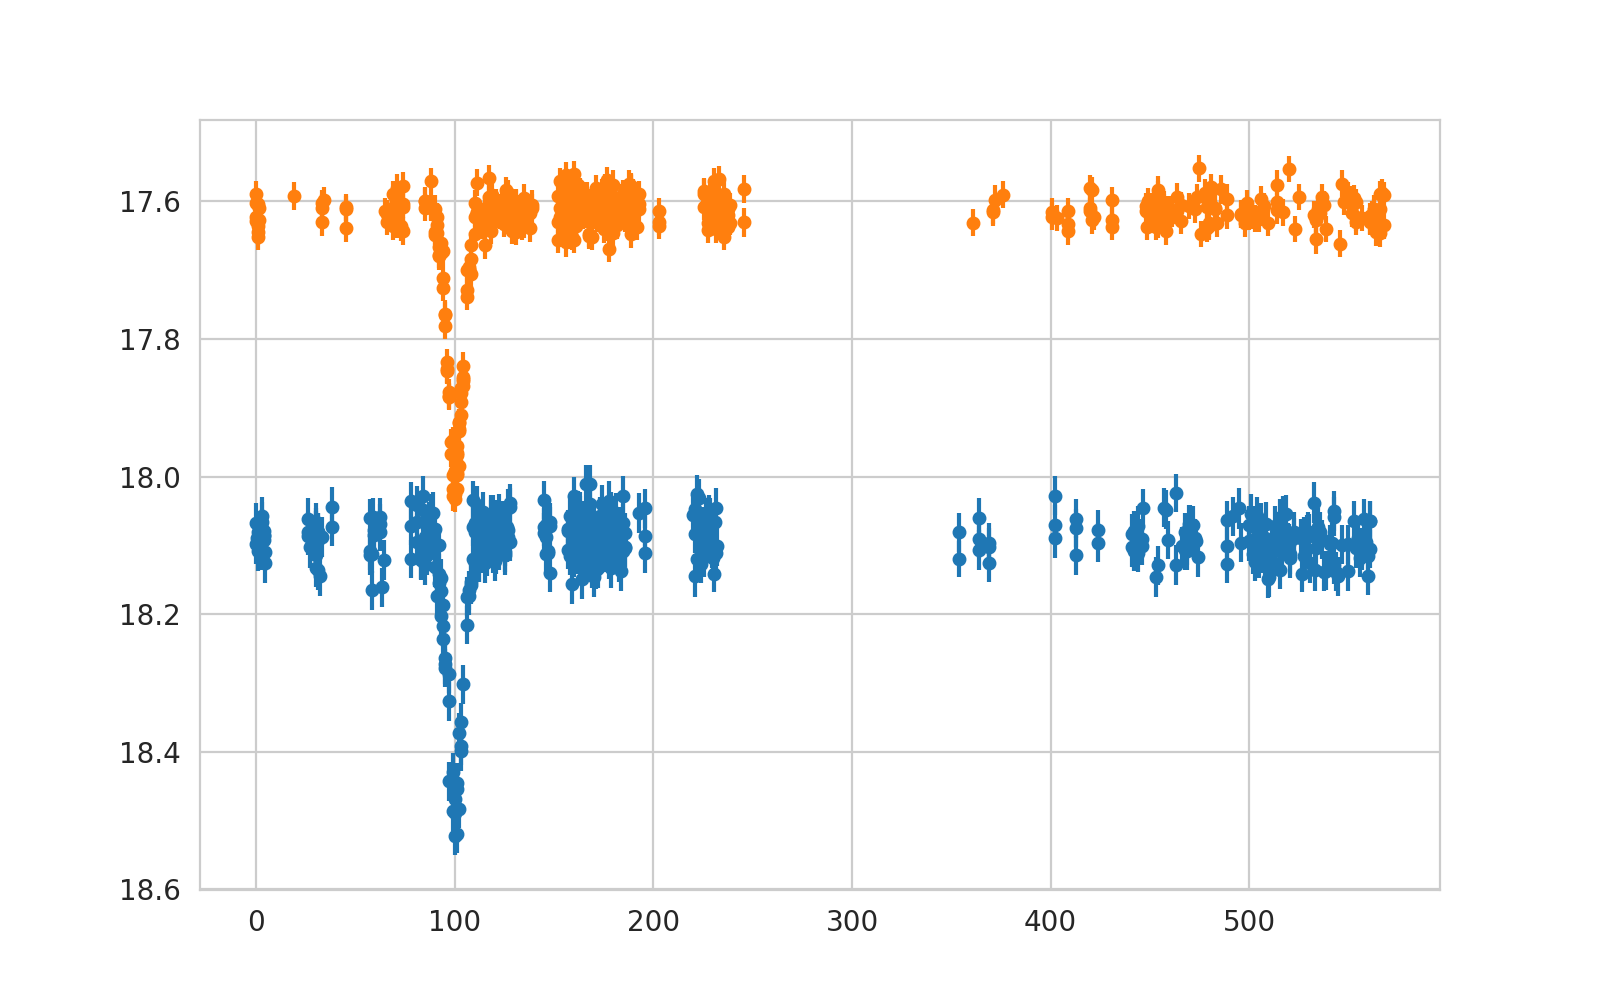

(18.60111731723366, 17.48157158046861)

In [38]:
c1 = ztf_lc["mjd_g"] - ztf_lc["zero_g"]
c2 = ztf_lc["mjd_r"] - ztf_lc["zero_r"]

cadences = np.array([c1, c2])
nbands = 2
mean_mag = np.array([ztf_lc["meanmag_g"], ztf_lc["meanmag_r"]])
err = np.array([ztf_lc["magerr_g"], ztf_lc["magerr_r"]])

np.random.seed(1000)
lc_all = simulate_lightcurves_from_function(depth=0.3, width=4, tdip=100, nbands=nbands, cadence=cadences, 
                              err=err, mean_mag=mean_mag)

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for lc in lc_all:
    ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)

ax.set_ylim(ax.get_ylim()[::-1])

Well, that' plots a thing!

## Simulate 1 Dip, Same Depth + Width

Let's start by simulating a single dip with the same depth and width:

In [39]:
width = 5.0
depth = 0.5

coverage = 5

time, flux = simulate_dip_flux(tseg, coverage, width, depth)

Before we do this on the ZTF cadences, I want to get a feeling for how high the relevant scores should be from the dip detection function:

In [40]:
npoints = [100, 200, 500, 1000]
nsims = 1000

lc_sims_all = []
res_sims_all = []
for npts in npoints:
    lc_sims = []
    res_sims = []
    for i in range(nsims):
        lc_all = simulate_lightcurves_from_fluxes(time, flux, nbands=1, npoints=np.array([npts]), err=0.02, mean_mag=12.0)
        t_all = [lc.time for lc in lc_all]
        mag_all = [lc.flux for lc in lc_all]
        magerr_all = [lc.flux_err for lc in lc_all]

        res = measure_dip(t_all, mag_all, magerr_all)
        lc_sims.append(lc_all[0])
        res_sims.append(res)
    lc_sims_all.append(lc_sims)
    res_sims_all.append(res_sims)

<IPython.core.display.Javascript object>


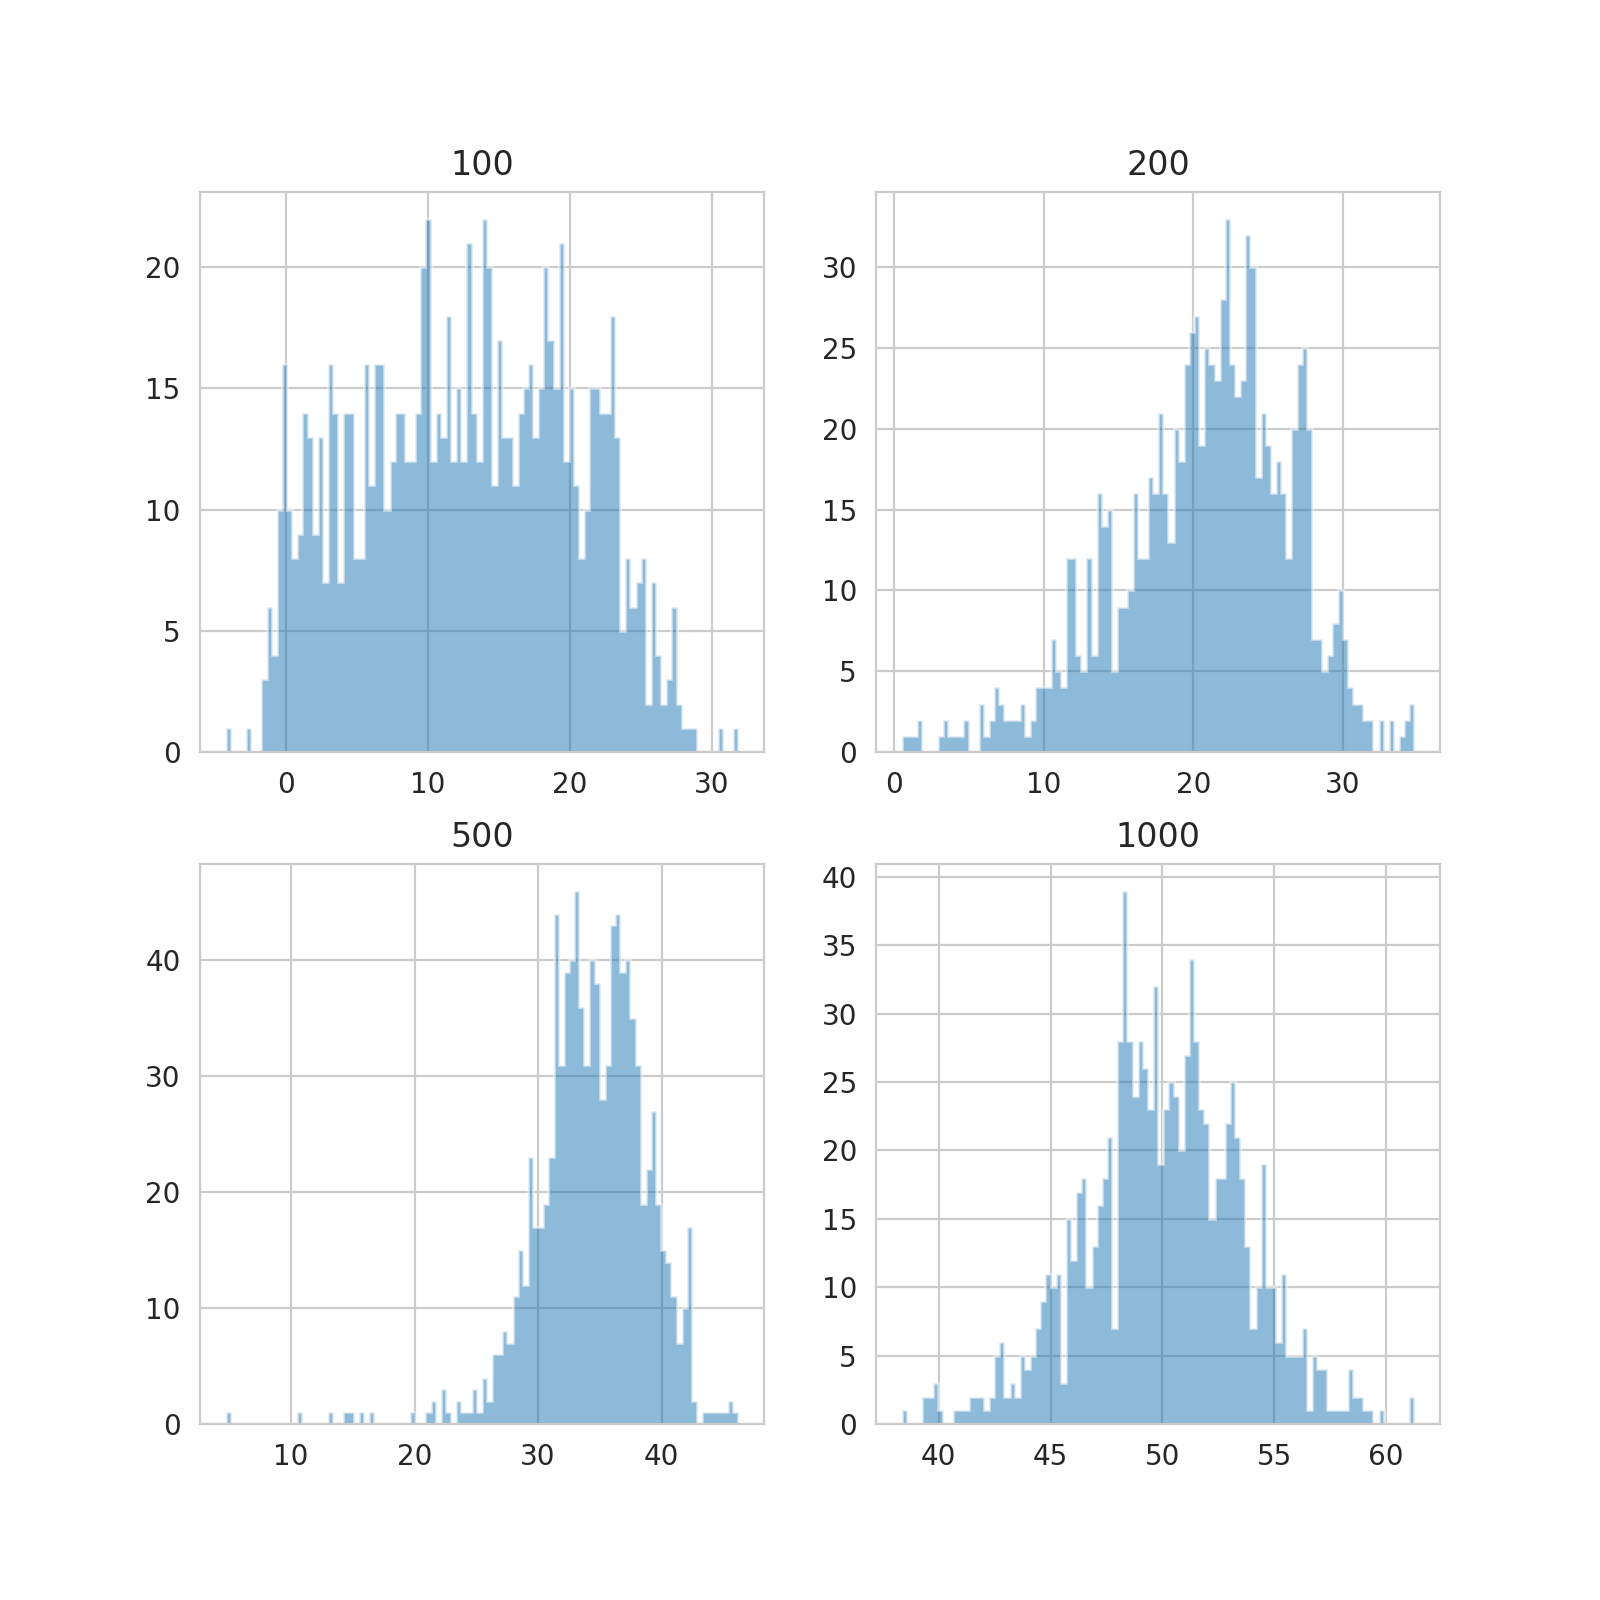

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))

axes = np.hstack(axes)

for i in range(len(res_sims_all)):
    res_sims = res_sims_all[i]
    sig_sims = np.array([res["significance"] for res in res_sims])
    axes[i].hist(sig_sims, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(npoints[i])

All right, that's useful to know. Let's now take a look at the ZTF cadences:

In [42]:
nztf = len(ztf_cadence)

In [182]:
idx_all = np.random.randint(0, nztf, size=100)

In [43]:
lc_sim_all = []

idx_all = np.random.randint(0, nztf, size=10000)
for idx in idx_all:
    ztf_lc = get_ztf_lightcurve(ztf_cadence, idx)
    max_time = np.max([ztf_lc["tseg_g"], ztf_lc["tseg_r"]])
    min_time = np.min([ztf_lc["zero_g"], ztf_lc["zero_r"]])
    
    max_start = tseg - max_time
    
    tstart = np.random.uniform(0, max_start, size=1)
    
    c1 = ztf_lc["mjd_g"] - ztf_lc["zero_g"] + tstart
    c2 = ztf_lc["mjd_r"] - ztf_lc["zero_r"] + tstart

    cadences = np.array([c1, c2])
    nbands = 2
    mean_mag = np.array([ztf_lc["meanmag_g"], ztf_lc["meanmag_r"]])
    magerr_g = ztf_lc["magerr_g"]
    magerr_r = ztf_lc["magerr_r"]
    magerr_g[magerr_g <= 0.0] = np.mean(magerr_g)
    magerr_r[magerr_r <= 0.0] = np.mean(magerr_r)
    err = np.array([magerr_g, magerr_r])
    
    lc_all = simulate_lightcurves_from_function(width, depth, nbands=nbands, cadence=cadences, 
                                  err=err, mean_mag=mean_mag)

    lc_sim_all.append(lc_all)


Now let's try to look for dips using Kyle's code:

In [44]:
from dipper import measure_dip

<IPython.core.display.Javascript object>


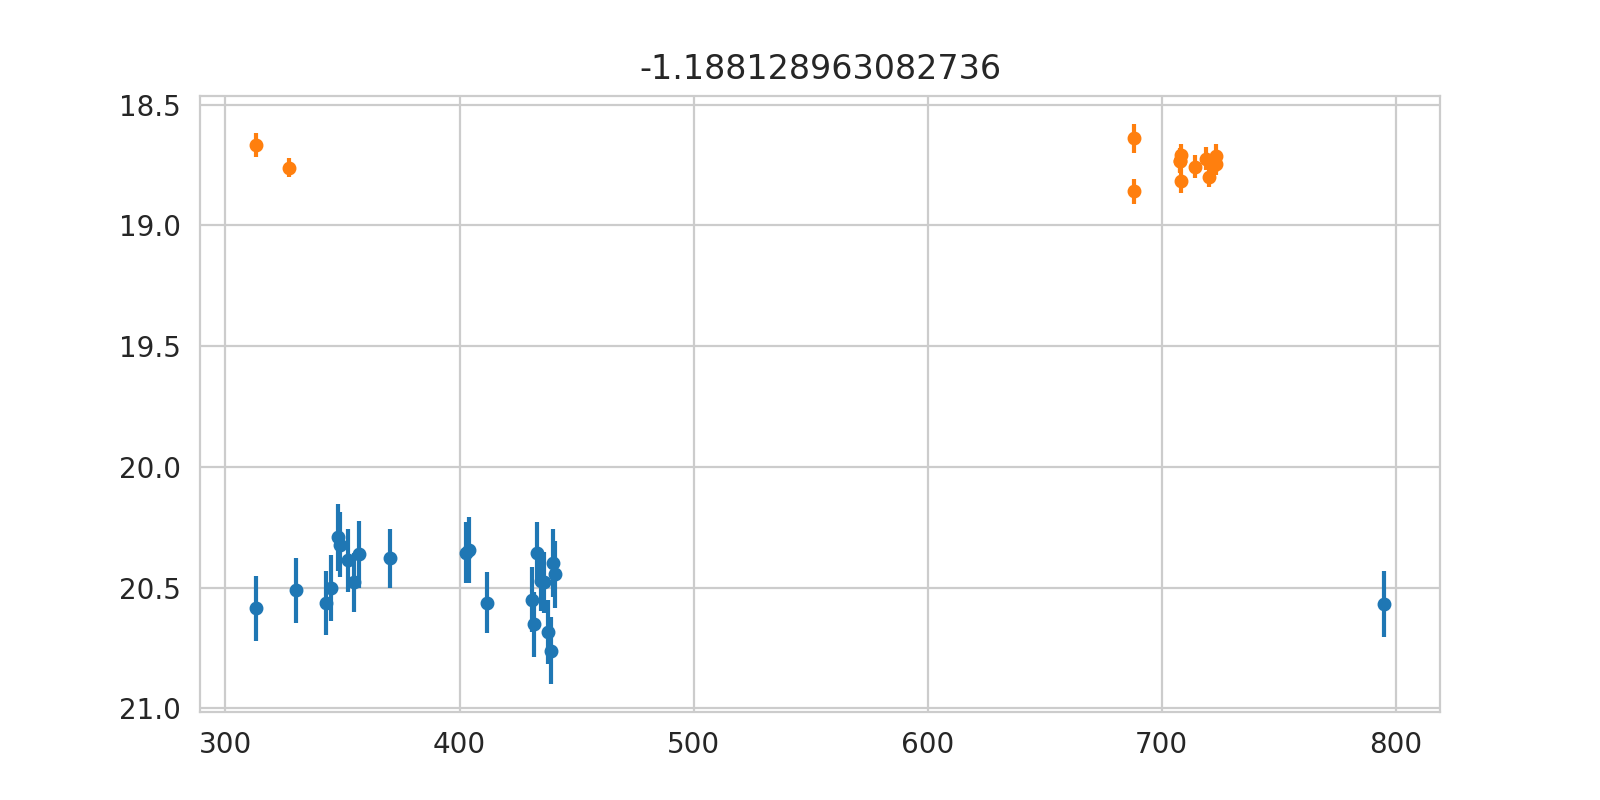

<IPython.core.display.Javascript object>


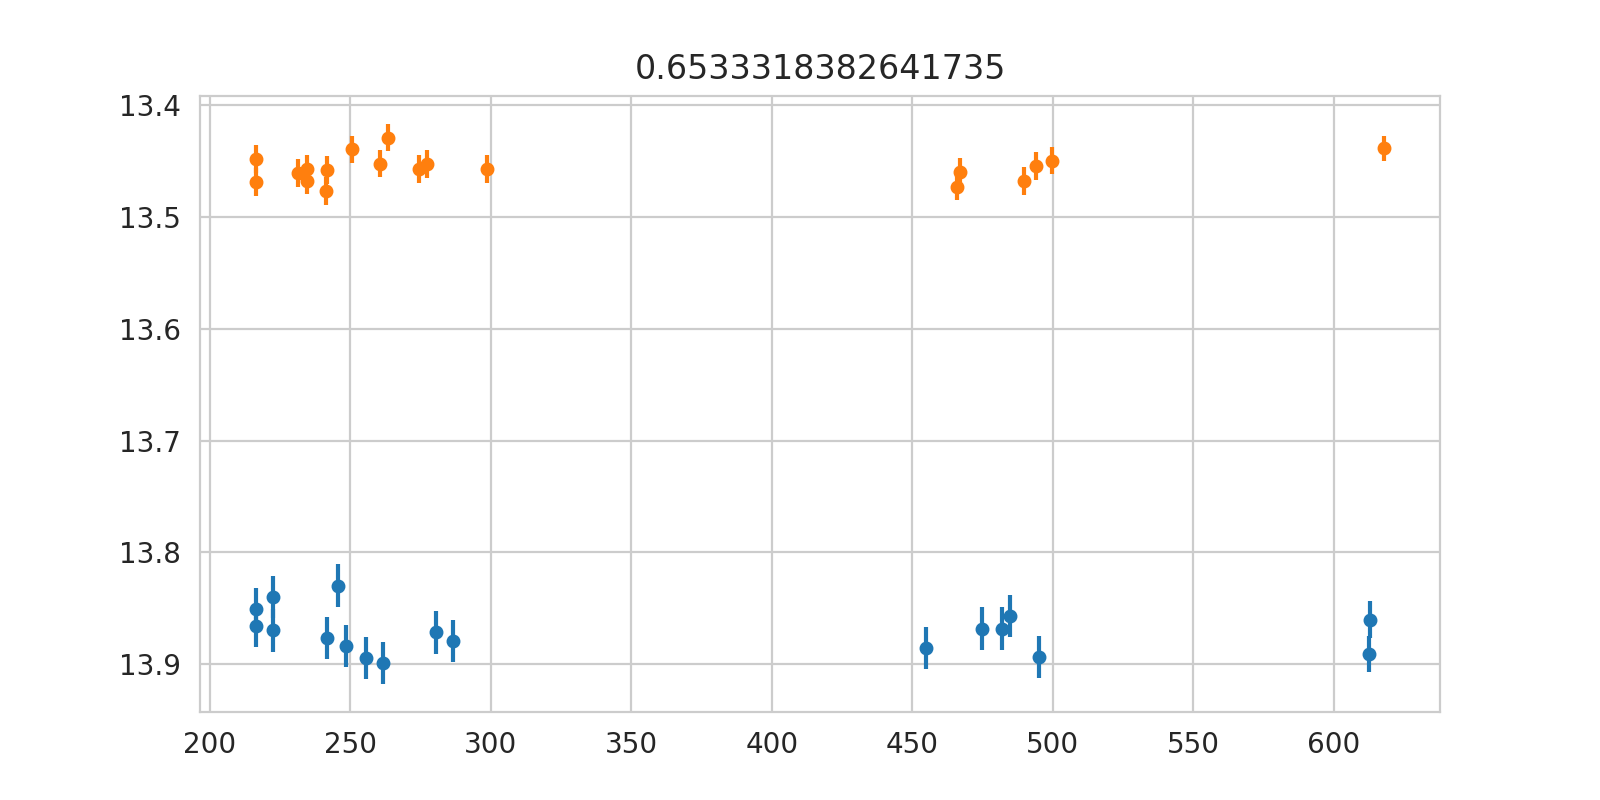

<IPython.core.display.Javascript object>


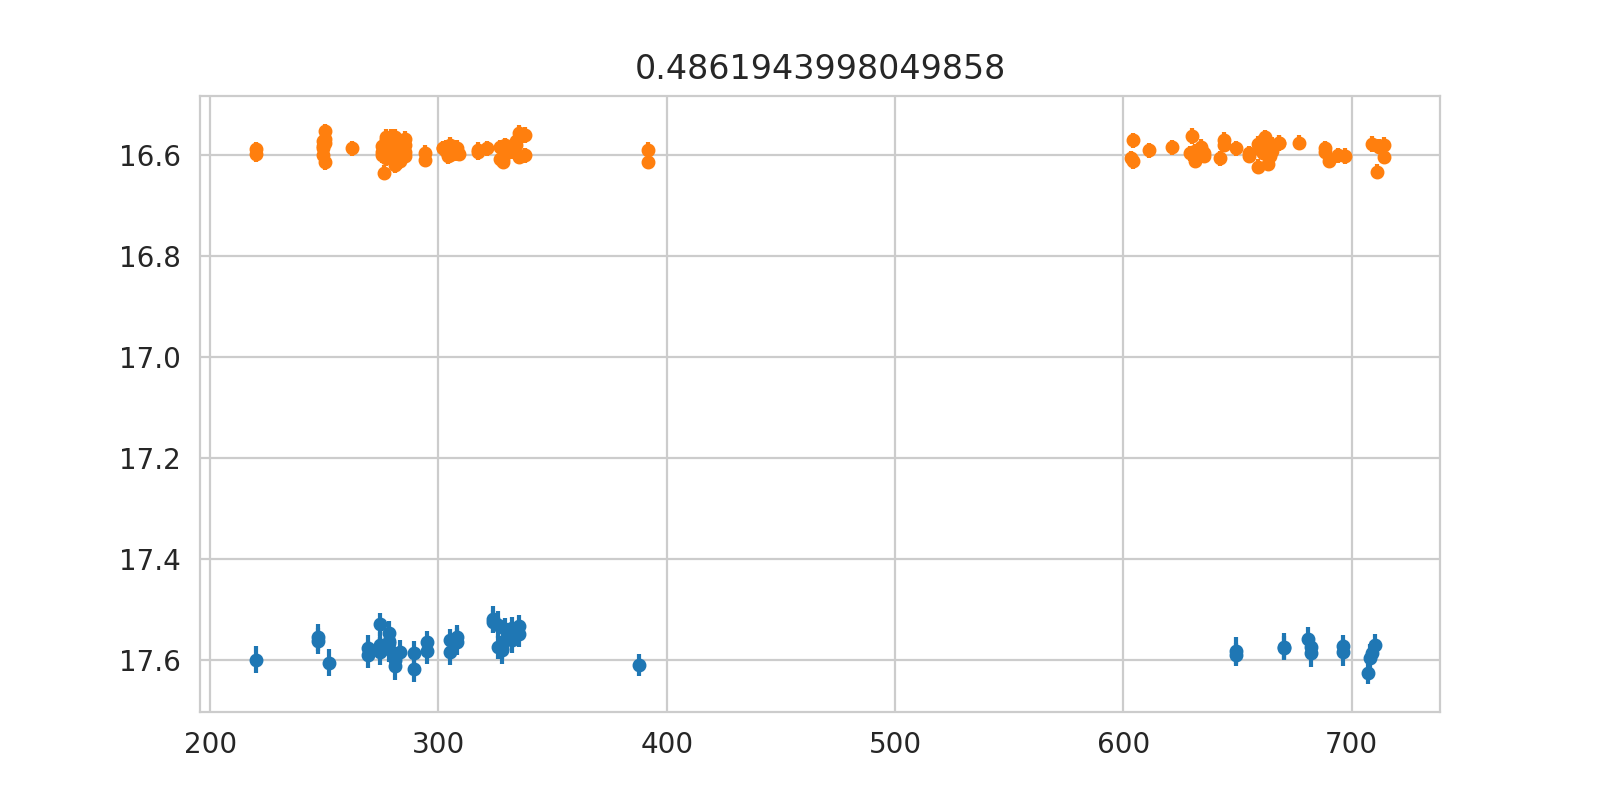

<IPython.core.display.Javascript object>


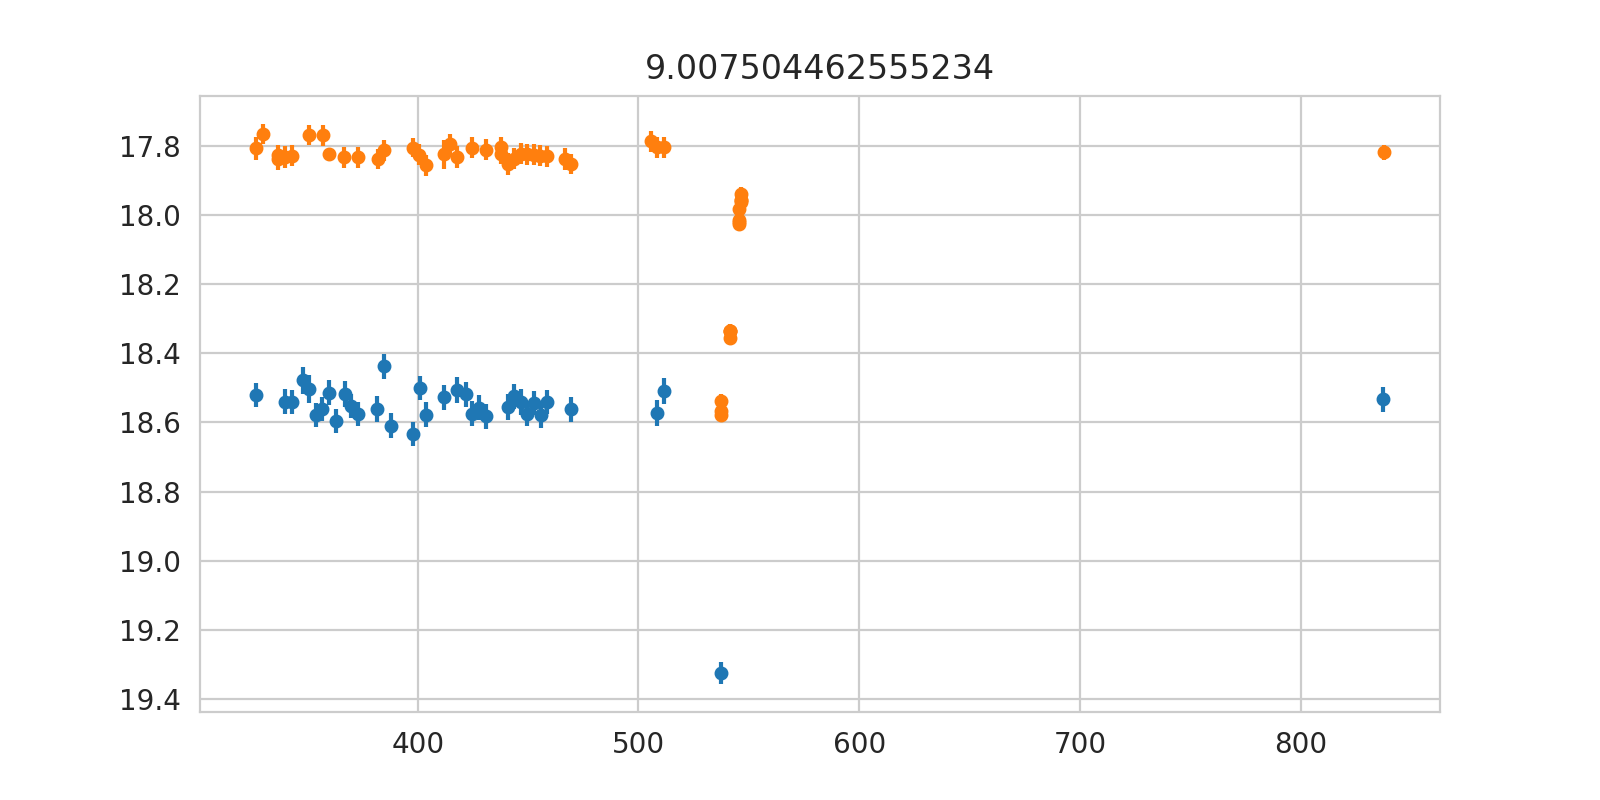

<IPython.core.display.Javascript object>


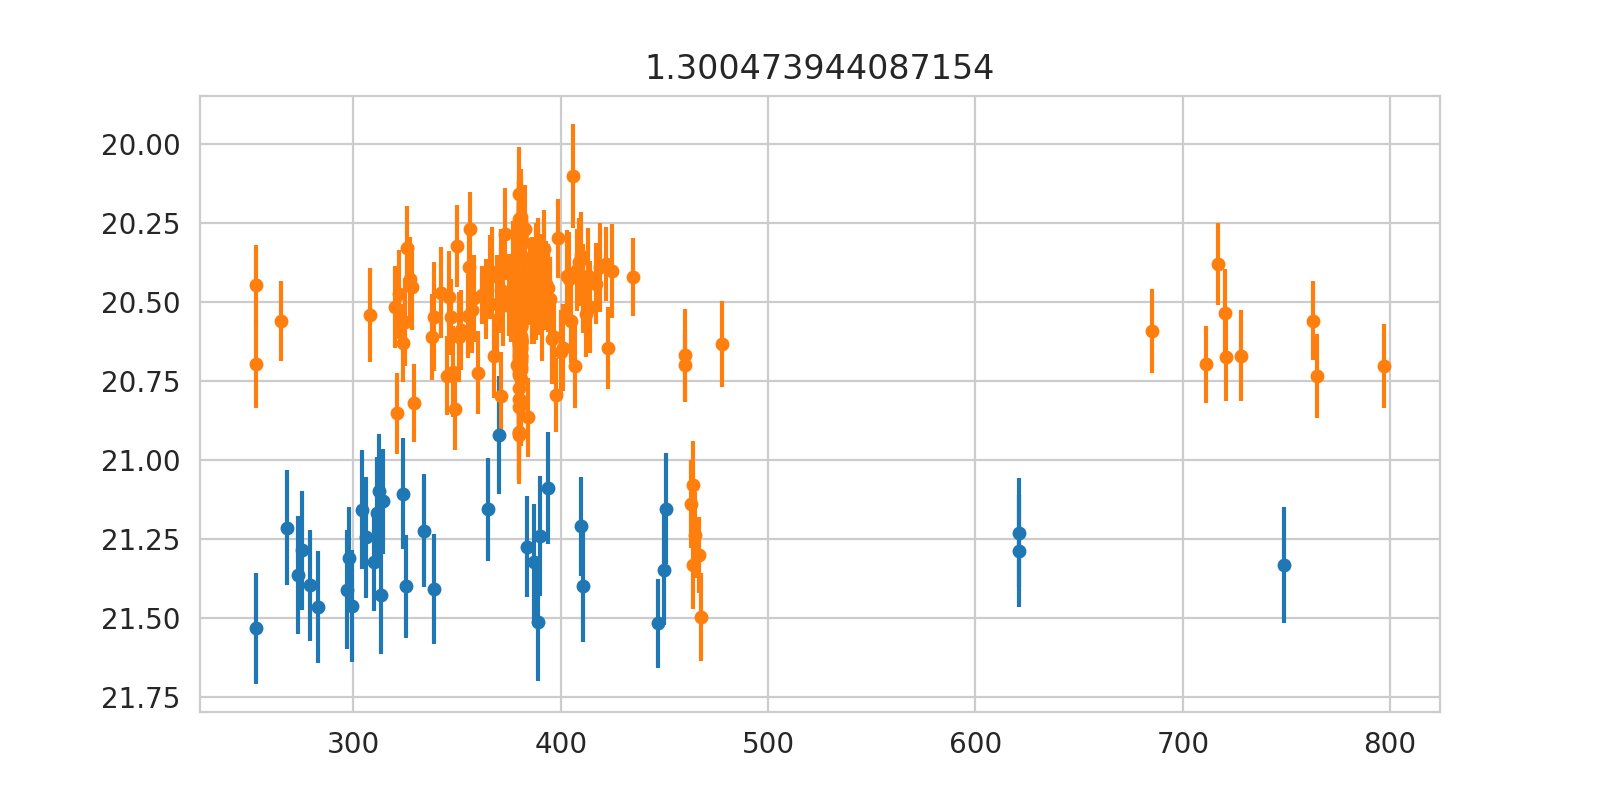

<IPython.core.display.Javascript object>


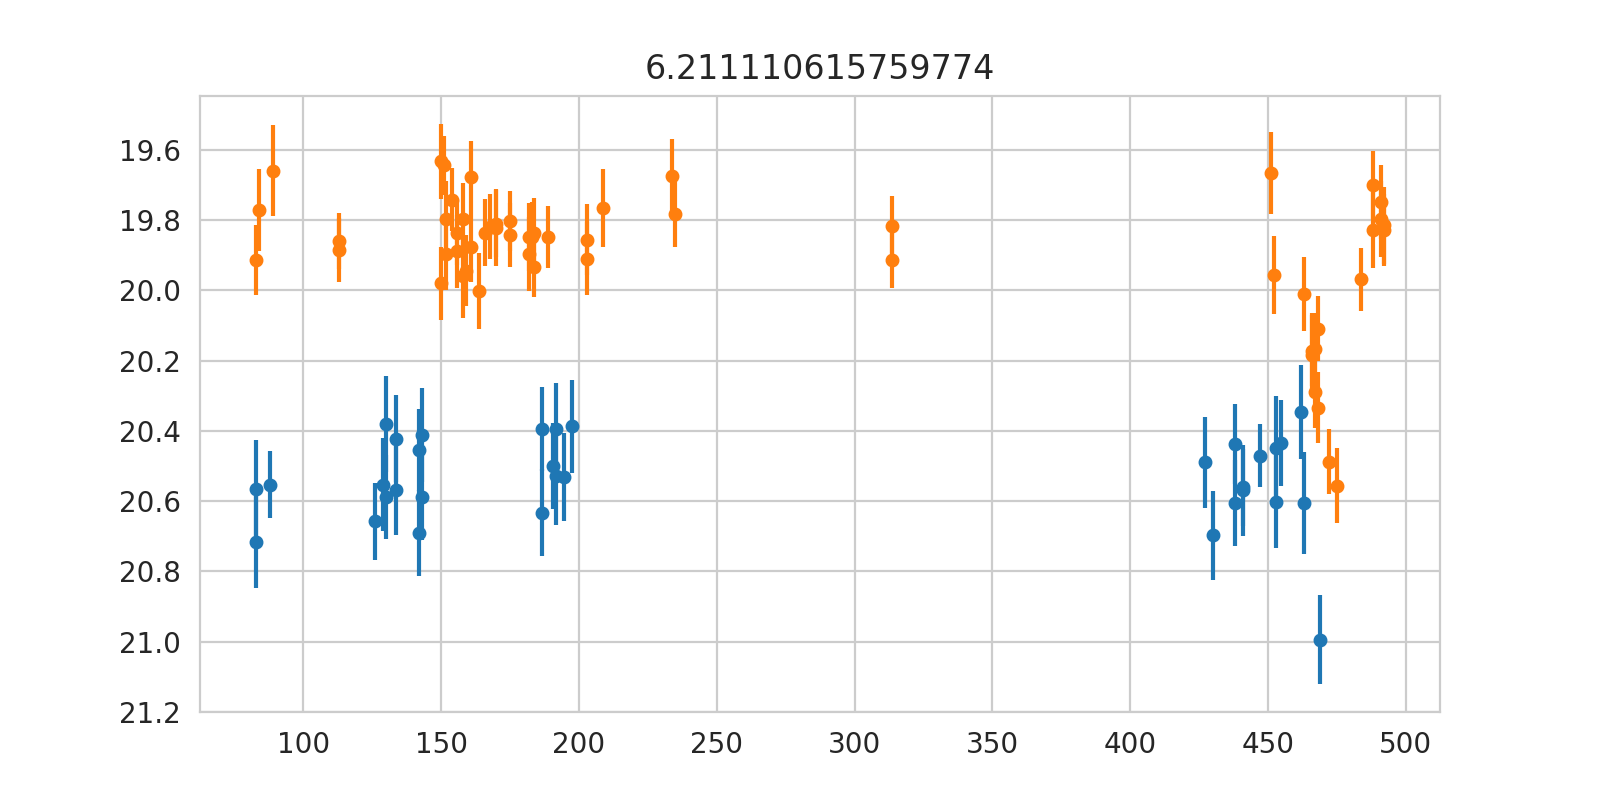

<IPython.core.display.Javascript object>


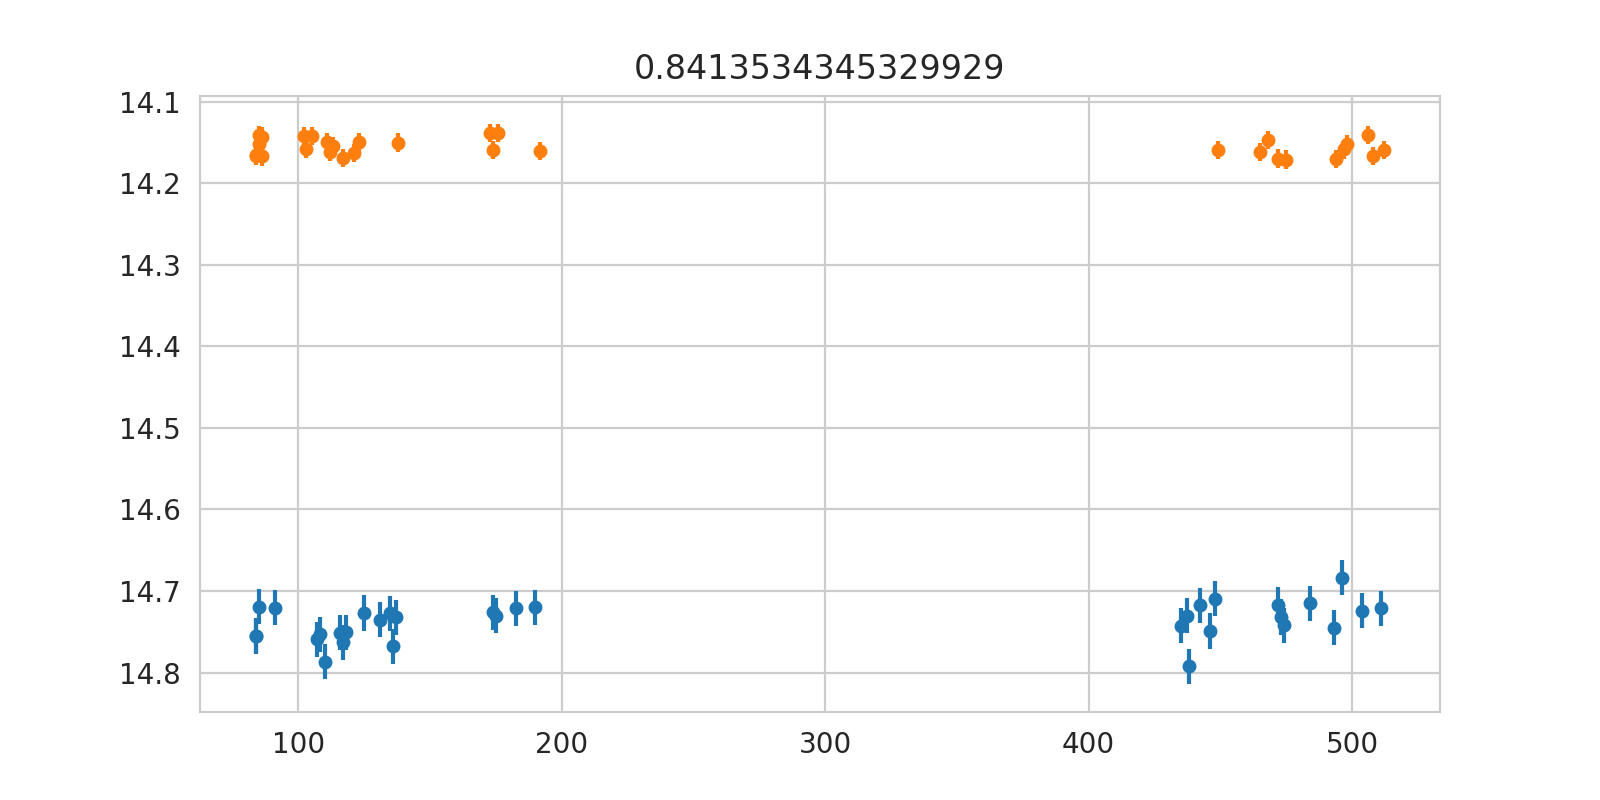

<IPython.core.display.Javascript object>


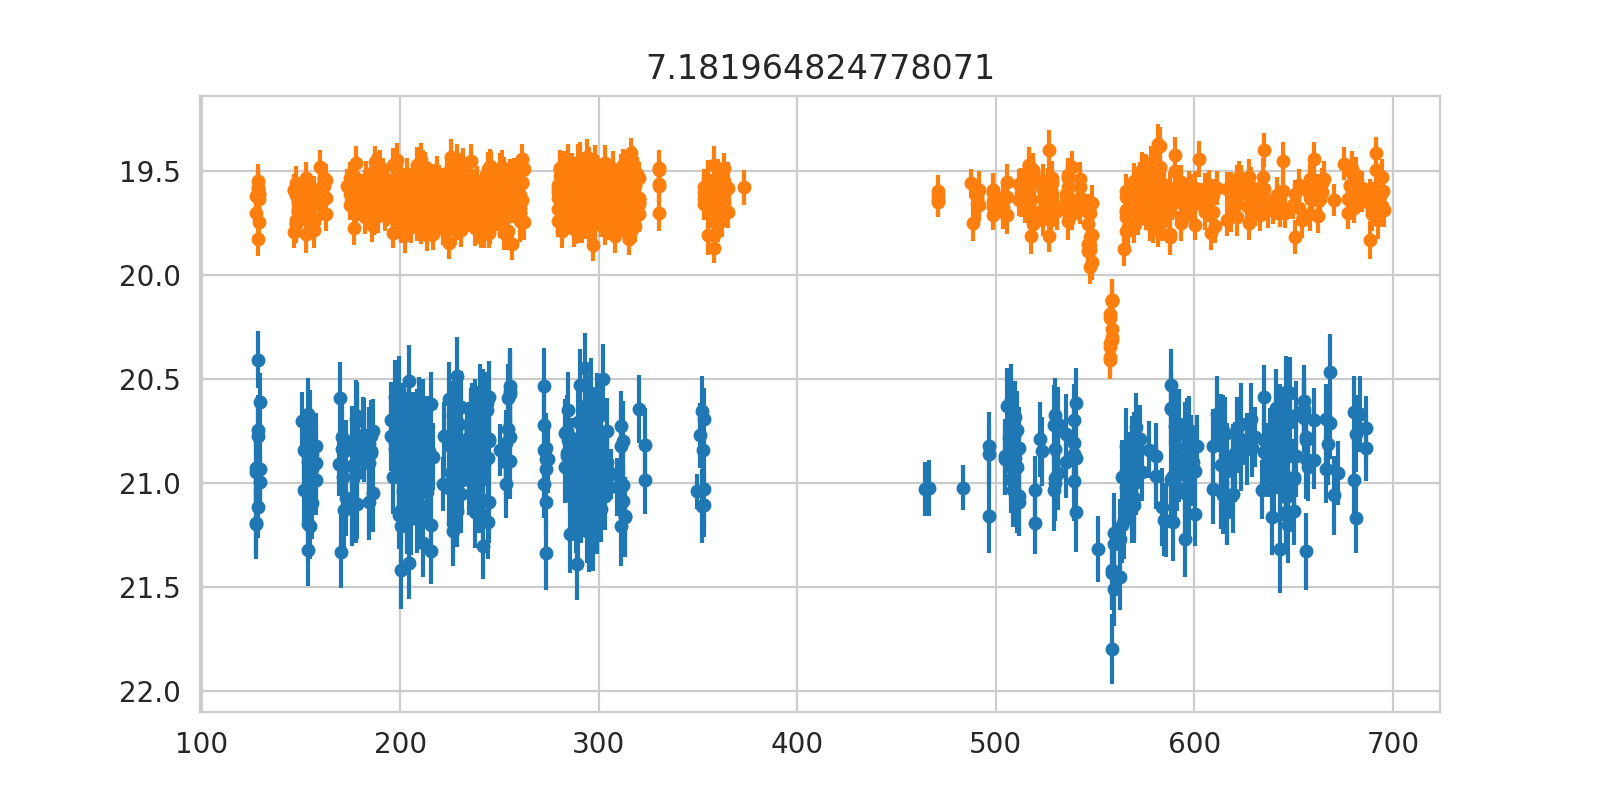

<IPython.core.display.Javascript object>


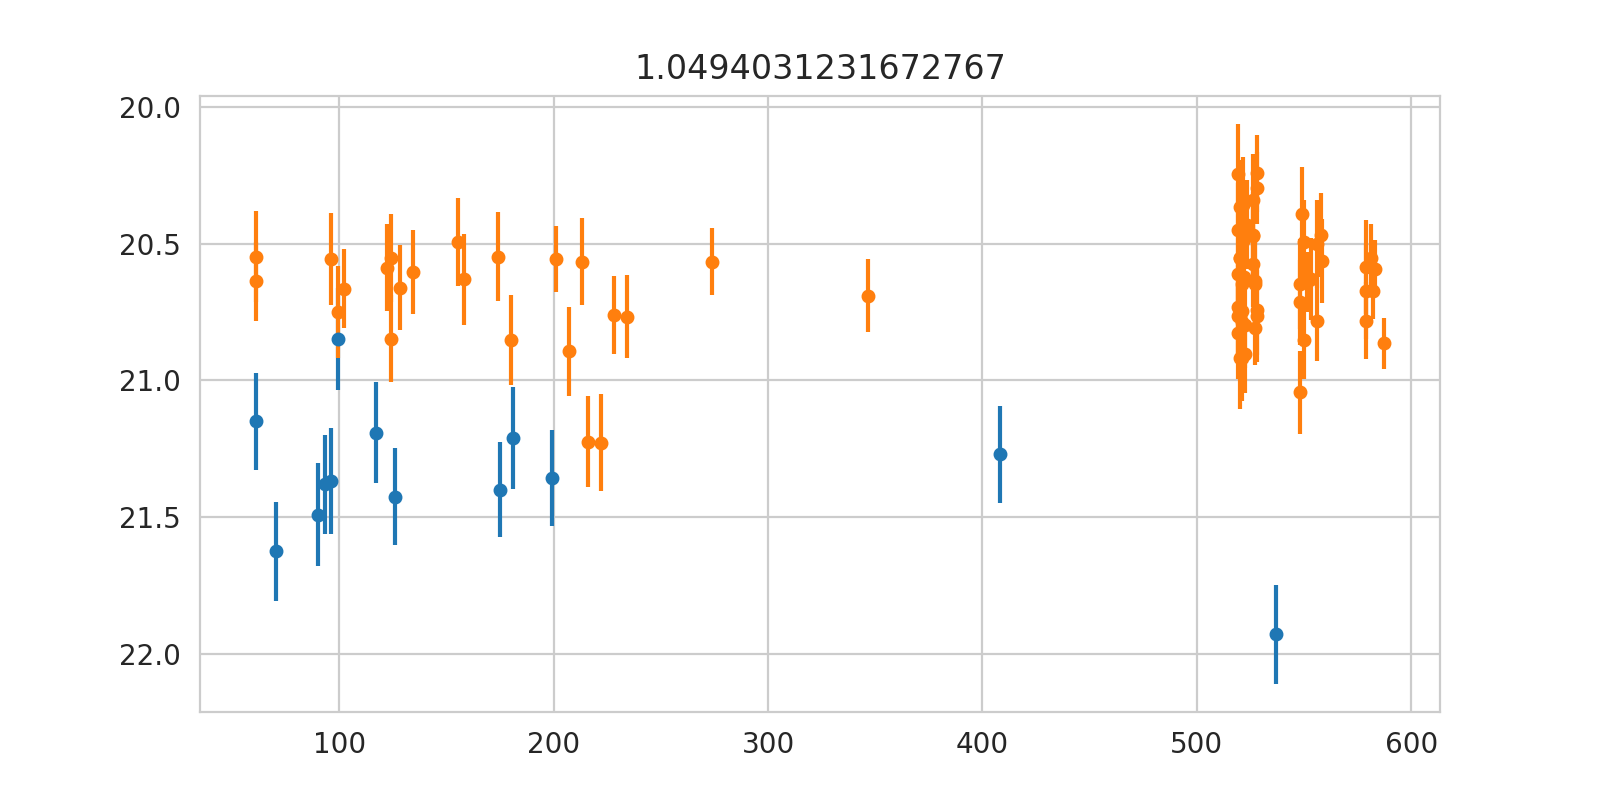

<IPython.core.display.Javascript object>


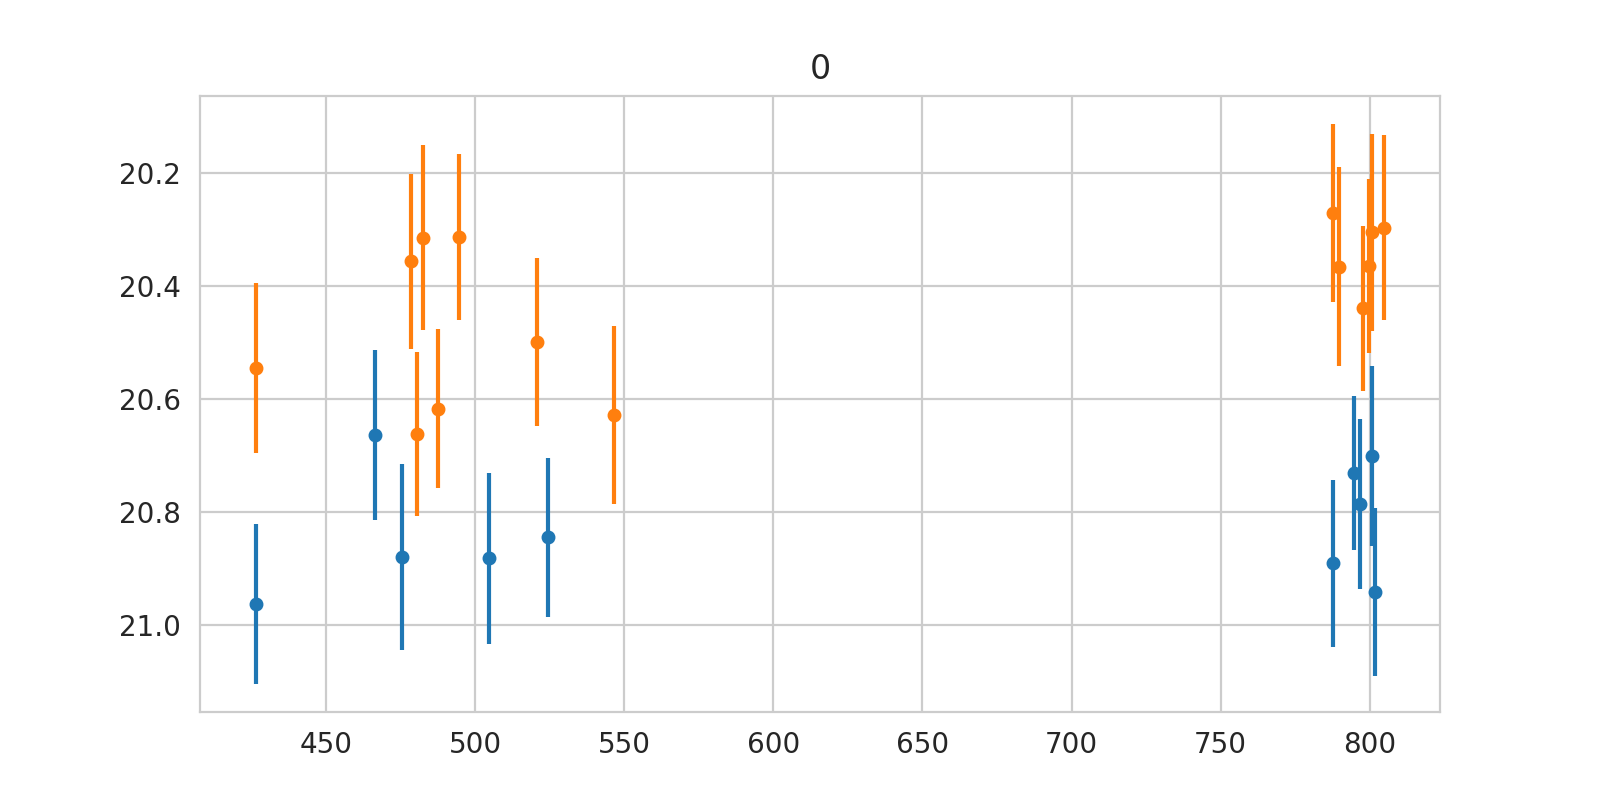

In [45]:
for i in range(10):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    lc_all = lc_sim_all[i]
    t_all = [lc.time for lc in lc_all]
    mag_all = [lc.flux for lc in lc_all]
    magerr_all = [lc.flux_err for lc in lc_all]

    res = measure_dip(t_all, mag_all, magerr_all)
    
    for lc in lc_all:
        ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)
    
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_title(res["significance"])


Okay, so that works. Now we can do this for all of our simulated light curves:

In [46]:
res_all = []

for lc_all in lc_sim_all:
    t_all = [lc.time for lc in lc_all]
    mag_all = [lc.flux for lc in lc_all]
    magerr_all = [lc.flux_err for lc in lc_all]

    res = measure_dip(t_all, mag_all, magerr_all)
    res_all.append(res)

Let's make a histogram of all the significances:

In [47]:
sig_all = np.array([res["significance"] for res in res_all])

<IPython.core.display.Javascript object>


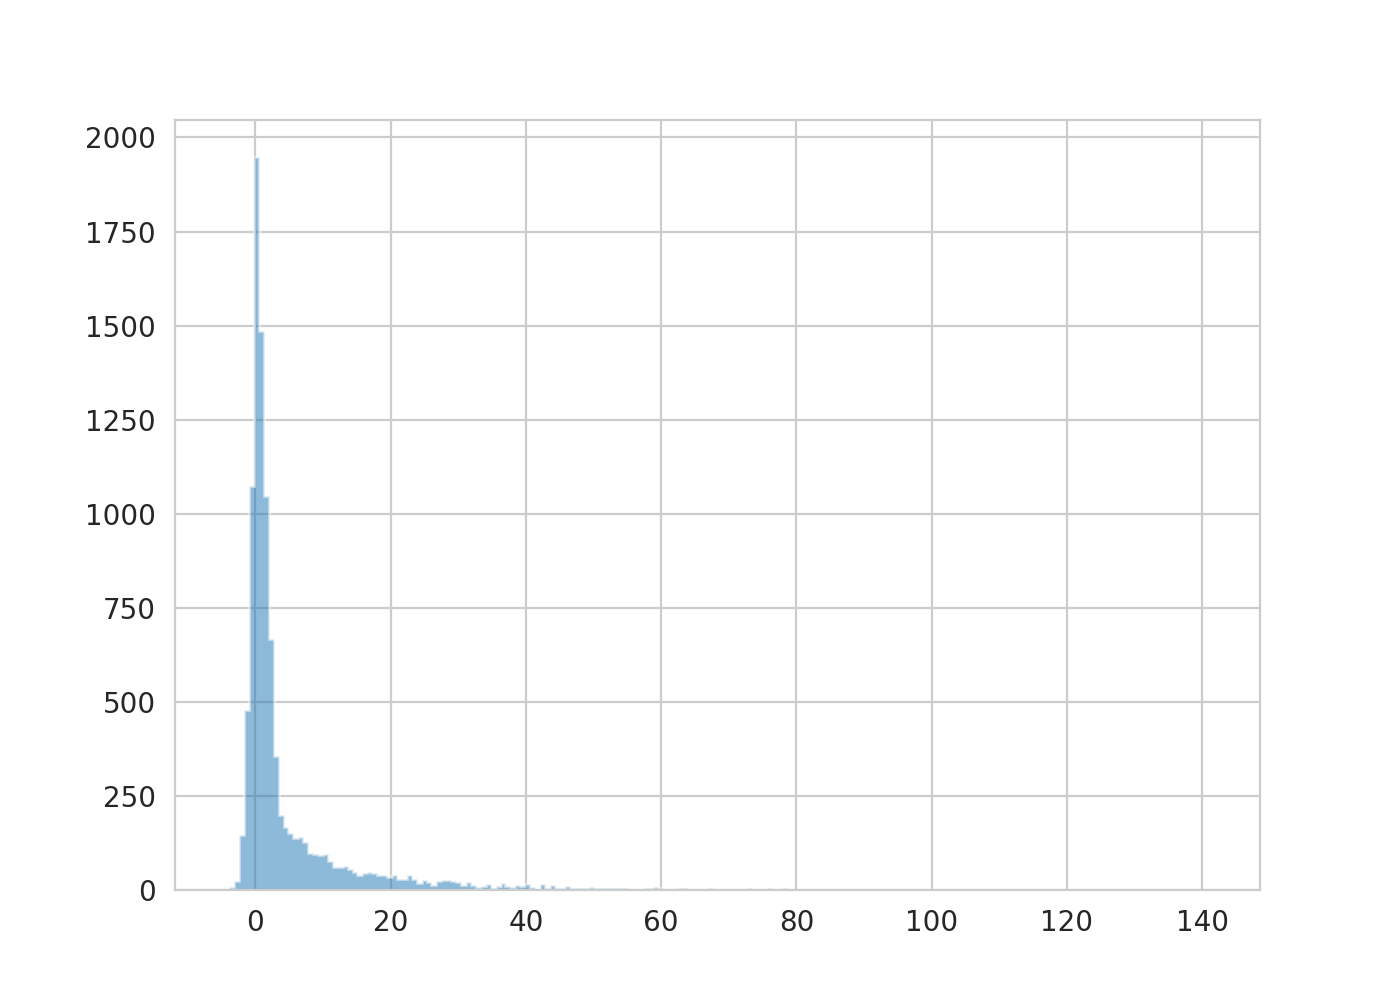

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

ax.hist(sig_all, bins=200, histtype="stepfilled", alpha=0.5);

We are going to look at the high-signal examples.
Let's look at some different examples with different scores:

In [49]:
np.min(sig_all)

-4.608099708074583

In [50]:
np.max(sig_all)

141.27991390533032

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


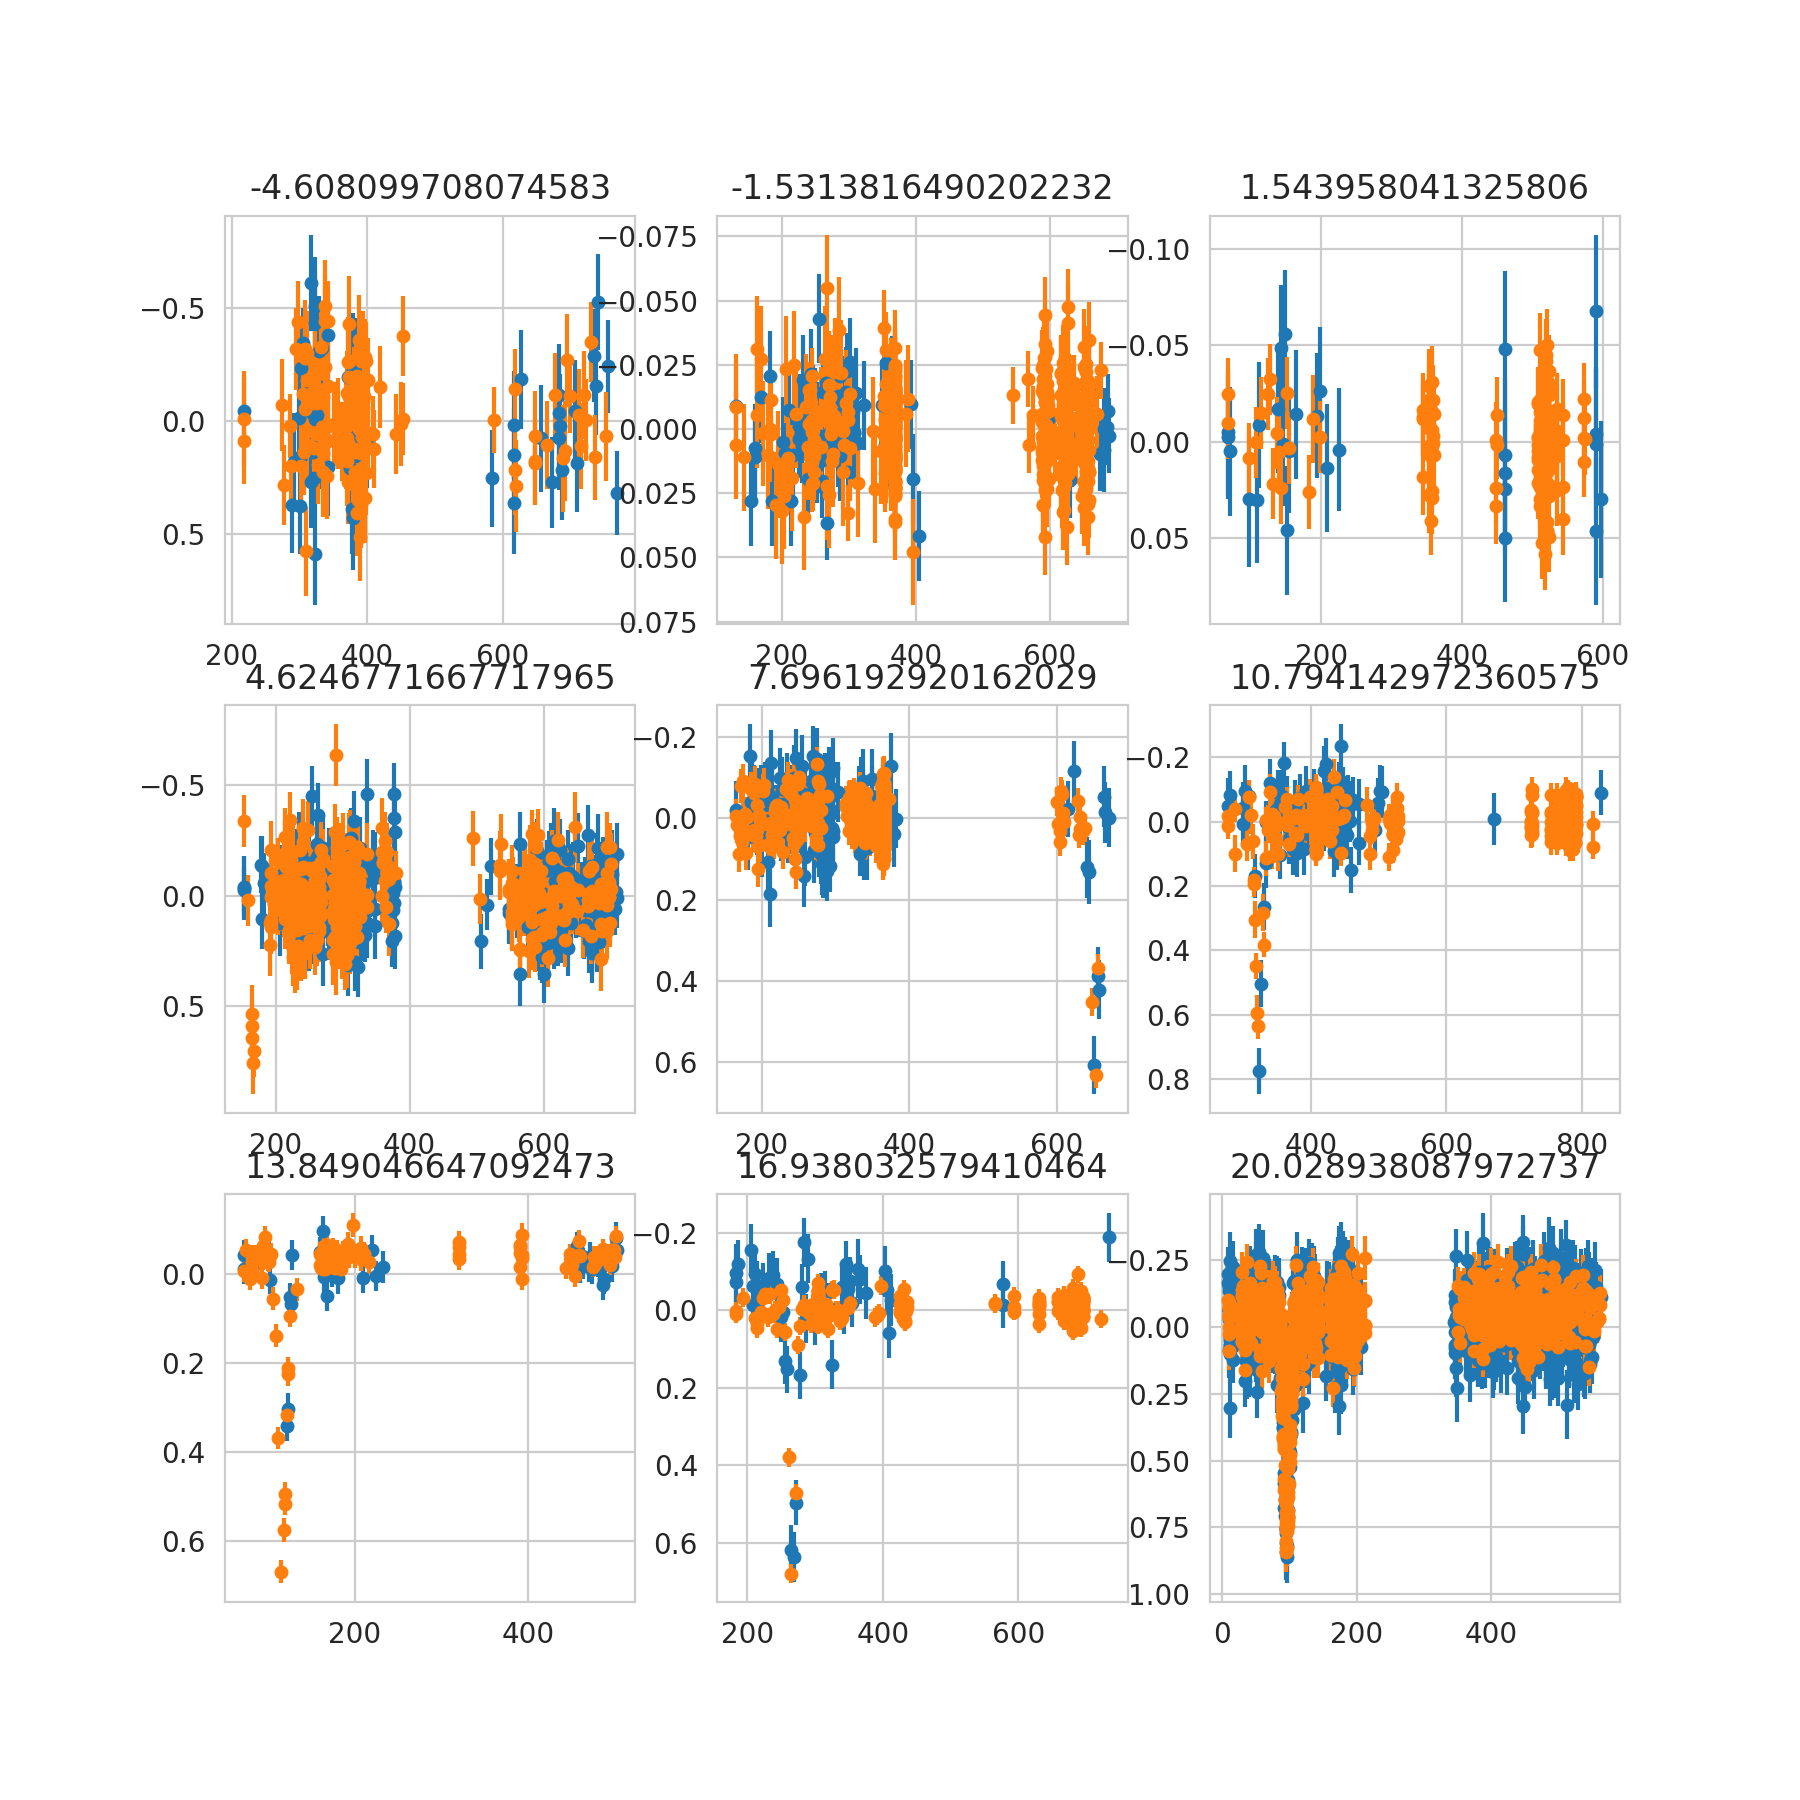

In [51]:
test_scores = np.linspace(np.min(sig_all), 20, 9)

fig, axes = plt.subplots(3, 3, figsize=(9,9))

axes = np.hstack(axes)

sig_all_sorted = np.sort(sig_all)
sig_all_sorted_idx = np.argsort(sig_all)

for i, ts in enumerate(test_scores):
    idx = sig_all_sorted_idx[sig_all_sorted.searchsorted(ts)]
    
    #sig_idx = np.where((sig_all >= ts) & (sig_all <= ts+1))[0]
    #print(sig_idx)
    res = res_all[idx]
    lc_all = lc_sim_all[idx]
    
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux-np.mean(lc.flux), yerr=lc.flux_err, fmt="o", markersize=4)
    
    axes[i].set_ylim(axes[i].get_ylim()[::-1])
    axes[i].set_title(res["significance"])



We are going to look for things with a significance > 15 to start with:

In [52]:
np.sum(sig_all > 15.0)

1096

There are over 1000 out of 10000 dips that we'd find like this, which is not bad, though I'll admit that the dip is very deep:

In [53]:
sig_mask = (sig_all >= 15.0)

In [54]:
sig_idx = np.where(sig_mask == True)[0]

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<IPython.core.display.Javascript object>


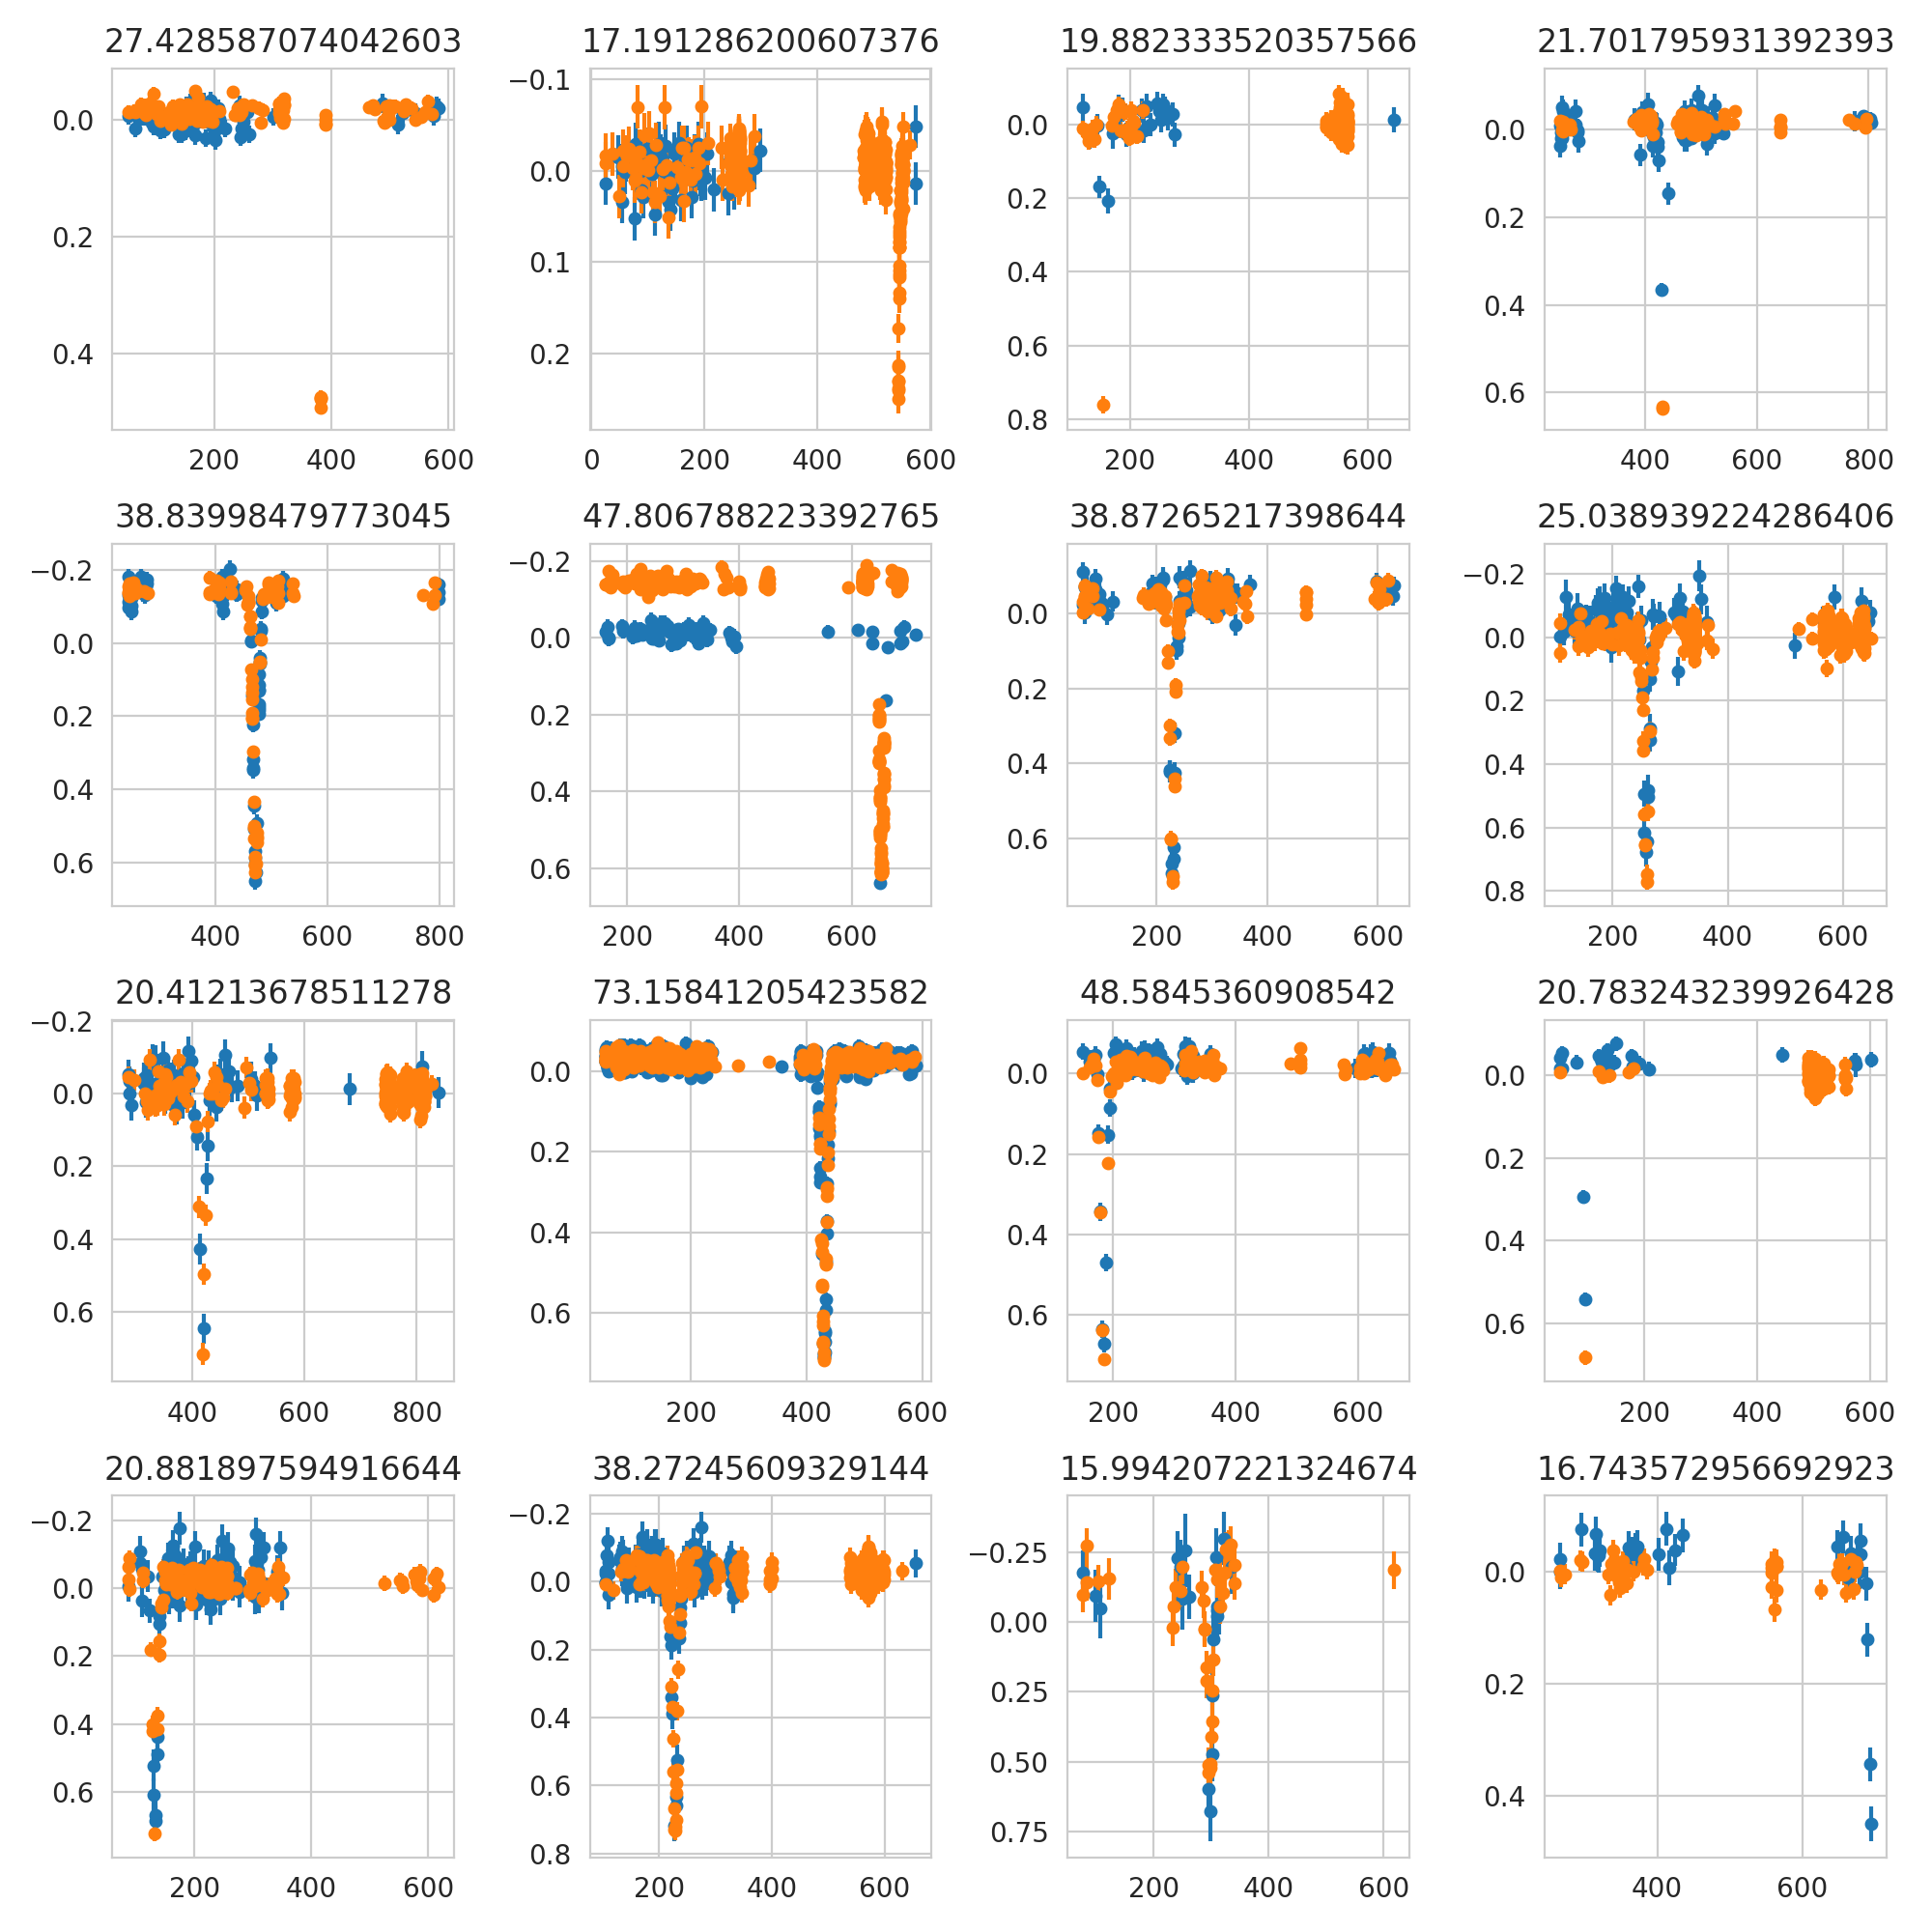

In [55]:
np.random.seed(4000)

idx_test = np.random.choice(sig_idx, replace=False, size=16)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

axes = np.hstack(axes)

for i, idx in enumerate(idx_test):
    res = res_all[idx]
    lc_all = lc_sim_all[idx]
    
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux-np.mean(lc.flux), yerr=lc.flux_err, fmt="o", markersize=4)
    
    axes[i].set_ylim(axes[i].get_ylim()[::-1])
    axes[i].set_title(res["significance"])


plt.tight_layout()


Let's also use Kyle's decision metrics for whether there's a good dip:

        (sparkfunc.col("dip.significant_observation_count") >= 3)
        & (sparkfunc.col("dip.core_not_significant_fraction") <= 0.2)
        & (sparkfunc.col("dip.significant_width") >= 1)
        & (sparkfunc.col("dip.significance") >= 5)
        & (sparkfunc.col("dip.ref_pull_std") < 1.5)
        & (sparkfunc.col("dip.ref_large_pull_fraction") < 0.1)
        & (sparkfunc.col("dip.max_gap_fraction") < 0.8)

First, we're going to make the list of dictionaries with the dip search results into a DataFrame:

In [56]:
res_df = pd.DataFrame(res_all)

In [57]:
res_df.head()

integral  integral_uncertainty  significance   start_mjd  center_mjd  \
0  -2.991380              2.517723     -1.188129  648.229832  661.019459   
1   0.119999              0.183672      0.653332  233.430396  239.450513   
2   0.049907              0.102648      0.486194  268.619425  273.481304   
3  52.781918              5.859772      9.007504  526.101920  629.676930   
4  20.261660             15.580213      1.300474  465.051191  492.026575   

      end_mjd      length  window_start_mjd  window_end_mjd     max_gap  \
0  673.809085   25.579253        646.808763      700.051332         NaN   
1  242.956449    9.526052        232.972118      260.502574    8.929583   
2  283.762239   15.142814        268.443770      283.877744    9.988461   
3  804.099561  277.997641        362.836923      823.479853         NaN   
4  576.440288  111.389097        388.954398      585.819590  143.260463   

   max_gap_fraction  ref_observation_count  ref_pull_std  \
0               NaN                   37.0      0.968307   
1          0.937385                   30.0      0.932474   
2          0.659617                  126.0      0.997915   
3               NaN                   27.0      1.021575   
4          1.286126                  312.0      1.002551   

   ref_large_pull_fraction  dip_observation_count  \
0                      0.0                    0.0   
1                      0.0                    5.0   
2                      0.0                   42.0   
3                      0.0                   16.0   
4                      0.0                    3.0   

   significant_observation_count  core_not_significant_fraction  \
0                            0.0                            1.0   
1                            0.0                            1.0   
2                            0.0                            1.0   
3                           16.0                            0.0   
4                            2.0                            0.0   

   significant_width  
0           0.000000  
1           0.000000  
2           0.000000  
3           9.012581  
4           0.998692

In [58]:
dips = res_df[(res_df["significant_observation_count"] >= 3) &
                     (res_df["core_not_significant_fraction"] <= 0.2) &
                     (res_df["significant_width"] >= 1) &
                     (res_df["significance"] >= 5) &
                     (res_df["ref_pull_std"] < 1.5) &
                     (res_df["ref_large_pull_fraction"] < 0.1) &
                     (res_df["max_gap_fraction"] < 0.8)
                    ]

In [59]:
dips.head()

integral  integral_uncertainty  significance   start_mjd  center_mjd  \
5   8.123569              1.307909      6.211111  468.200778  474.362551   
27  8.666489              0.206926     41.882149  145.006429  153.839214   
33  9.292052              0.818556     11.351759  233.854271  242.279810   
34  8.907683              0.386839     23.026871  364.956571  372.088741   
37  8.380796              0.160287     52.286080  532.035356  539.158422   

       end_mjd     length  window_start_mjd  window_end_mjd   max_gap  \
5   479.733841  11.533063        453.375778      492.472867  8.856516   
27  161.189576  16.183147        129.922642      179.261337  1.942975   
33  274.956958  41.102687        209.011997      277.887922  4.989317   
34  381.152829  16.196258        352.499314      389.096315  2.019502   
37  547.019042  14.983686        511.155986      566.334610  5.047893   

    max_gap_fraction  ref_observation_count  ref_pull_std  \
5           0.767924                   77.0      0.844907   
27          0.120062                  541.0      0.994407   
33          0.121387                  247.0      1.061249   
34          0.124689                  267.0      1.050951   
37          0.336893                   79.0      1.049782   

    ref_large_pull_fraction  dip_observation_count  \
5                  0.000000                    3.0   
27                 0.003697                   26.0   
33                 0.004049                   32.0   
34                 0.007491                   25.0   
37                 0.000000                   13.0   

    significant_observation_count  core_not_significant_fraction  \
5                             3.0                       0.000000   
27                           26.0                       0.000000   
33                            9.0                       0.000000   
34                           22.0                       0.043478   
37                           13.0                       0.000000   

    significant_width  
5            6.043623  
27          15.040058  
33          10.895012  
34          14.074028  
37          12.089757

I want to make a function that does this, for ease of convenience, and so that 
I can easily change things:

In [60]:
def identify_dips(res_df):
    """
    Identify dips in the results based on criteria that Kyle 
    developed.
    
    Parameters
    ----------
    res : pandas.DataFrame
        A DataFrame with the outcomes of dip searches 
        across multiple simulations 
    
    Returns
    -------
    dips : pandas.DataFrame
        A DataFrame with the results
    """
    dips = res_df[(res_df["significant_observation_count"] >= 3) &
                     (res_df["core_not_significant_fraction"] <= 0.2) &
                     (res_df["significant_width"] >= 1) &
                     (res_df["significance"] >= 5) &
                     (res_df["ref_pull_std"] < 1.5) &
                     (res_df["ref_large_pull_fraction"] < 0.1) &
                     (res_df["max_gap_fraction"] < 0.8)
                    ]
    
    return dips

In [61]:
dips = identify_dips(res_df)

In [62]:
dips.head()

integral  integral_uncertainty  significance   start_mjd  center_mjd  \
5   8.123569              1.307909      6.211111  468.200778  474.362551   
27  8.666489              0.206926     41.882149  145.006429  153.839214   
33  9.292052              0.818556     11.351759  233.854271  242.279810   
34  8.907683              0.386839     23.026871  364.956571  372.088741   
37  8.380796              0.160287     52.286080  532.035356  539.158422   

       end_mjd     length  window_start_mjd  window_end_mjd   max_gap  \
5   479.733841  11.533063        453.375778      492.472867  8.856516   
27  161.189576  16.183147        129.922642      179.261337  1.942975   
33  274.956958  41.102687        209.011997      277.887922  4.989317   
34  381.152829  16.196258        352.499314      389.096315  2.019502   
37  547.019042  14.983686        511.155986      566.334610  5.047893   

    max_gap_fraction  ref_observation_count  ref_pull_std  \
5           0.767924                   77.0      0.844907   
27          0.120062                  541.0      0.994407   
33          0.121387                  247.0      1.061249   
34          0.124689                  267.0      1.050951   
37          0.336893                   79.0      1.049782   

    ref_large_pull_fraction  dip_observation_count  \
5                  0.000000                    3.0   
27                 0.003697                   26.0   
33                 0.004049                   32.0   
34                 0.007491                   25.0   
37                 0.000000                   13.0   

    significant_observation_count  core_not_significant_fraction  \
5                             3.0                       0.000000   
27                           26.0                       0.000000   
33                            9.0                       0.000000   
34                           22.0                       0.043478   
37                           13.0                       0.000000   

    significant_width  
5            6.043623  
27          15.040058  
33          10.895012  
34          14.074028  
37          12.089757

Let's take a look at some examples:

In [63]:
len(dips)

1129

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


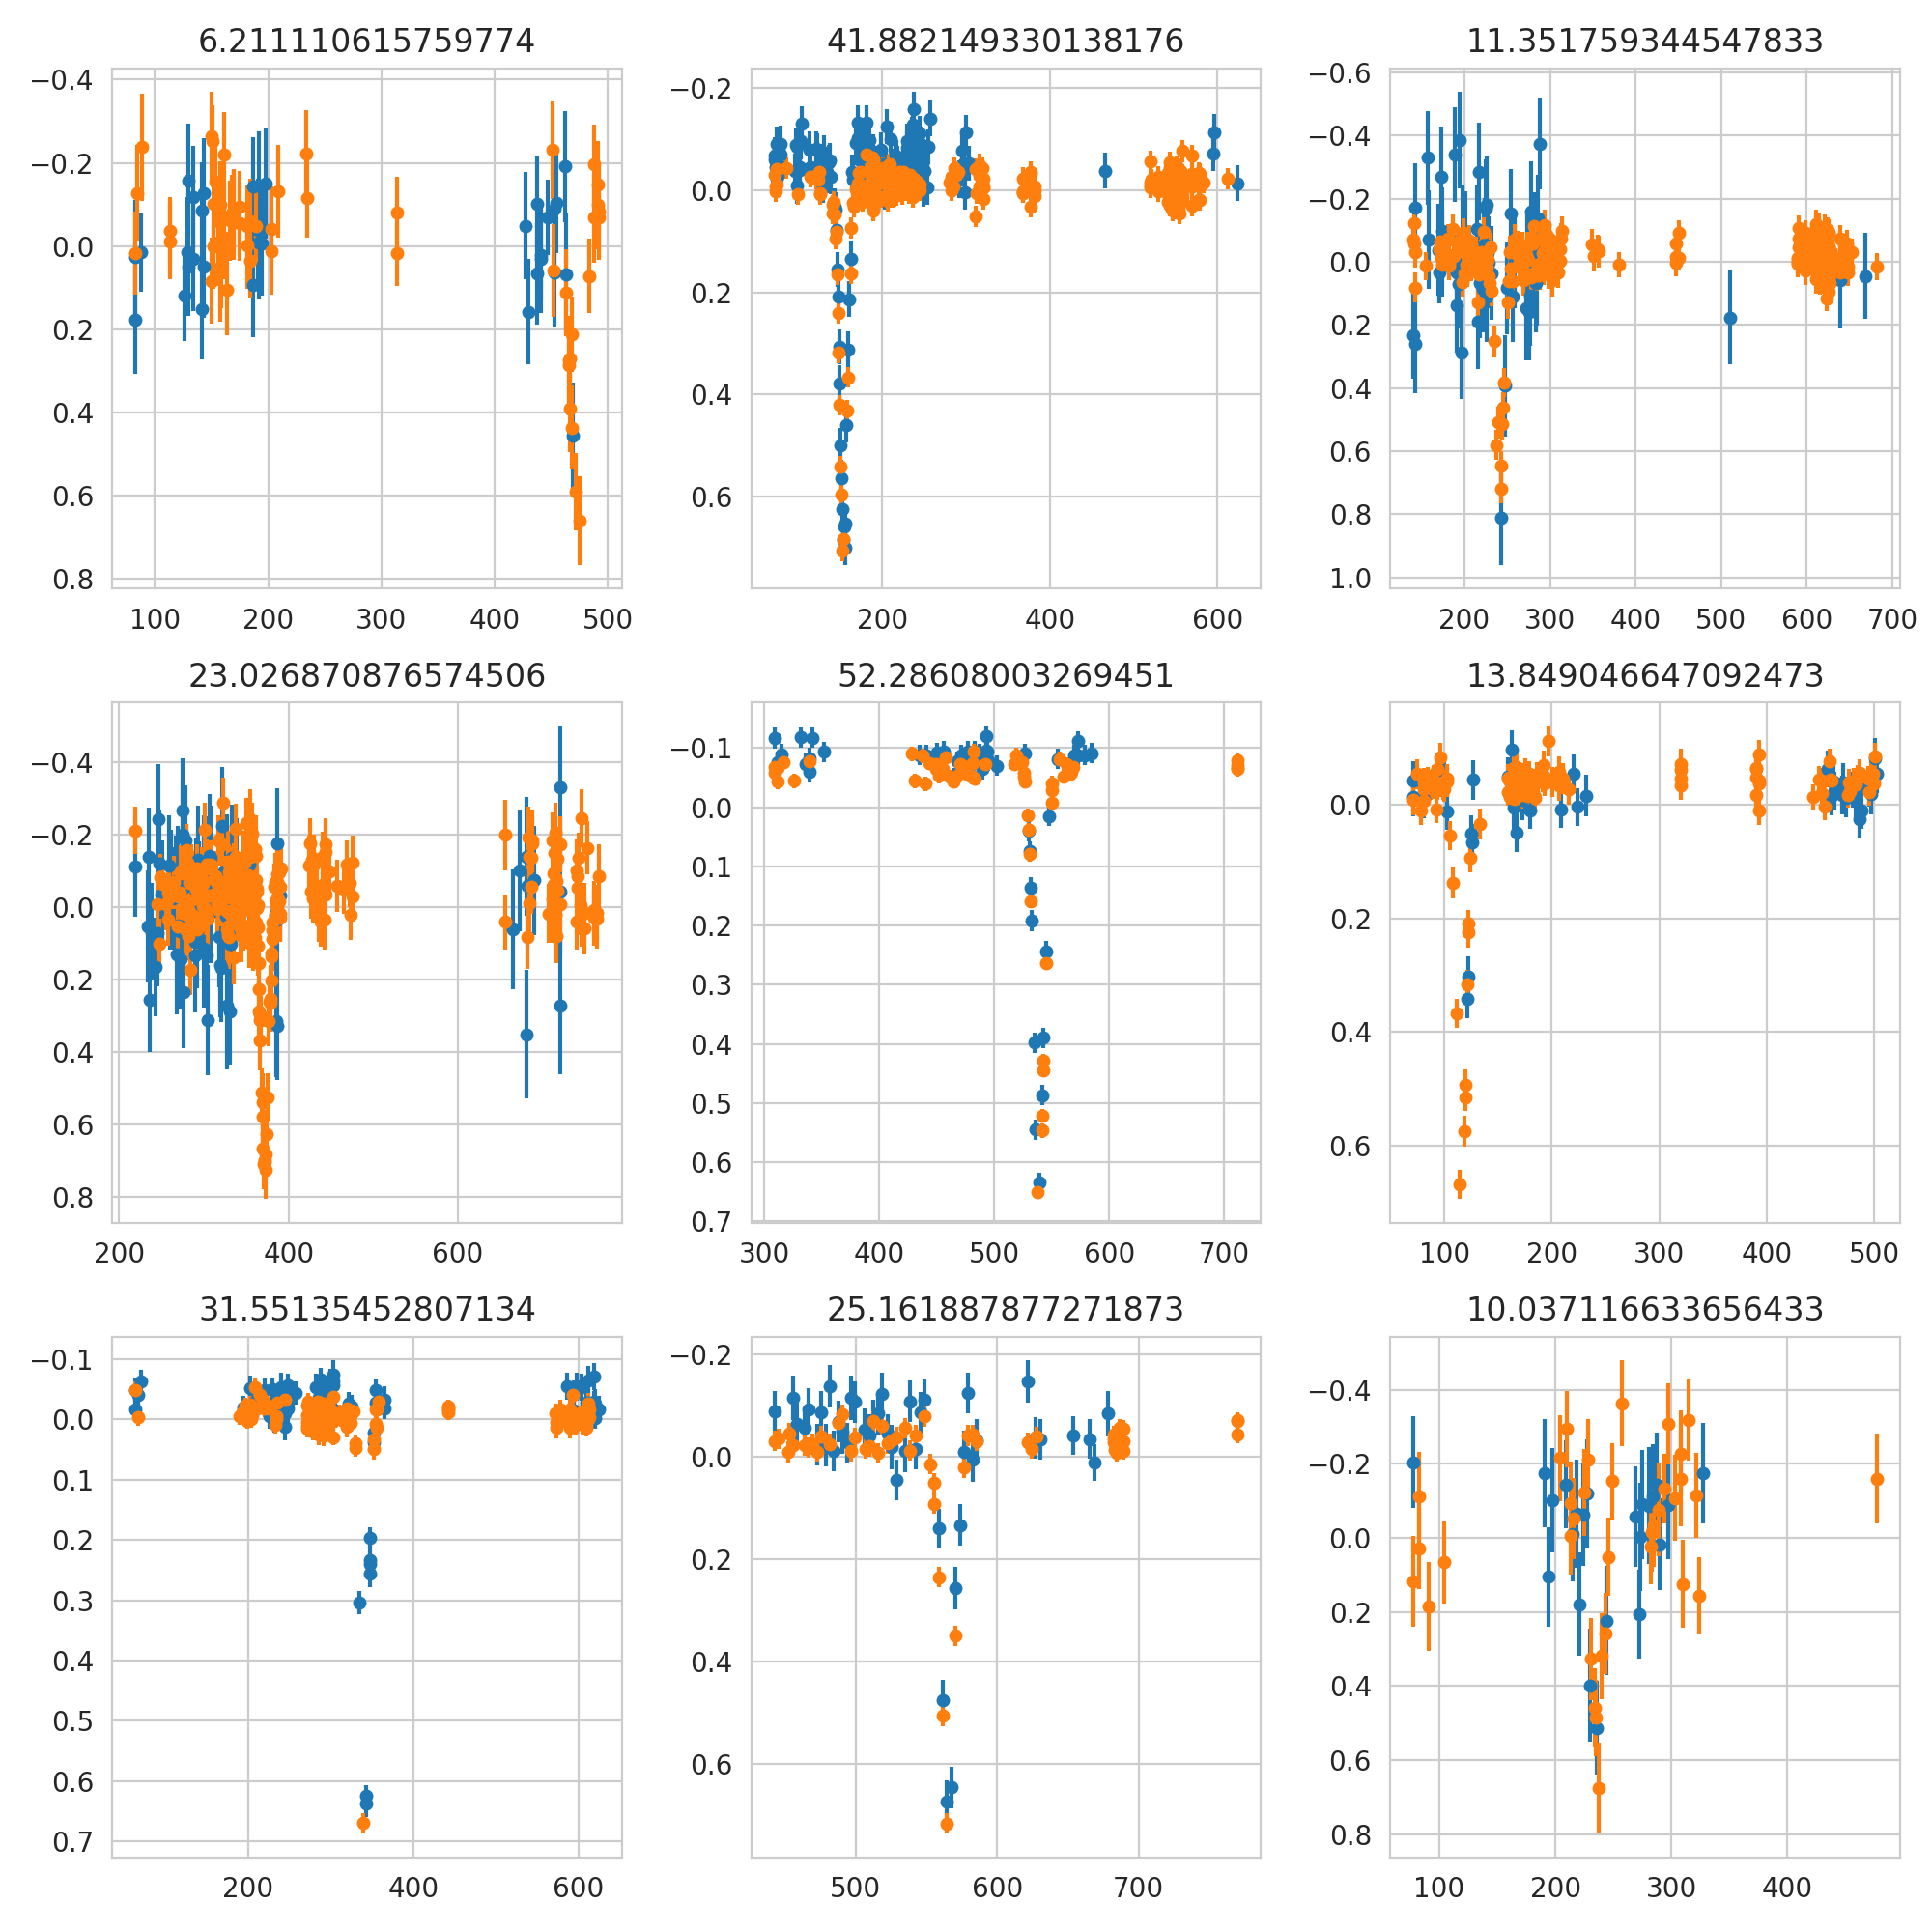

In [64]:
np.random.seed(4000)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

axes = np.hstack(axes)

for i in range(9):
    idx = list(dips.index)[i]
    res = res_all[idx]
    lc_all = lc_sim_all[idx]
    
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux-np.mean(lc.flux), yerr=lc.flux_err, fmt="o", markersize=4)
    
    axes[i].set_ylim(axes[i].get_ylim()[::-1])
    axes[i].set_title(res["significance"])


plt.tight_layout()



## Systematic Search

Now we should look systematically across dip widths and dip lengths, but for that we need some kind of criterion whether there is a dip or not:

In [65]:
def run_simulations(ztf_cadence, nsims, width, depth, tseg=851, coverage=5):
        nztf = len(ztf_cadence)

        #time, flux = simulate_dip_flux(tseg, coverage, width, depth)
        #tseg = time[-1] - time[0]


        lc_sims_all, res_all = [], []
        for k in range(nsims):
            idx = np.random.randint(0, nztf, size=1)

            ztf_lc = get_ztf_lightcurve(ztf_cadence, idx[0])
            max_time = np.max([ztf_lc["tseg_g"], ztf_lc["tseg_r"]])
            min_time = np.min([ztf_lc["zero_g"], ztf_lc["zero_r"]])

            #max_start = tseg - max_time

            tstart = 0.0 # np.random.uniform(0, max_start, size=1)

            c1 = ztf_lc["mjd_g"] - ztf_lc["zero_g"] + tstart
            c2 = ztf_lc["mjd_r"] - ztf_lc["zero_r"] + tstart

            cadences = np.array([c1, c2])
            nbands = 2
            mean_mag = np.array([ztf_lc["meanmag_g"], ztf_lc["meanmag_r"]])
            magerr_g = ztf_lc["magerr_g"]
            magerr_r = ztf_lc["magerr_r"]
            #magerr_g[magerr_g <= 0.0] = np.mean(magerr_g)
            #magerr_r[magerr_r <= 0.0] = np.mean(magerr_r)
            err = np.array([magerr_g, magerr_r])

            lc_all = simulate_lightcurves_from_function(width, depth, tdip="random", tseg=851, nbands=nbands,
                                                        cadence=cadences, err=err, mean_mag=mean_mag)

            lc_sims_all.append(lc_all)

            t_all = [lc.time for lc in lc_all]
            mag_all = [lc.flux for lc in lc_all]
            magerr_all = [lc.flux_err for lc in lc_all]

            res = measure_dip(t_all, mag_all, magerr_all)
            res_all.append(res)


        res_df = pd.DataFrame(res_all)

        dips = identify_dips(res_df)

        return lc_sims_all, res_df, dips


Let's try this:

In [74]:
nsims = 6
w = 5
d = 0.5
coverage = 5

lc_all_width, res_all_width, dips = run_simulations(ztf_cadence, nsims, w, d, 
                                                    tseg=tseg)

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


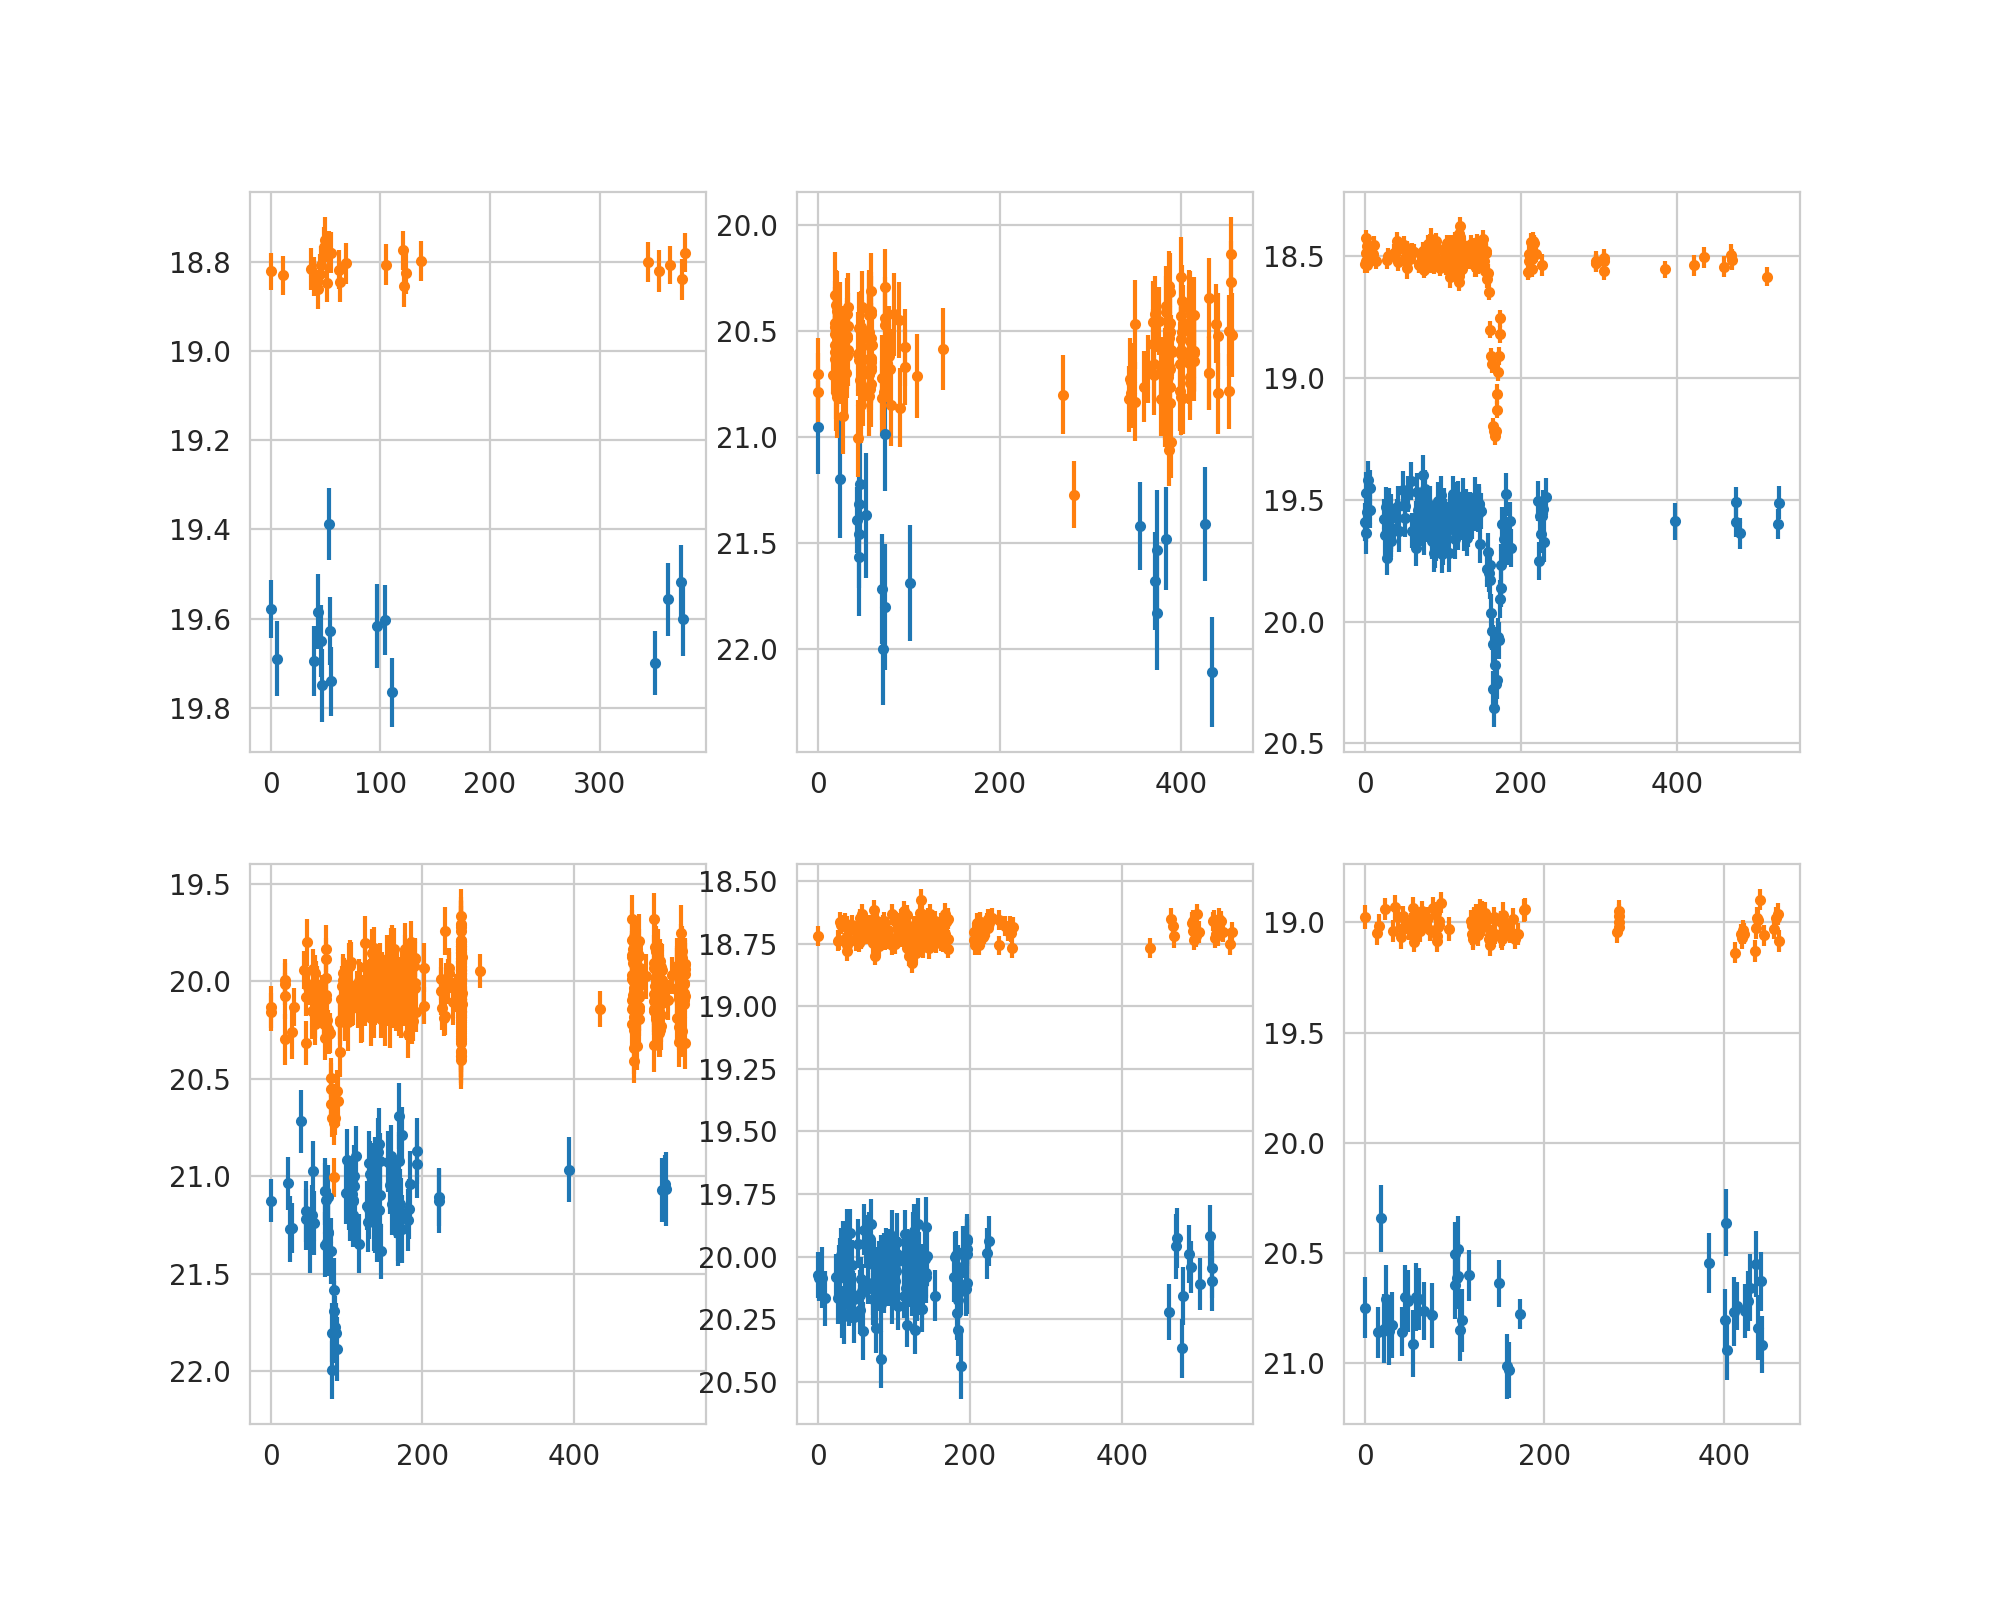

In [76]:
fig, axes = plt.subplots(2, 3, figsize=(10,8))

axes = np.hstack(axes)

for i in range(nsims):
    lc_all = lc_all_width[i]
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=3)
    axes[i].set_ylim(axes[i].get_ylim()[::-1])

That looks good. Now we can run a bunch of simulations:

I also made a script with all these functions, so let's see whether that works:

In [77]:
from simulations import identify_dips, simulate_lightcurves_from_function, run_simulations, simulate_dip_flux, get_ztf_lightcurve

In [90]:
widths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 35, 40, 45, 50]
depths = [0.01, 0.05, 0.1, 0.2, 0.4]
coverage = 5
nsims = 10000

lc_all_sims = []
res_all_sims = []
res_bool_sims = []

dip_fraction = np.zeros((len(depths), len(widths)))

for i, d in enumerate(depths):
    print("i: " + str(i))
    res_all_depth = []
    lc_all_depth = []
    res_bool_depth = []
    for j, w in enumerate(widths):
        #print("j: " + str(j))        
        
        lc_all_width, res_all_width, dips = run_simulations(ztf_cadence, nsims, w, d, 
                                                            tseg=tseg)
        res_bool = pd.DataFrame(np.array([(res_all_width["significant_observation_count"] >= 3),
                        (res_all_width["core_not_significant_fraction"] <= 0.2),
                        (res_all_width["significant_width"] >= 1),
                        (res_all_width["significance"] >= 5),
                        (res_all_width["ref_pull_std"] < 1.5),
                        (res_all_width["ref_large_pull_fraction"] < 0.1),
                        (res_all_width["max_gap_fraction"] < 0.8)]).T,
                        columns = ["significant_observation_count", "core_not_significant_fraction",
                                 "significant_width", "significance", "ref_pull_std", "ref_large_pull_fraction",
                                 "max_gap_fraction"]
                       )



        res_bool_depth.append(res_bool)
        lc_all_depth.append(lc_all_width)
        res_all_depth.append(res_all_width)
        
        dip_fraction[i, j] = len(dips)/len(res_all_width)
        
    res_all_sims.append(res_all_depth)
    lc_all_sims.append(lc_all_depth)
    res_bool_sims.append(res_bool_depth)
        

i: 0
i: 1
i: 2
i: 3
i: 4


/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


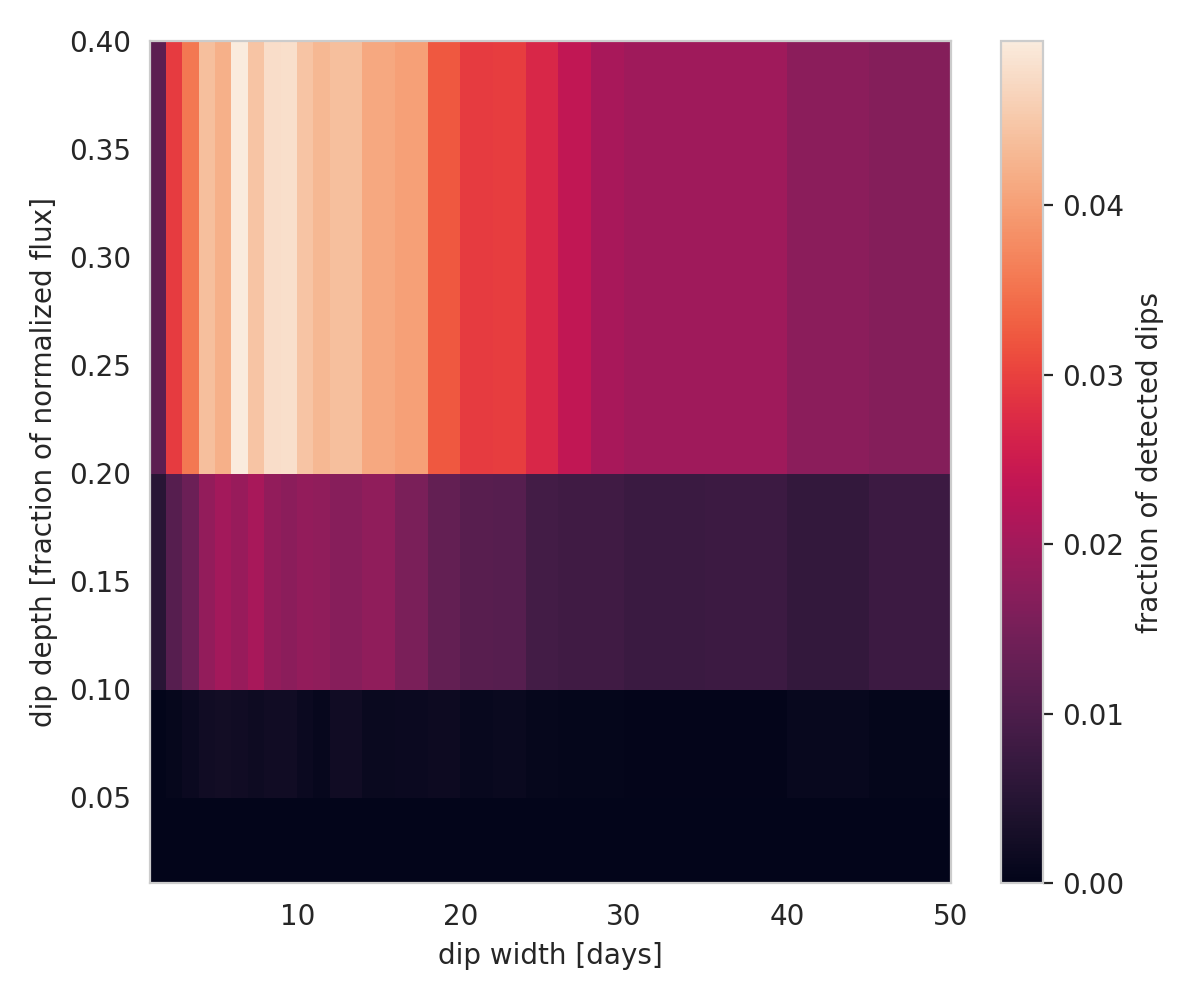

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

im = ax.pcolormesh(widths, depths, dip_fraction)
cbar = fig.colorbar(im)
cbar.set_label('fraction of detected dips')

ax.set_xlabel("dip width [days]")
ax.set_ylabel("dip depth [fraction of normalized flux]")
plt.tight_layout()

It is surprising that we aren't sensitive to longer dips, so I'm going to plot some examples:

In [260]:
widths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 35, 40, 45, 50]
depths = [0.01, 0.05, 0.1, 0.2, 0.4]

In [82]:
res_long = res_all_sims[-1][1]
lc_all_long = lc_all_sims[-1][1]
dips = identify_dips(res_long)

In [83]:
len(dips)

613

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


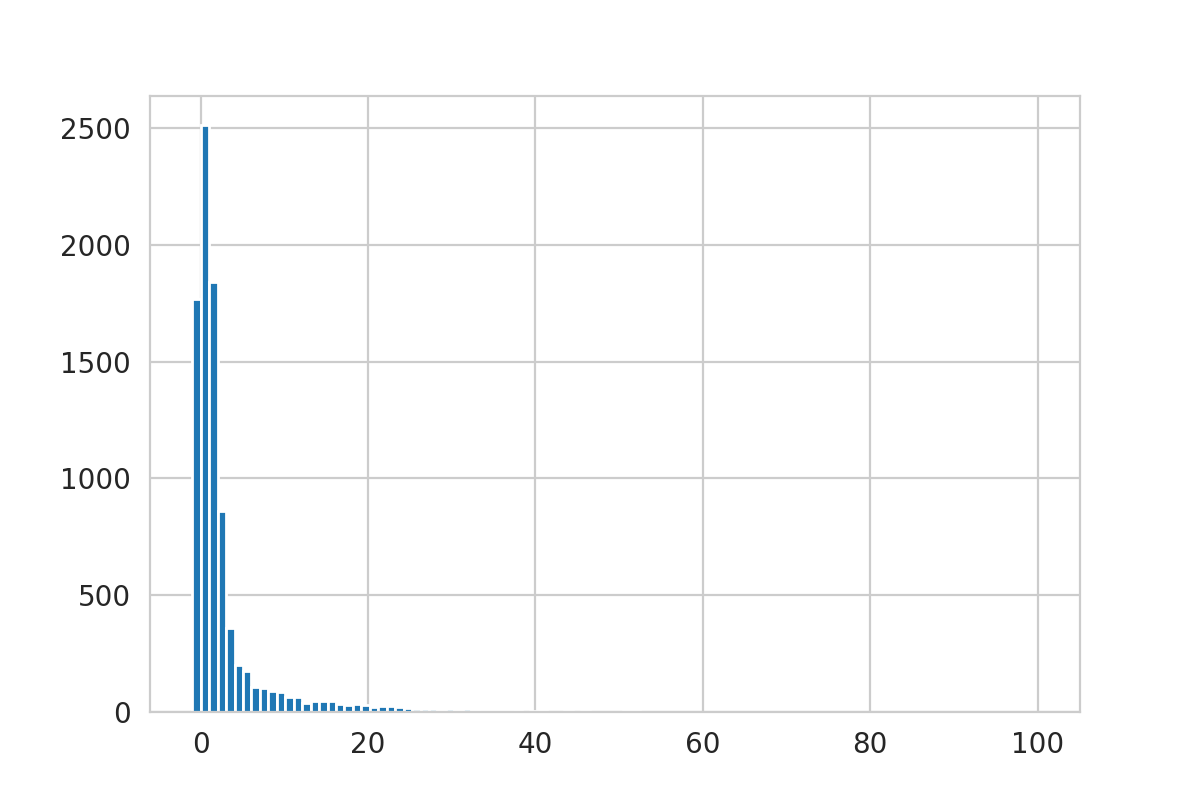

/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [84]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(res_long["significance"], bins=100, range=[-1,100]);

In [85]:
dips

integral  integral_uncertainty  significance   start_mjd  center_mjd  \
18    2.498170              0.072633     34.394219  172.909365  176.180878   
28    2.111634              0.310619      6.798142  132.486342  135.064306   
63    2.290097              0.386976      5.917933   99.664590  103.161803   
72    2.943784              0.411924      7.146428  210.184438  212.548168   
73    2.283410              0.159546     14.311927  126.244760  128.645662   
...        ...                   ...           ...         ...         ...   
9869  2.607624              0.089415     29.163029  191.654328  195.296754   
9877  2.452046              0.155209     15.798348  427.487655  432.728564   
9886  2.960251              0.354214      8.357234  194.538328  197.641121   
9956  2.600775              0.082358     31.579064  488.152477  492.088673   
9964  2.641084              0.076984     34.306828  508.214694  511.293242   

         end_mjd     length  window_start_mjd  window_end_mjd   max_gap  \
18    178.902970   5.993605        166.661502      185.368227  2.960301   
28    136.948141   4.461799        126.162448      143.370458  1.920428   
63    106.096372   6.431782         93.866742      111.846963  2.979977   
72    216.081182   5.896744        203.723340      221.598606  2.976296   
73    132.763097   6.518337        119.018300      139.107800  1.080150   
...          ...        ...               ...             ...       ...   
9869  198.194622   6.540295        185.012442      204.868000  2.036238   
9877  437.599207  10.111552        393.812091      462.838850  5.954815   
9886  200.485001   5.946673        185.967031      209.592214  4.260891   
9956  494.965014   6.812537        479.267067      504.004054  1.917350   
9964  514.821844   6.607149        497.867232      525.346928  2.996424   

      max_gap_fraction  ref_observation_count  ref_pull_std  \
18            0.493910                  173.0      0.986611   
28            0.430416                 1211.0      1.050778   
63            0.463321                  182.0      0.949339   
72            0.504736                  373.0      0.946416   
73            0.165710                  217.0      1.064526   
...                ...                    ...           ...   
9869          0.311337                  332.0      0.947516   
9877          0.588912                 1751.0      0.981968   
9886          0.716517                  523.0      0.950038   
9956          0.281444                  847.0      0.995264   
9964          0.453512                  767.0      0.974050   

      ref_large_pull_fraction  dip_observation_count  \
18                   0.000000                    5.0   
28                   0.004129                    8.0   
63                   0.000000                    4.0   
72                   0.000000                    4.0   
73                   0.004608                   11.0   
...                       ...                    ...   
9869                 0.006024                    8.0   
9877                 0.002856                   10.0   
9886                 0.001912                   13.0   
9956                 0.002361                   24.0   
9964                 0.003911                   12.0   

      significant_observation_count  core_not_significant_fraction  \
18                              5.0                            0.0   
28                              7.0                            0.0   
63                              3.0                            0.0   
72                              4.0                            0.0   
73                             10.0                            0.0   
...                             ...                            ...   
9869                            8.0                            0.0   
9877                           10.0                            0.0   
9886                           13.0                            0.0   
9956                           24.0   

In [86]:
lc_all_dip = lc_all_long[dips.index[0]]
lc_all_nodip = lc_all_long[res_long[res_long["significance"] > 10].index[10]]

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


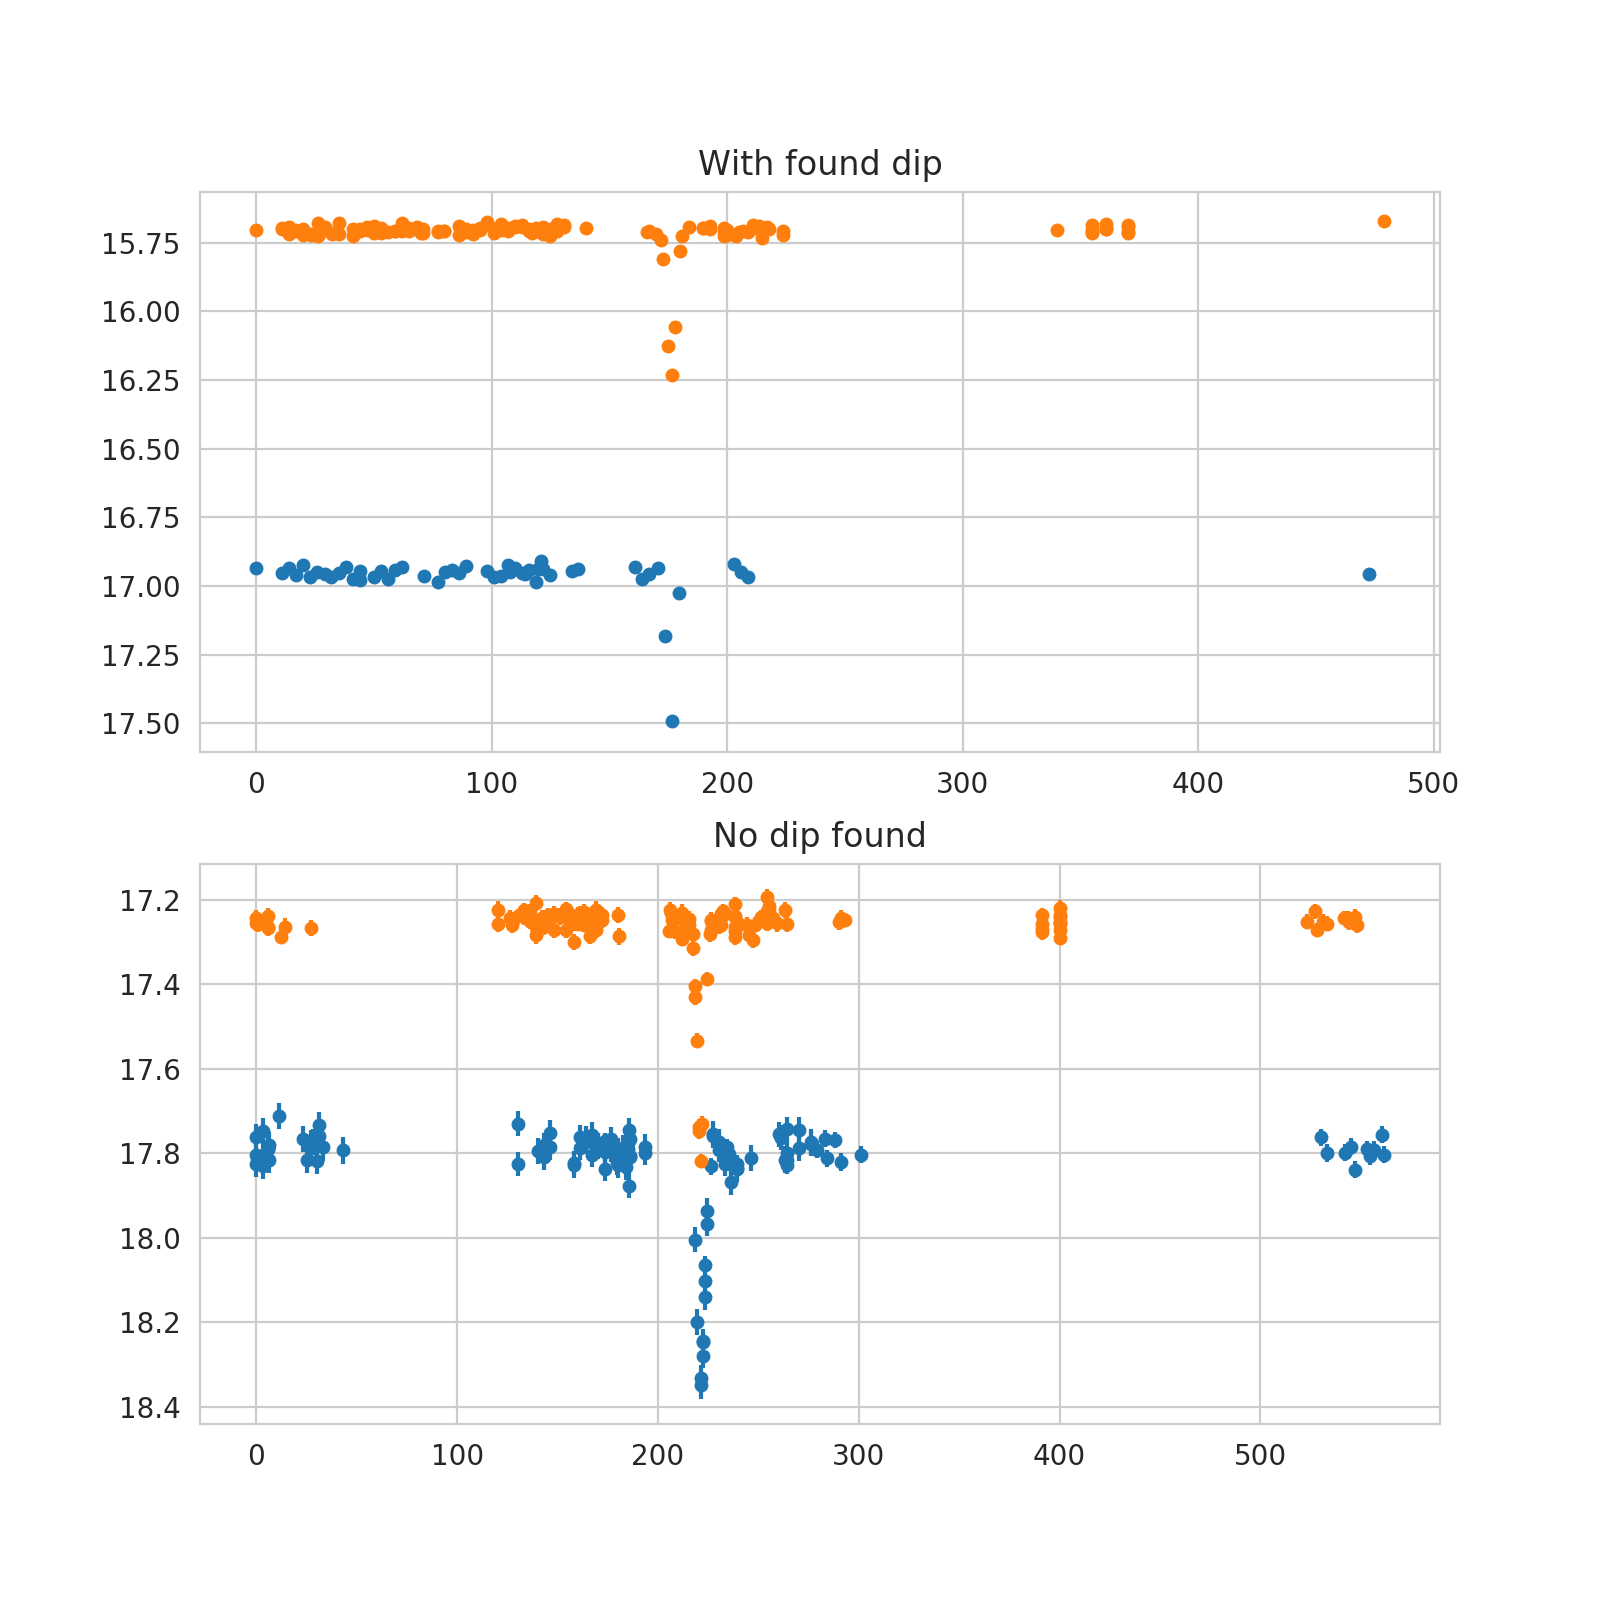

Text(0.5, 1.0, 'No dip found')

In [87]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

for lcd, lcn in zip(lc_all_dip, lc_all_nodip):
    ax1.errorbar(lcd.time, lcd.flux, yerr=lcd.flux_err, fmt="o", markersize=4)
    ax2.errorbar(lcn.time, lcn.flux, yerr=lcn.flux_err, fmt="o", markersize=4)
    
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.set_ylim(ax2.get_ylim()[::-1])

ax1.set_title("With found dip")
ax2.set_title("No dip found")

In [89]:
for idx in res_long[res_long["significance"] > 10].index:
    lc_all = lc_all_long[idx]
    t_all = [lc.time for lc in lc_all]
    mag_all = [lc.flux for lc in lc_all]
    magerr_all = [lc.flux_err for lc in lc_all]

    res = measure_dip(t_all, mag_all, magerr_all)
    if res["significant_observation_count"] < 3:
        print("simulation %i"%idx)
        print("significant observation count: %.2f (should be >= 3 )"%res["significant_observation_count"])
    if res["core_not_significant_fraction"]  > 0.2:
        print("simulation %i"%idx)
        print("core_not_significant_fraction: %.2f (should be <= 0.2)"%res["core_not_significant_fraction"])
    if res["significant_width"] < 1:
        print("simulation %i"%idx)
        print("significant_width: %.2f (should be >= 1)"%res["significant_width"])
    if res["significance"] < 5:
        print("simulation %i"%idx)
        print("significance: %.2f (should be >= 5)"%res["significance"])
    if res["ref_pull_std"] >= 1.5:
        print("simulation %i"%idx)
        print("ref_pull_std: %.2f (should be < 1.5)"%res["ref_pull_std"])
    if res["ref_large_pull_fraction"] >= 0.1:
        print("simulation %i"%idx)
        print("ref_large_pull_fraction: %.4f (should be < 0.1)"%res["ref_large_pull_fraction"])
    if res["max_gap_fraction"] >= 0.8: 
        print("simulation %i"%idx)
        print("max_gap_fraction: %.2f (should be < 0.8)"%res["max_gap_fraction"])
    print()


simulation 22
significant observation count: 1.00 (should be >= 3 )
simulation 22
significant_width: 0.00 (should be >= 1)
simulation 22
max_gap_fraction: 2.14 (should be < 0.8)

simulation 51
max_gap_fraction: 0.86 (should be < 0.8)





simulation 108
max_gap_fraction: 1.03 (should be < 0.8)







simulation 182
significant observation count: 2.00 (should be >= 3 )

simulation 194
max_gap_fraction: 5.99 (should be < 0.8)

simulation 226
significant observation count: 2.00 (should be >= 3 )
simulation 226
max_gap_fraction: 1.54 (should be < 0.8)

simulation 227
significant_width: 0.01 (should be >= 1)
simulation 227
max_gap_fraction: 1.70 (should be < 0.8)


simulation 257
max_gap_fraction: 0.93 (should be < 0.8)

simulation 264
max_gap_fraction: 2.24 (should be < 0.8)




simulation 313
max_gap_fraction: 1.44 (should be < 0.8)



simulation 364
significant observation count: 1.00 (should be >= 3 )
simulation 364
significant_width: 0.00 (should be >= 1)



simulation 390
max_gap_fra


simulation 2350
significant observation count: 2.00 (should be >= 3 )


simulation 2378
max_gap_fraction: 1.05 (should be < 0.8)

simulation 2379
max_gap_fraction: 1.06 (should be < 0.8)

simulation 2380
significant observation count: 2.00 (should be >= 3 )

simulation 2394
significant observation count: 2.00 (should be >= 3 )
simulation 2394
max_gap_fraction: 1.31 (should be < 0.8)

simulation 2438
significant observation count: 2.00 (should be >= 3 )

simulation 2454
significant observation count: 2.00 (should be >= 3 )
simulation 2454
max_gap_fraction: 1.19 (should be < 0.8)


simulation 2467
max_gap_fraction: 2.77 (should be < 0.8)

simulation 2474
significant observation count: 1.00 (should be >= 3 )
simulation 2474
significant_width: 0.00 (should be >= 1)




simulation 2499
max_gap_fraction: 0.98 (should be < 0.8)



simulation 2524
significant observation count: 1.00 (should be >= 3 )
simulation 2524
significant_width: 0.00 (should be >= 1)
simulation 2524
max_gap_fraction: 1.

simulation 5584
max_gap_fraction: 1.06 (should be < 0.8)


simulation 5604
max_gap_fraction: 0.95 (should be < 0.8)





simulation 5667
significant observation count: 2.00 (should be >= 3 )

simulation 5685
max_gap_fraction: 1.74 (should be < 0.8)


simulation 5695
max_gap_fraction: 1.15 (should be < 0.8)


simulation 5729
significant observation count: 2.00 (should be >= 3 )
simulation 5729
max_gap_fraction: 1.11 (should be < 0.8)

simulation 5744
max_gap_fraction: 2.25 (should be < 0.8)



simulation 5776
significant observation count: 2.00 (should be >= 3 )
simulation 5776
max_gap_fraction: 2.75 (should be < 0.8)


simulation 5791
significant observation count: 2.00 (should be >= 3 )
simulation 5791
max_gap_fraction: 0.87 (should be < 0.8)


simulation 5803
significant observation count: 2.00 (should be >= 3 )
simulation 5803
significant_width: 0.17 (should be >= 1)
simulation 5803
max_gap_fraction: 0.96 (should be < 0.8)



simulation 5887
max_gap_fraction: 2.56 (should be < 0.8)


simulation 8928
significant observation count: 2.00 (should be >= 3 )
simulation 8928
max_gap_fraction: 2.70 (should be < 0.8)



simulation 8962
max_gap_fraction: 0.91 (should be < 0.8)



simulation 9003
significant observation count: 2.00 (should be >= 3 )


simulation 9012
significant observation count: 1.00 (should be >= 3 )
simulation 9012
significant_width: 0.00 (should be >= 1)
simulation 9012
max_gap_fraction: 1.85 (should be < 0.8)

simulation 9034
max_gap_fraction: 1.70 (should be < 0.8)

simulation 9065
significant observation count: 2.00 (should be >= 3 )



simulation 9097
significant observation count: 1.00 (should be >= 3 )
simulation 9097
significant_width: 0.00 (should be >= 1)
simulation 9097
max_gap_fraction: 1.97 (should be < 0.8)


simulation 9105
max_gap_fraction: 1.10 (should be < 0.8)

simulation 9145
significant observation count: 2.00 (should be >= 3 )
simulation 9145
max_gap_fraction: 1.15 (should be < 0.8)




simulation 9222
significant observation count: 

TO DO:

Right now:
* Make the length of the light curve the lifetime of ZTF (done) (DONE)
* throw out observations that have zero or negative errors (DONE)
* Evaluate dip function directly for cadence, rather than make a finely sampled light curve first. (DONE)
* make function that makes a table of boolean flags so I can explore which criteria fail for which simulations? (DONE)

Once I've got new info/code from Kyle:
* Get cadences directly from AXS table/spark (Kyle will make notebook) (TODO)
* simulate widths much more finely (up to 50 days), keep depth the same  (DONE)
* Make recovery plot on a log-axis to look at 1-day, 2-day axis to see what we can say about short dips (DONE)
* look at examples from all four corners of the plot above, figure out whether are surprising ways in which this fails?
* Check short/deep dips: why is the efficiency 3%? Do those fail in other ways than the cadence missing the dip at all? (DONE)
* How does the algorithm perform on very short timescales? E.g. a day? (DONE)

* diagnostic plot: recovery fraction as a function of apparent magnitude?
* test on fine linear spacing to make sure nothing weird is happening!

Let's look at the recovery fraction as a function of width of the dip:

In [ ]:
widths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 35, 40, 45, 50]
depths = [0.01, 0.05, 0.1, 0.2, 0.4]



In [92]:
len(widths)

25

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


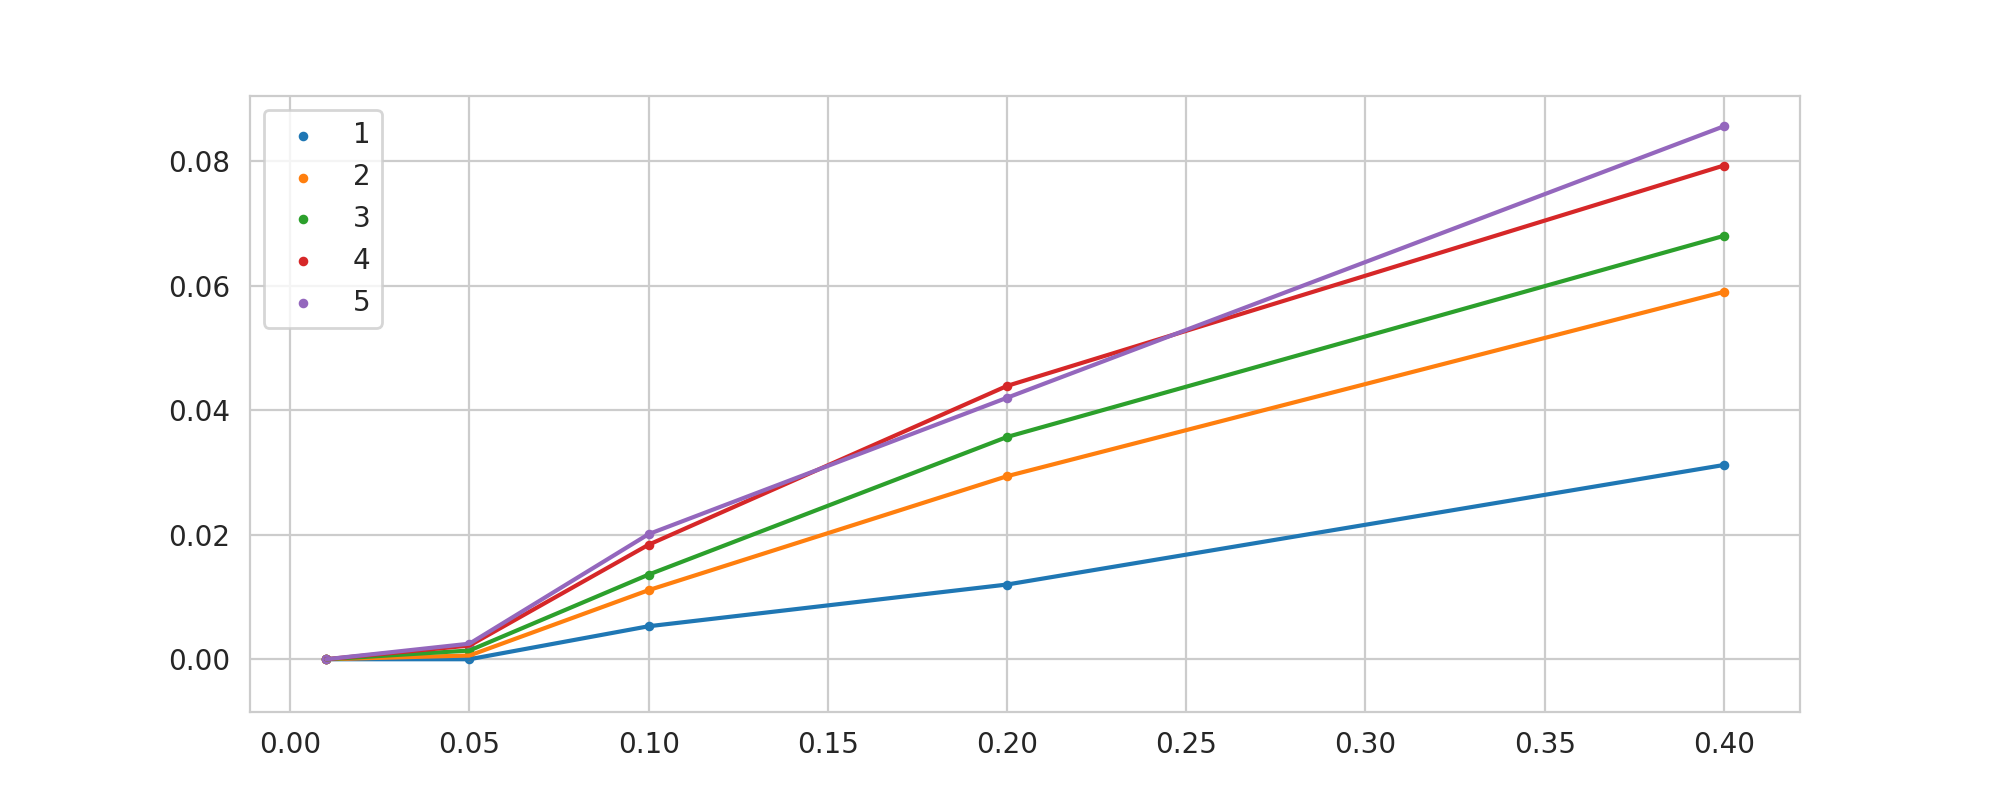

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i, w in enumerate(widths[:5]):
    frac = dip_fraction[:,i]
    ax.scatter(depths, frac, marker="o", s=6, label=w)
    ax.plot(depths, frac)
    
plt.legend()



Let's look at the 0.4 dips as a function of widths instead:

In [103]:
dip_fraction.shape

(5, 25)

In [106]:
dip_fraction[-1, :]

array([0.0312, 0.059 , 0.068 , 0.0793, 0.0856, 0.0881, 0.0915, 0.0959,
       0.0934, 0.0871, 0.0912, 0.0945, 0.0835, 0.0725, 0.0689, 0.0598,
       0.0579, 0.0498, 0.04  , 0.0375, 0.0387, 0.0364, 0.0334, 0.0353,
       0.0312])

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


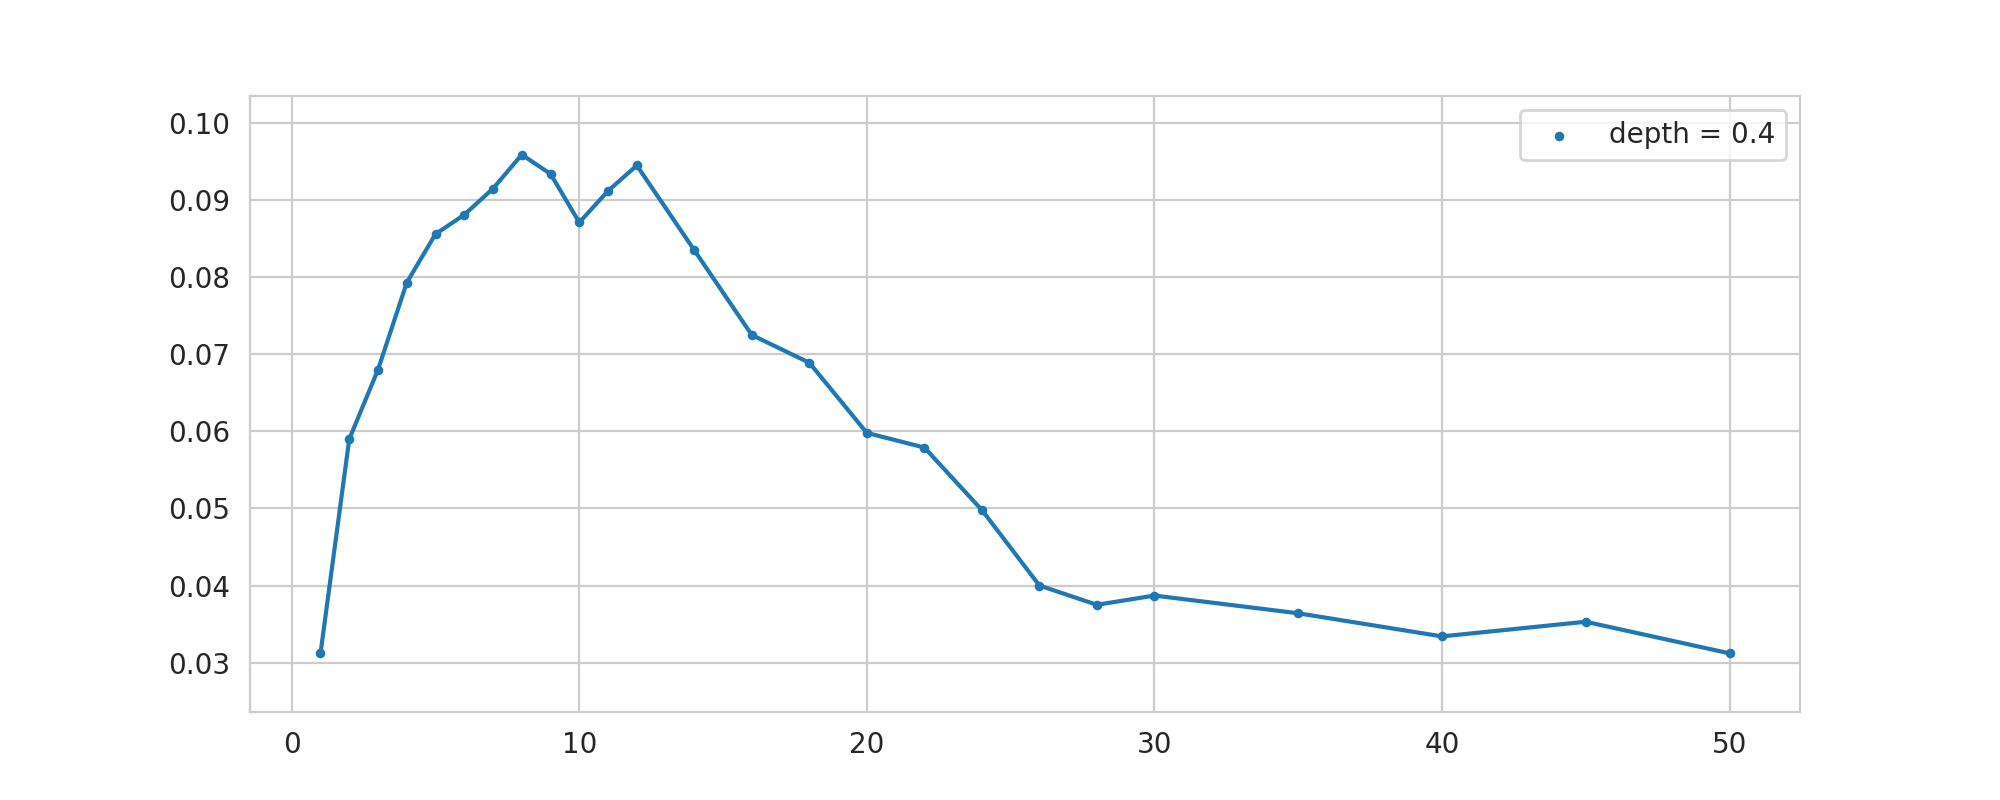

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

frac = dip_fraction[-1,:]
ax.scatter(widths, frac, marker="o", s=6, label="depth = 0.4")
ax.plot(widths, frac)

plt.legend()




Let's look at the data for an 8-day dip of a depth of 40% of the total flux. This is found in abou 10% of the light curves:

In [198]:
res_all = res_all_sims[-1][7]
lc_all = lc_all_sims[-1][7]
res_bool = res_bool_sims[-1][7]
print(dip_fraction[-1,7])

0.0959


In [199]:
len(res_bool.columns)

7

In [200]:
dips = res_all[res_bool.sum(axis=1) == 7]

In [201]:
nodips = res_all[~(res_bool.sum(axis=1) == 7)]

In [202]:
len(nodips)

9041

Of the examples without confirmed dips, how many have a large significance?

In [203]:
len(nodips[nodips["significance"] >= 5])

1090

In [204]:
sig_nodips = nodips[nodips["significance"] >= 20]
print(len(sig_nodips))

163


What are the distributions of parameters for these examples?

In [205]:
len(nodips.columns)

18

In [206]:
len(res_bool.columns)

7

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


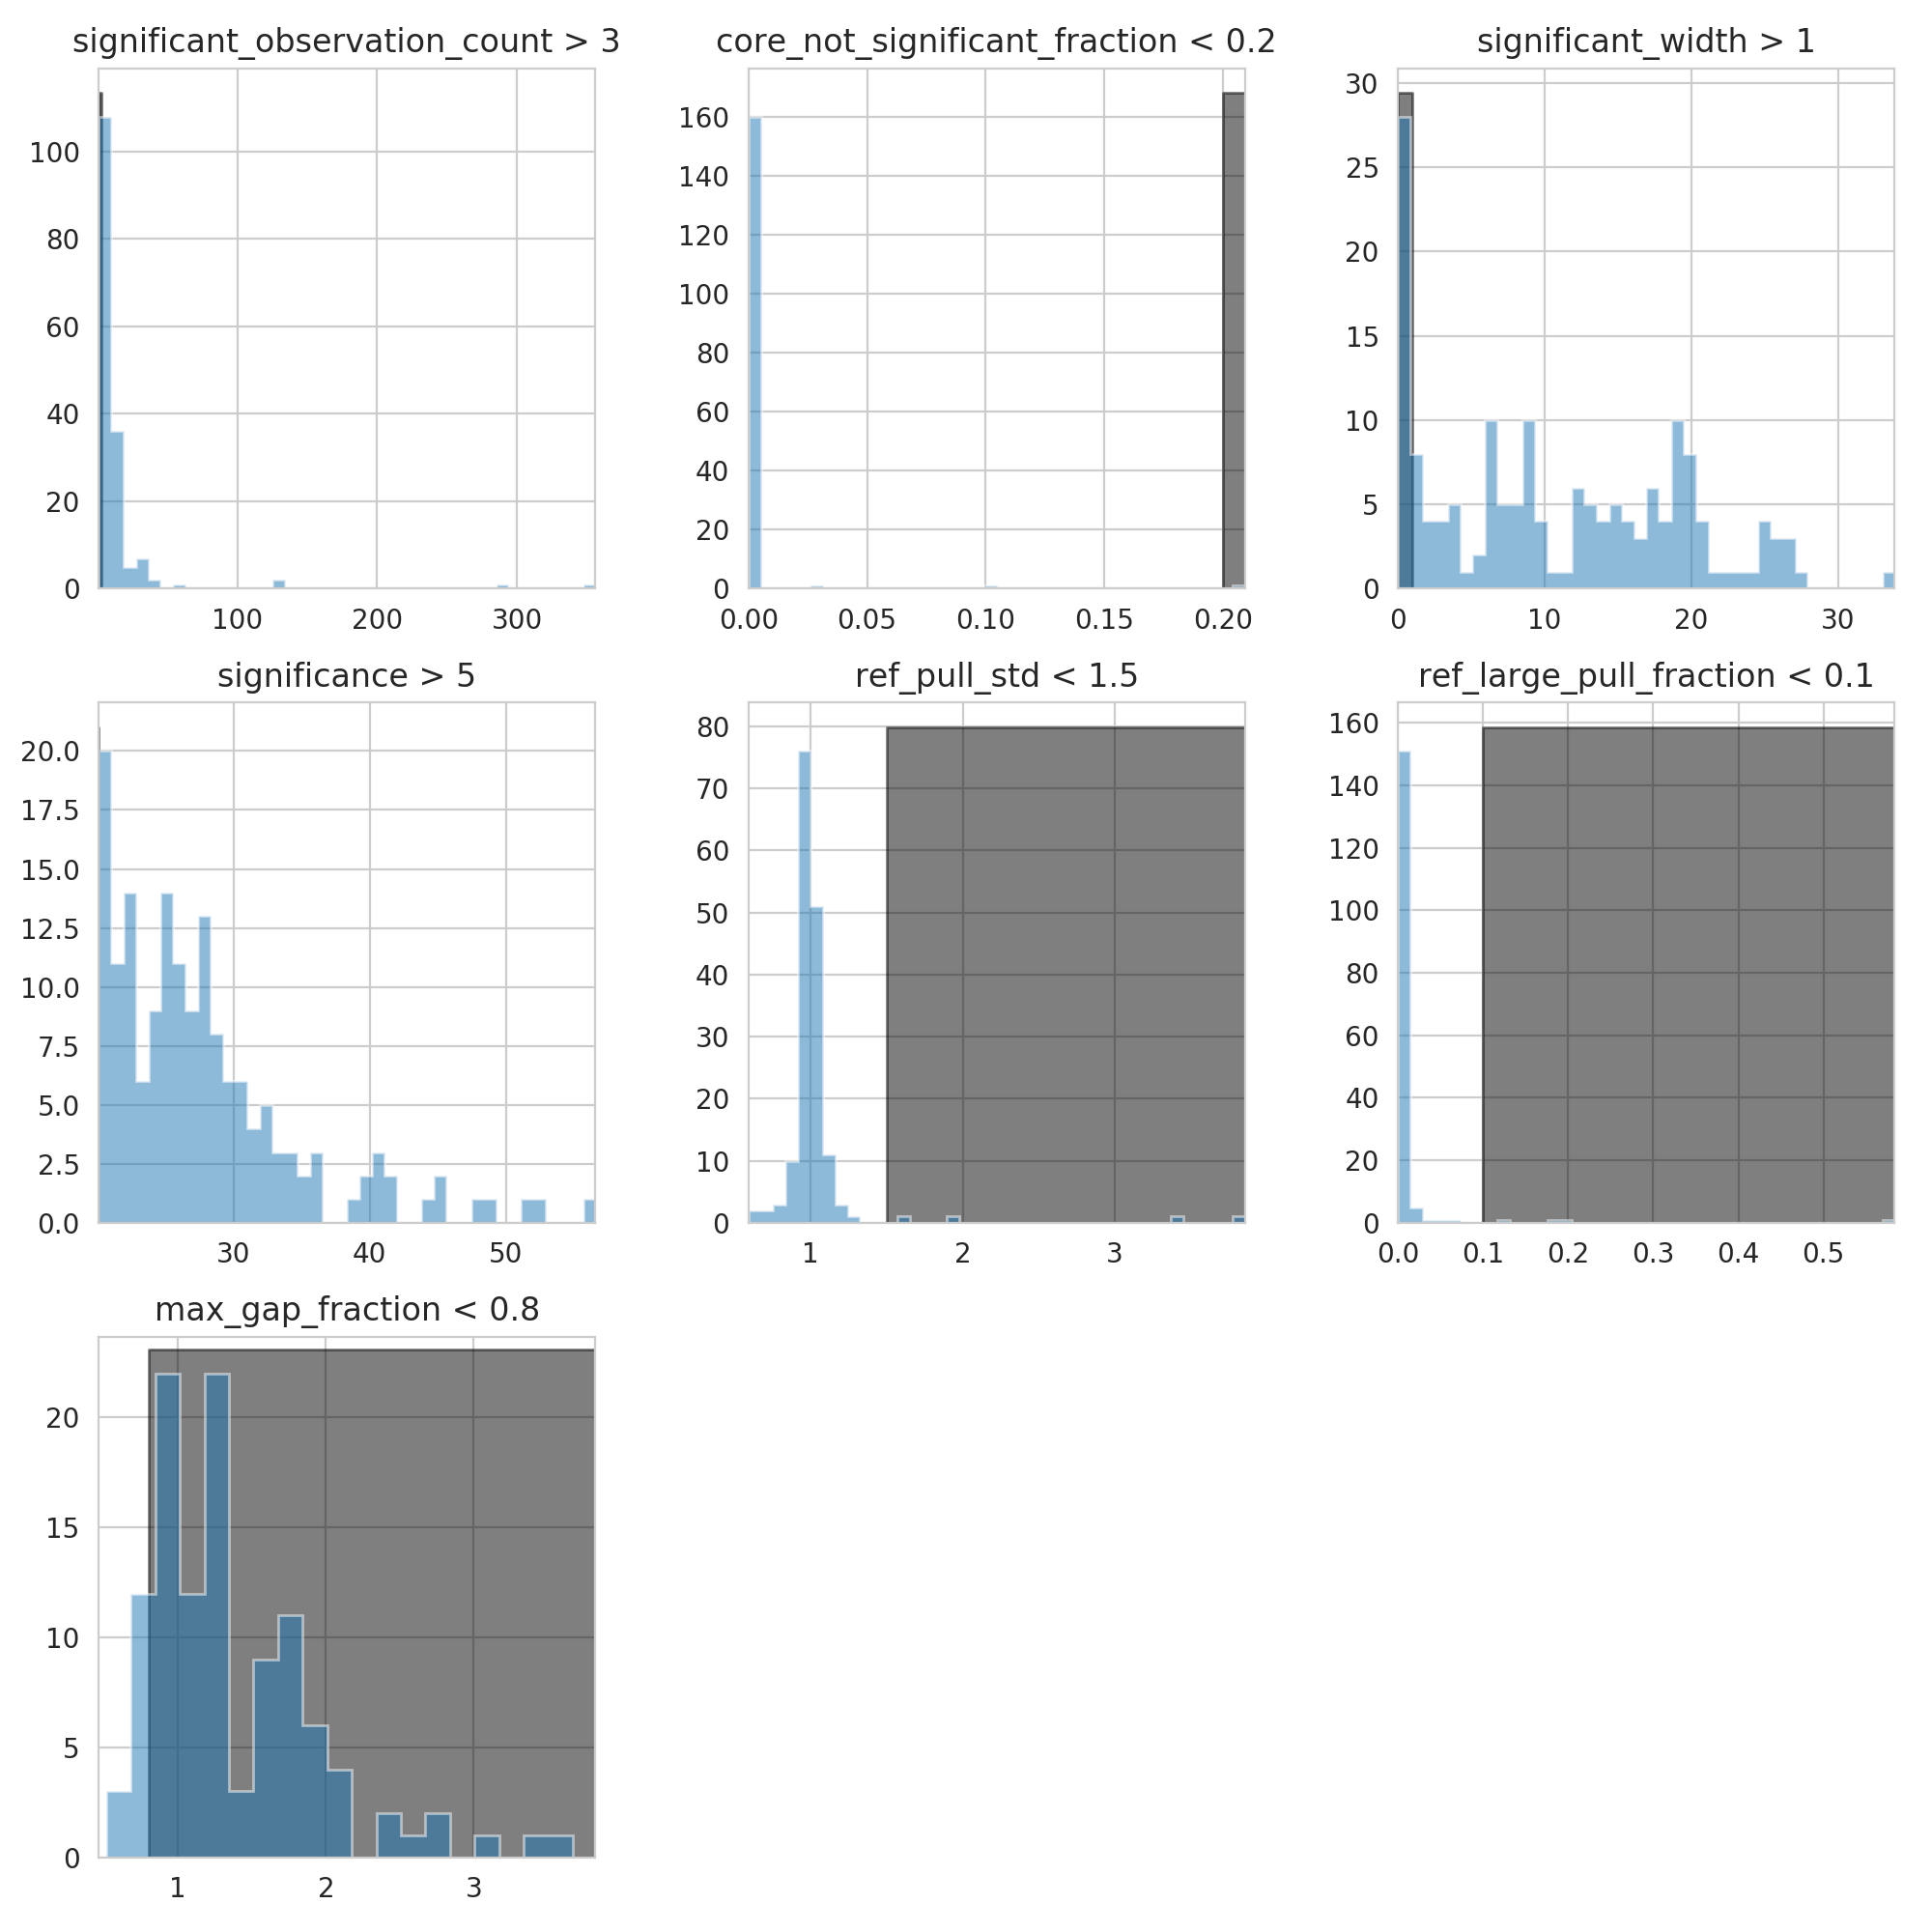

/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [207]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

axes = np.hstack(axes)

for i,c in enumerate(res_bool.columns):
    axes[i].hist(sig_nodips[c], bins=40, histtype="stepfilled", alpha=0.5)
    if limit_direction[i] == "gt":
        axes[i].fill_between([np.min(sig_nodips[c]), limits[i]], 
                             [axes[i].get_ylim()[1], axes[i].get_ylim()[1]], color="black", alpha=0.5)
        axes[i].set_title(c + " > " + str(limits[i]))
 

    else:
        axes[i].fill_between([limits[i], np.max(sig_nodips[c])], 
                             [axes[i].get_ylim()[1], axes[i].get_ylim()[1]], color="black", alpha=0.5)
        axes[i].set_title(c + " < " + str(limits[i]))


        
    axes[i].set_xlim(np.min(sig_nodips[c]), np.max(sig_nodips[c]))



axes[-2].set_visible(False)
axes[-1].set_visible(False)
plt.tight_layout()

Let's plot some examples from that category:

In [144]:
nodip_idx = np.array(nodips.index)

core_not_significant_fraction    False
significance                     False
max_gap_fraction                 False
Name: 13, dtype: bool

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


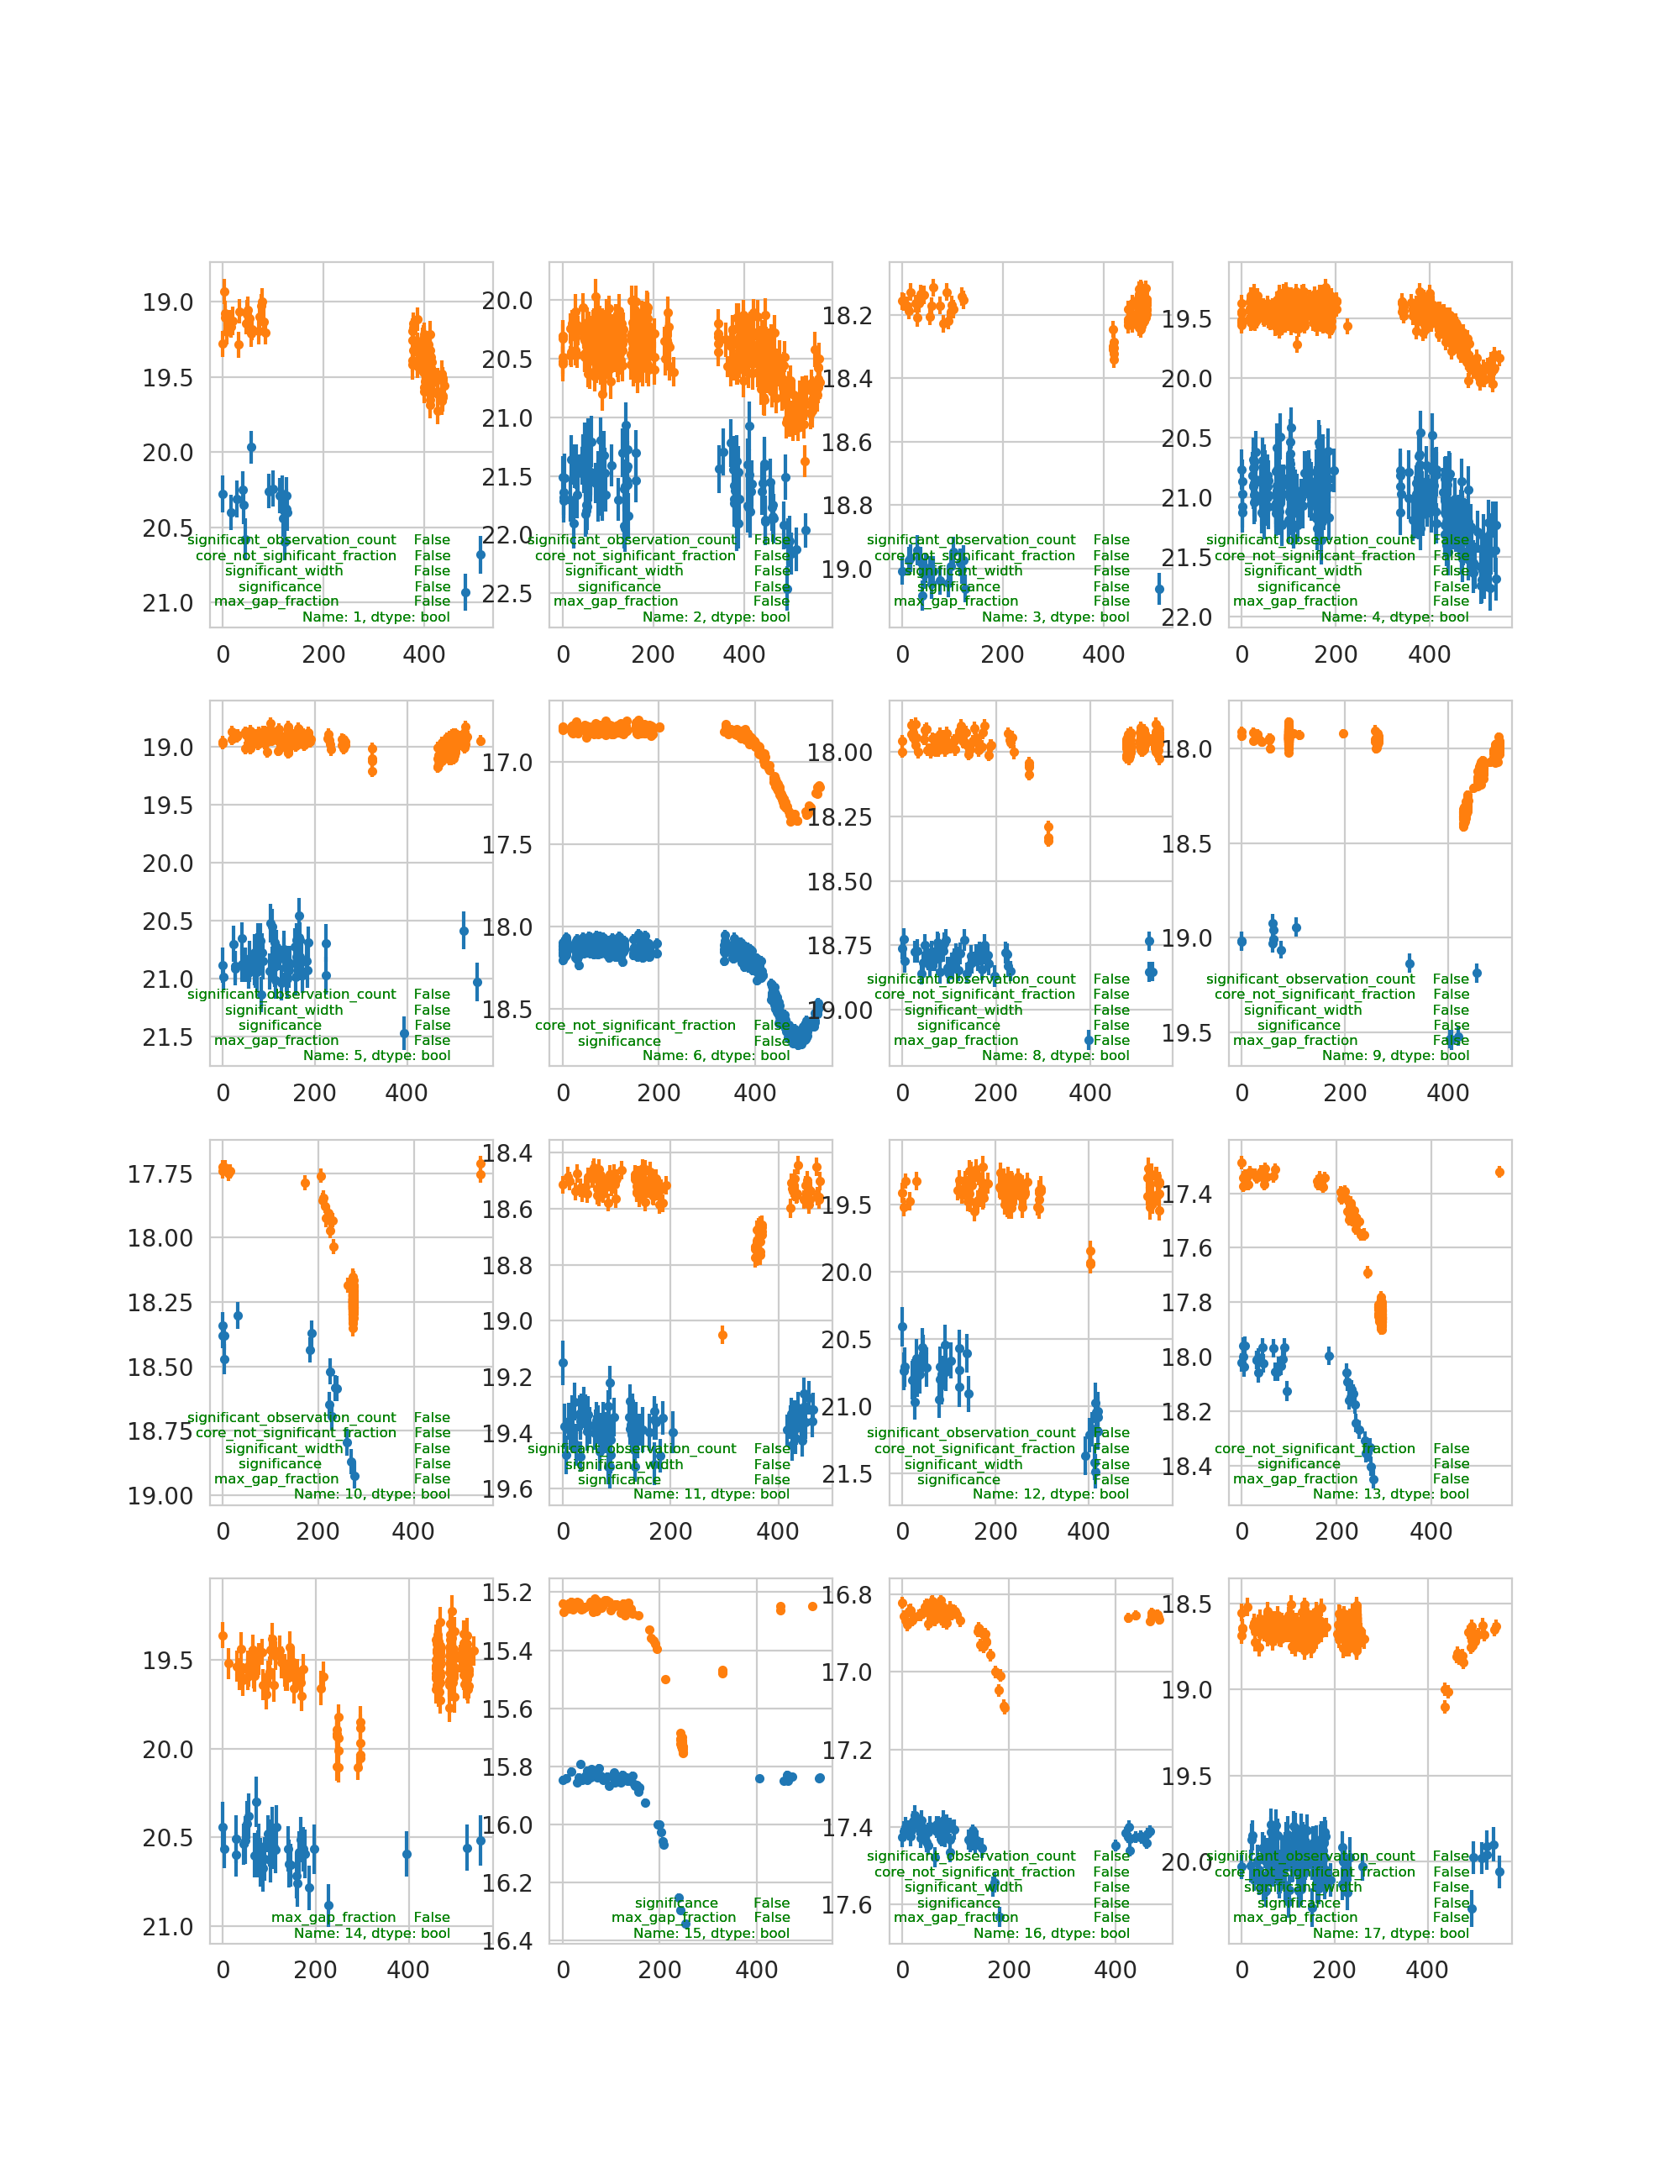

In [181]:
fig, axes = plt.subplots(4, 4, figsize=(10,13))
nsims=16
axes = np.hstack(axes)

for i in range(nsims):
    idx = nodip_idx[i]
    lc_all = lc_all_width[idx]
    rb = res_bool.loc[idx]
    #print(rb[rb == False])
    #print(rb)
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=3)
        axes[i].text(0.85, 0.01, str(rb[rb == False]),
                verticalalignment='bottom', horizontalalignment='right',
                transform=axes[i].transAxes,
                color='green', fontsize=6)
    axes[i].set_ylim(axes[i].get_ylim()[::-1])

### 1-Day Deep Dips

Look at the 1-day dips to see why there are so few of them found:

In [216]:
depth_idx = -1
width_idx = 0

res_all = res_all_sims[depth_idx][width_idx]
lc_all = lc_all_sims[depth_idx][width_idx]
res_bool = res_bool_sims[depth_idx][width_idx]
print(dip_fraction[depth_idx][width_idx])

0.0312


In [217]:
dips = res_all[res_bool.sum(axis=1) == width_idx]
nodips = res_all[~(res_bool.sum(axis=1) == width_idx)]
print("The number of simulations without detected dips: " + str(len(nodips)))
print("How many of those have a significance > 5? " + str(len(nodips[nodips["significance"] >= 5])))

sig_nodips = nodips[nodips["significance"] >= 20]
print("How  many of those have a significance > 20? " + str(len(sig_nodips)))

The number of simulations without detected dips: 9656
How many of those have a significance > 5? 863
How  many of those have a significance > 20? 133


What's the distribution of relevant dip parameters among those?

In [218]:
limits = [3, 0.2, 1, 5, 1.5, 0.1, 0.8]
limit_direction = ["gt", "lt", "gt", "gt", "lt", "lt", "lt"]

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


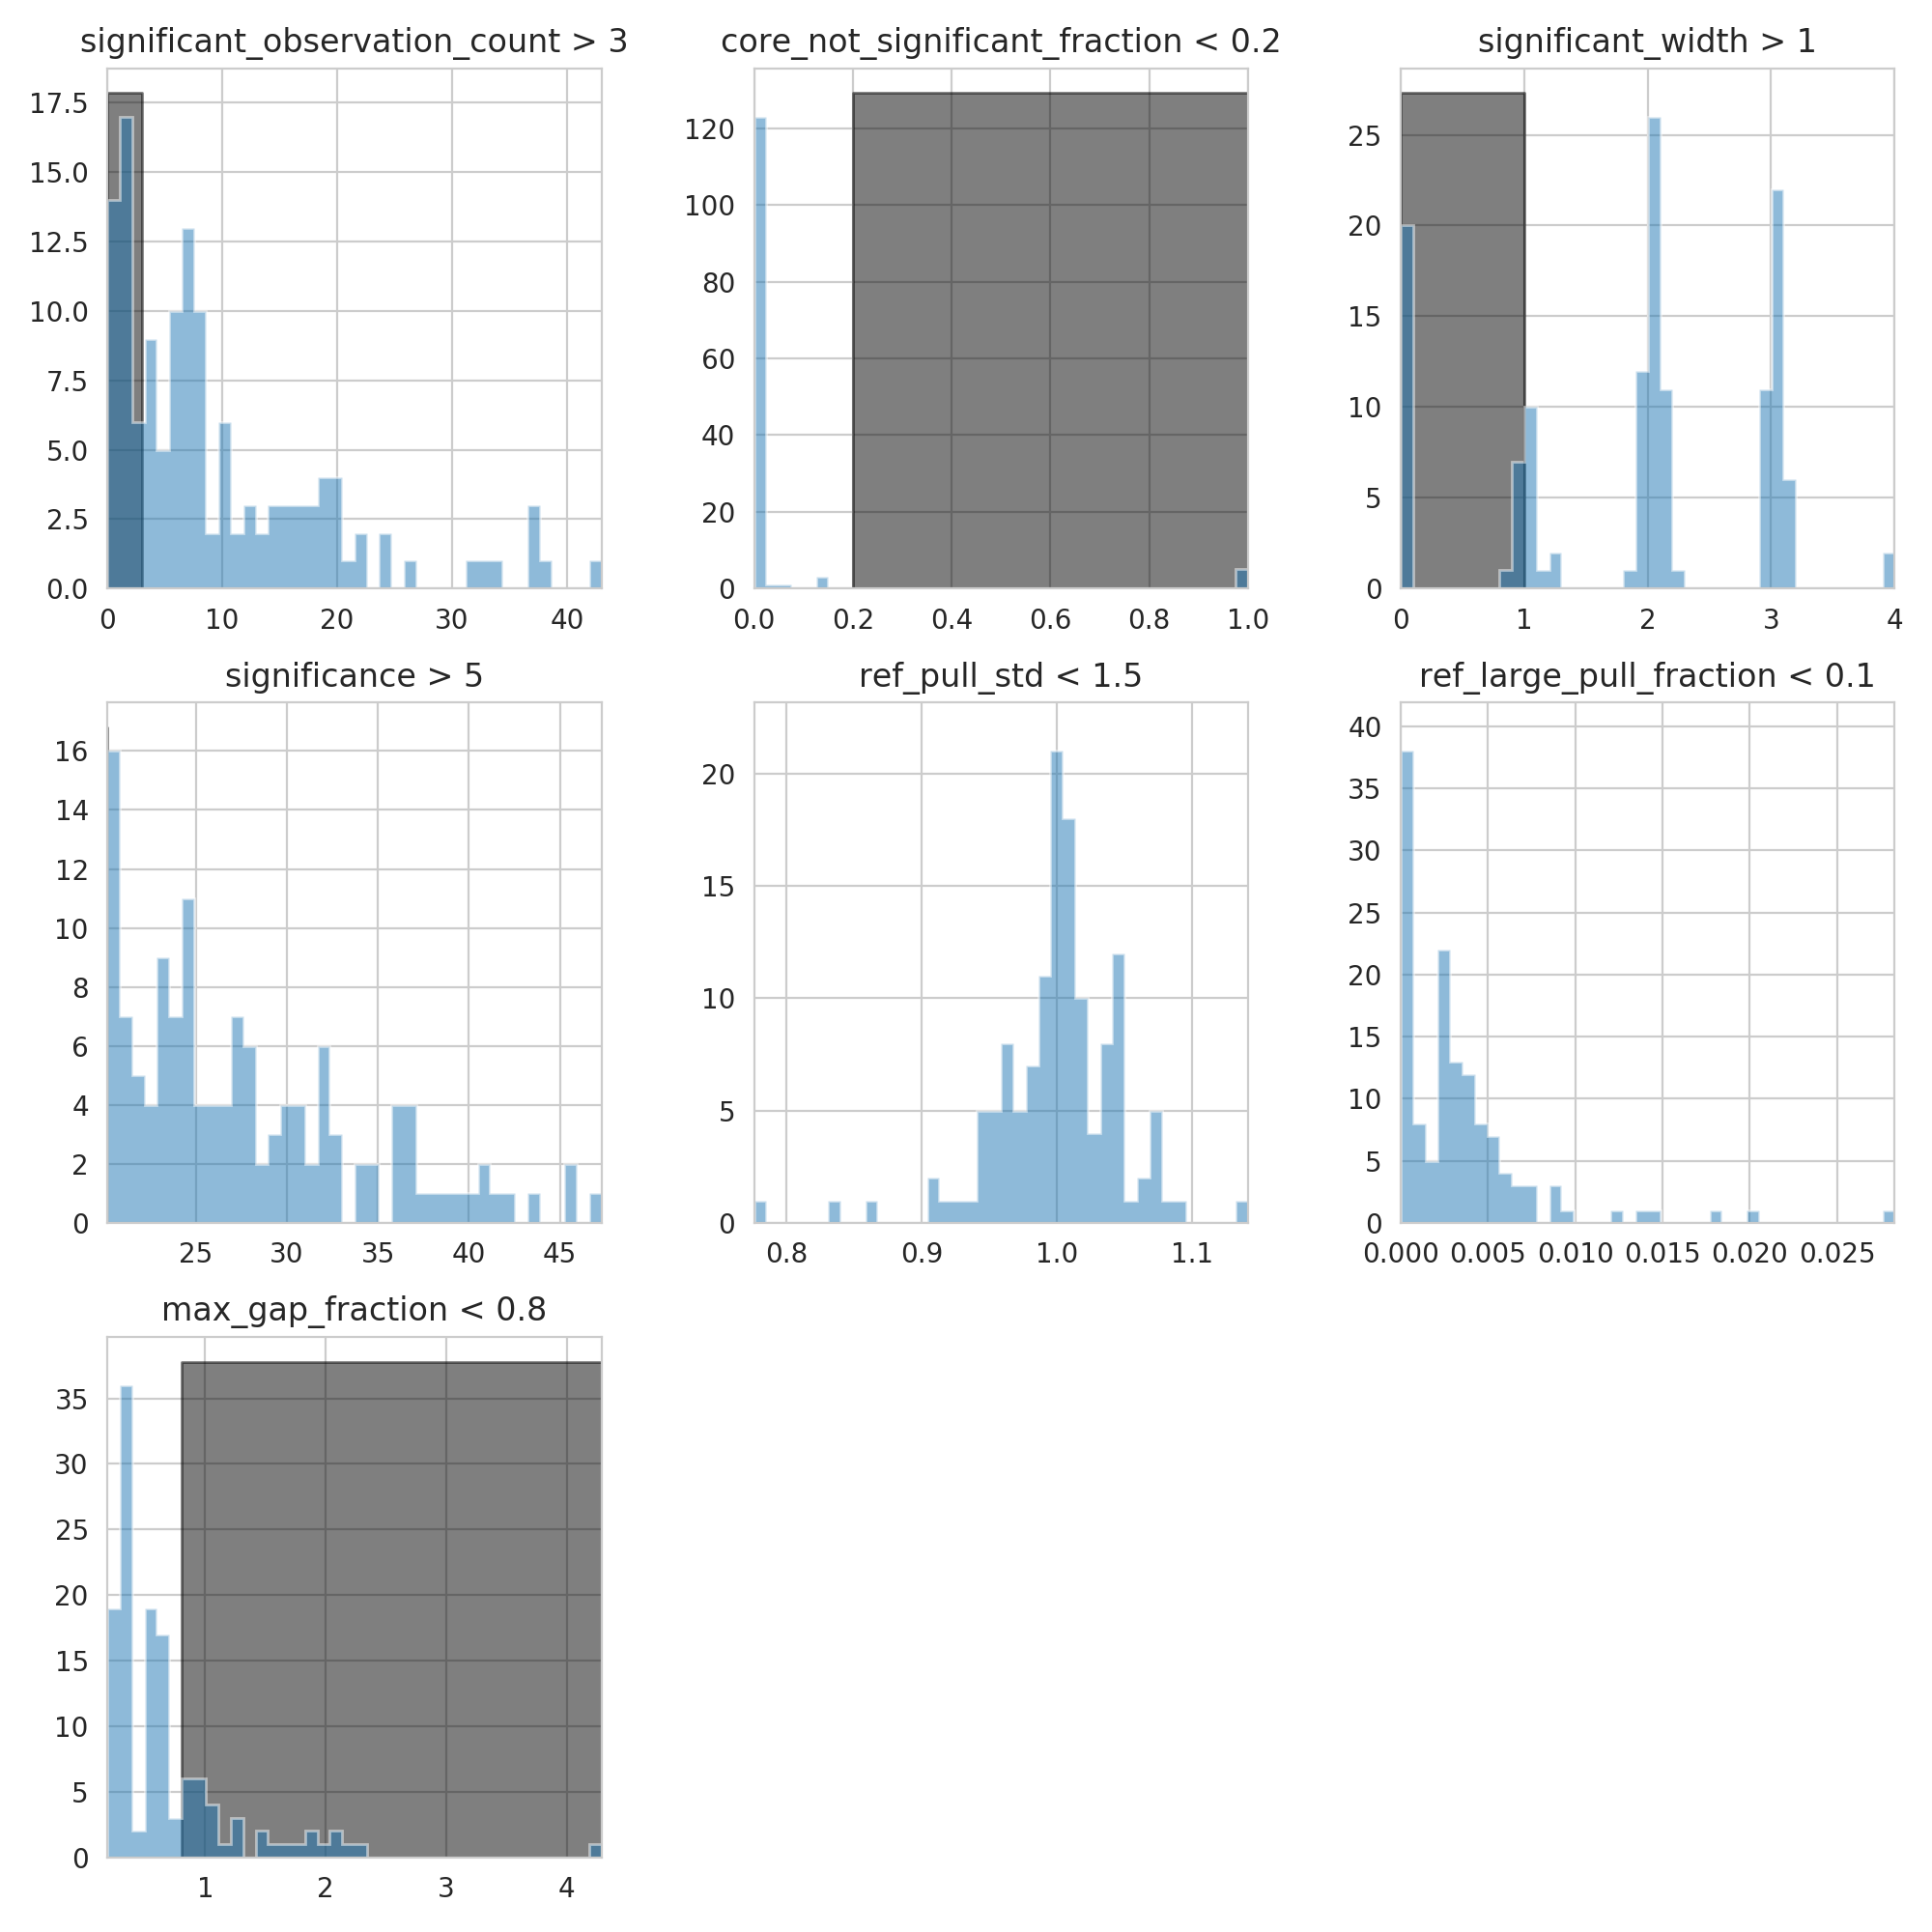

/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [219]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

axes = np.hstack(axes)

for i,c in enumerate(res_bool.columns):
    axes[i].hist(sig_nodips[c], bins=40, histtype="stepfilled", alpha=0.5)
    if limit_direction[i] == "gt":
        axes[i].fill_between([np.min(sig_nodips[c]), limits[i]], 
                             [axes[i].get_ylim()[1], axes[i].get_ylim()[1]], color="black", alpha=0.5)
        axes[i].set_title(c + " > " + str(limits[i]))
 

    else:
        axes[i].fill_between([limits[i], np.max(sig_nodips[c])], 
                             [axes[i].get_ylim()[1], axes[i].get_ylim()[1]], color="black", alpha=0.5)
        axes[i].set_title(c + " < " + str(limits[i]))


        
    axes[i].set_xlim(np.min(sig_nodips[c]), np.max(sig_nodips[c]))



axes[-2].set_visible(False)
axes[-1].set_visible(False)
plt.tight_layout()

And some examples: 

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


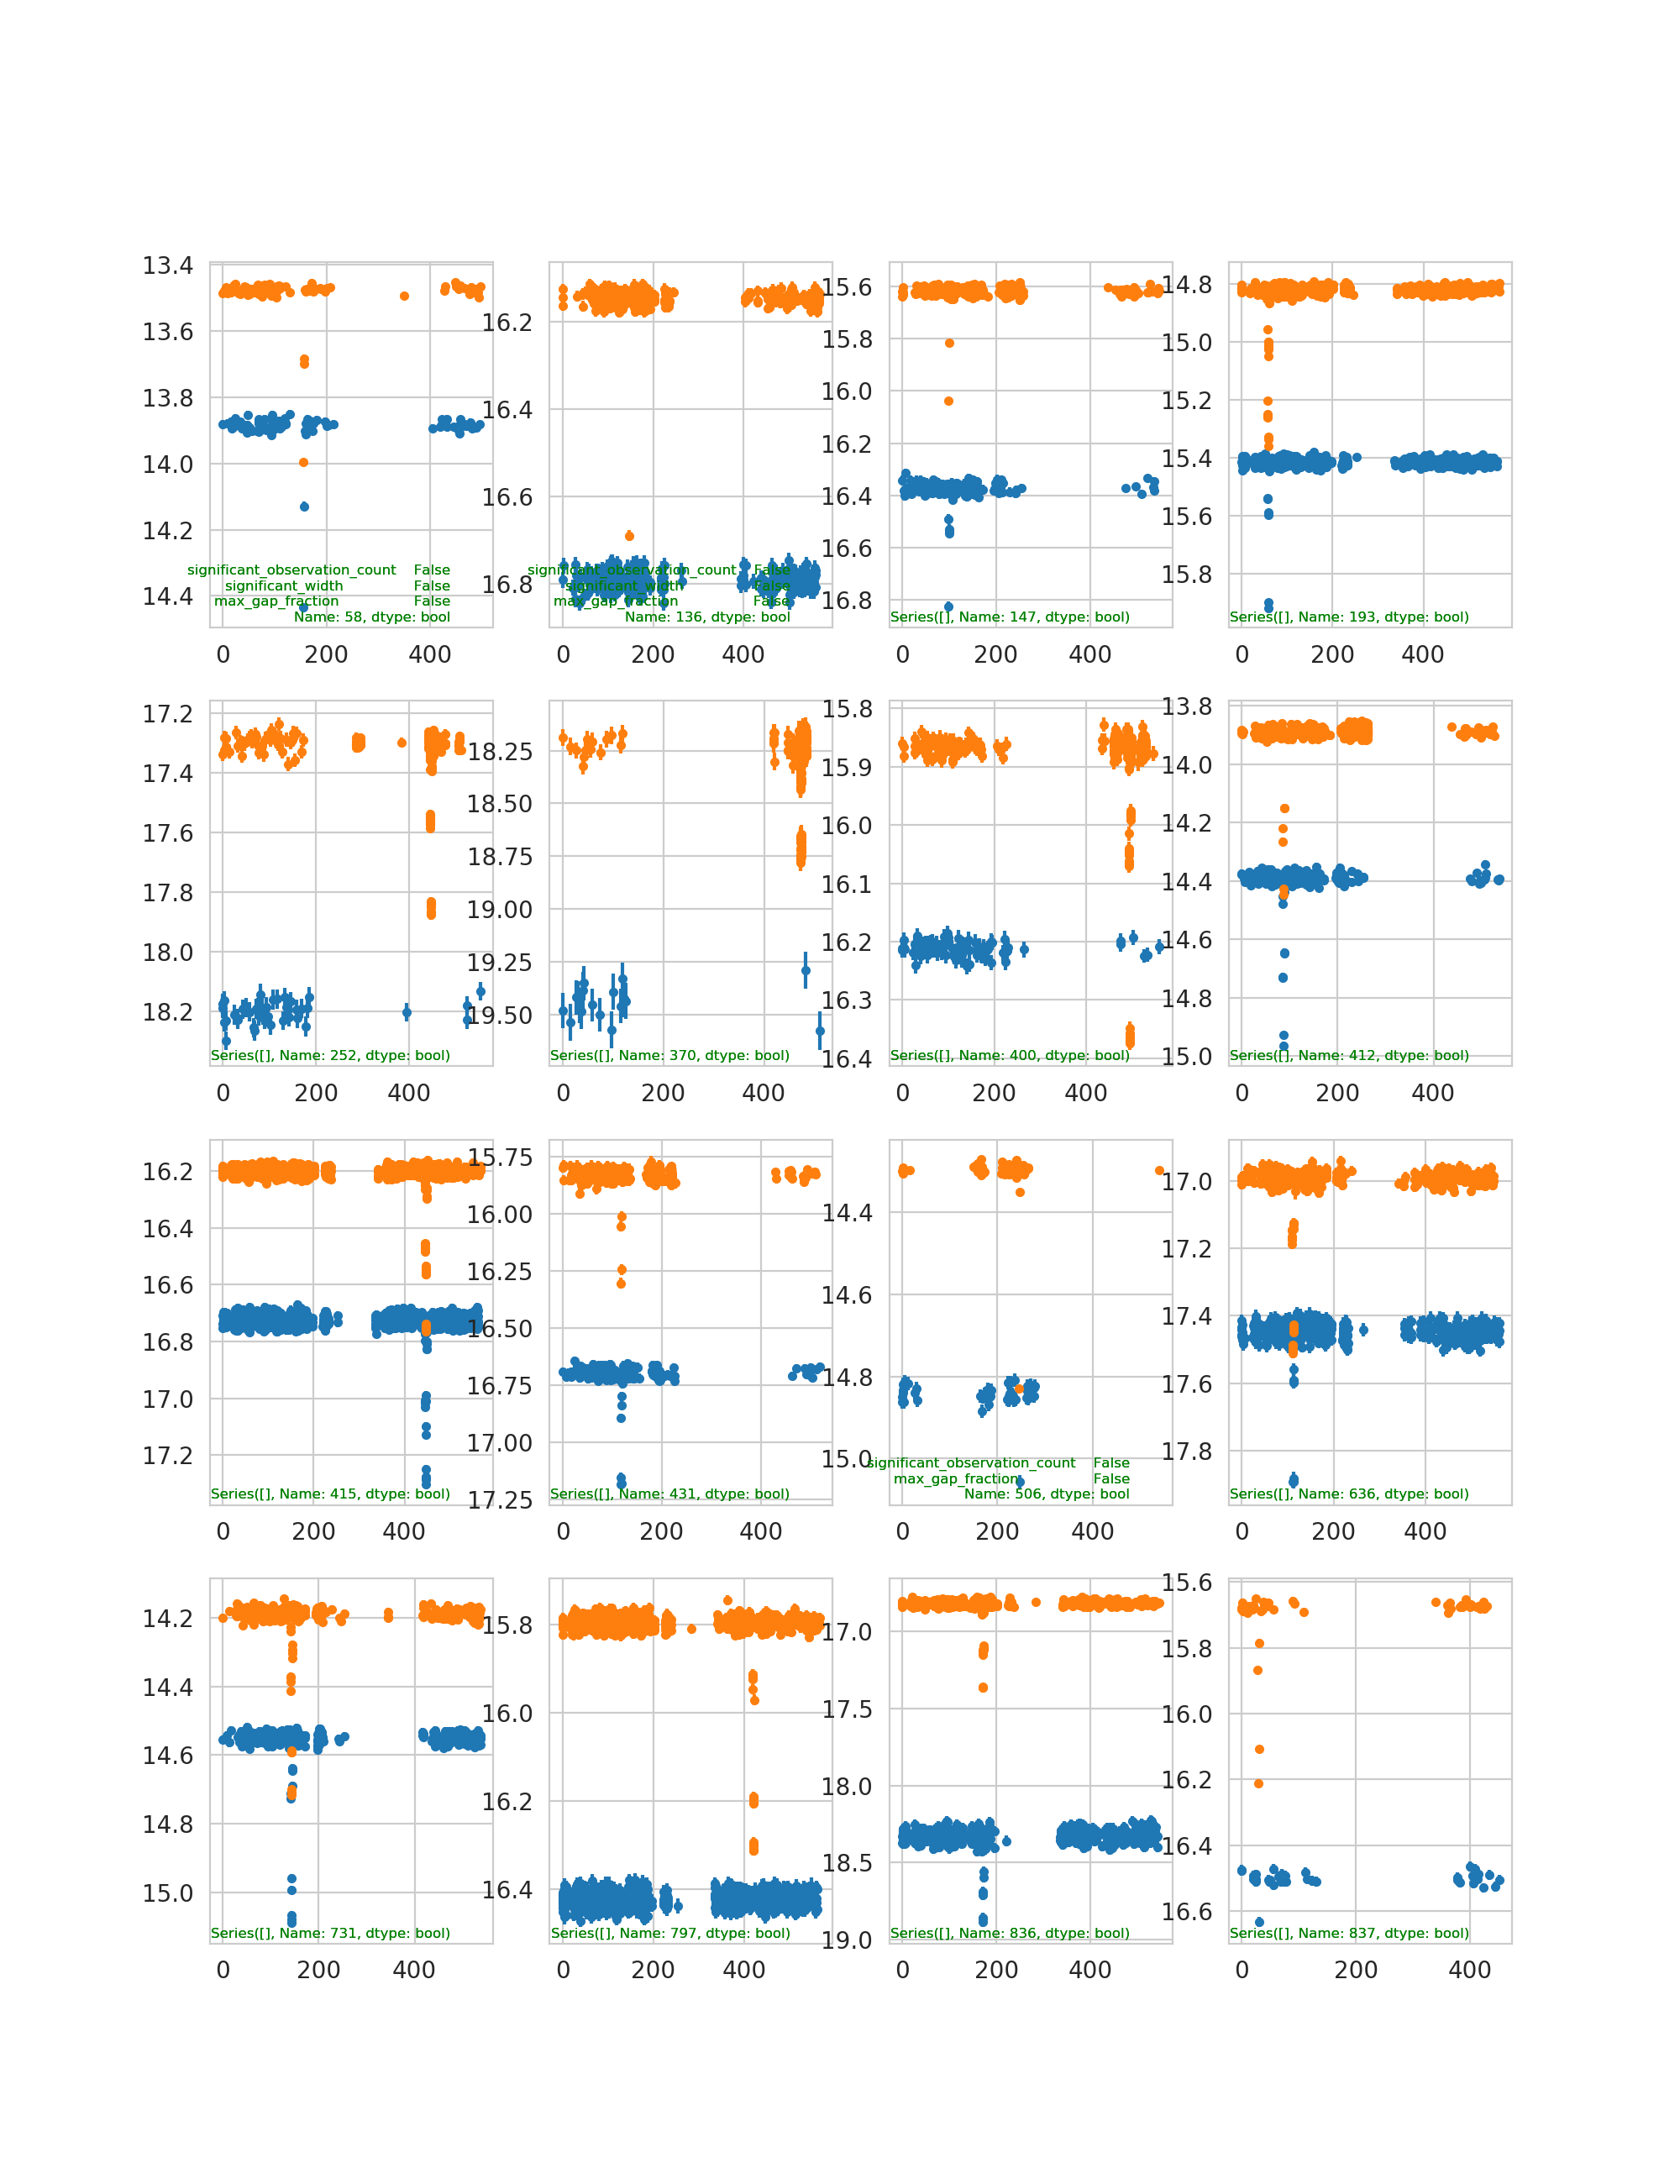

In [225]:
fig, axes = plt.subplots(4, 4, figsize=(10,13))
nsims=16
axes = np.hstack(axes)

nodip_idx = sig_nodips.index

for i in range(nsims):
    idx = nodip_idx[i]
    lc_all = lc_all_sims[depth_idx][width_idx][idx]
    rb = res_bool.loc[idx]
    #print(rb[rb == False])
    #print(rb)
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=3)
        axes[i].text(0.85, 0.01, str(rb[rb == False]),
                verticalalignment='bottom', horizontalalignment='right',
                transform=axes[i].transAxes,
                color='green', fontsize=6)
    axes[i].set_ylim(axes[i].get_ylim()[::-1])

### 50-day Dips

I also want to look at the longest dips:

In [226]:
depth_idx = -1
width_idx = -1

res_all = res_all_sims[depth_idx][width_idx]
lc_all = lc_all_sims[depth_idx][width_idx]
res_bool = res_bool_sims[depth_idx][width_idx]
print(dip_fraction[depth_idx][width_idx])

0.0312


In [227]:
dips = res_all[res_bool.sum(axis=1) == width_idx]
nodips = res_all[~(res_bool.sum(axis=1) == width_idx)]
print("The number of simulations without detected dips: " + str(len(nodips)))
print("How many of those have a significance > 5? " + str(len(nodips[nodips["significance"] >= 5])))

sig_nodips = nodips[nodips["significance"] >= 20]
print("How  many of those have a significance > 20? " + str(len(sig_nodips)))

The number of simulations without detected dips: 10000
How many of those have a significance > 5? 2937
How  many of those have a significance > 20? 717


/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


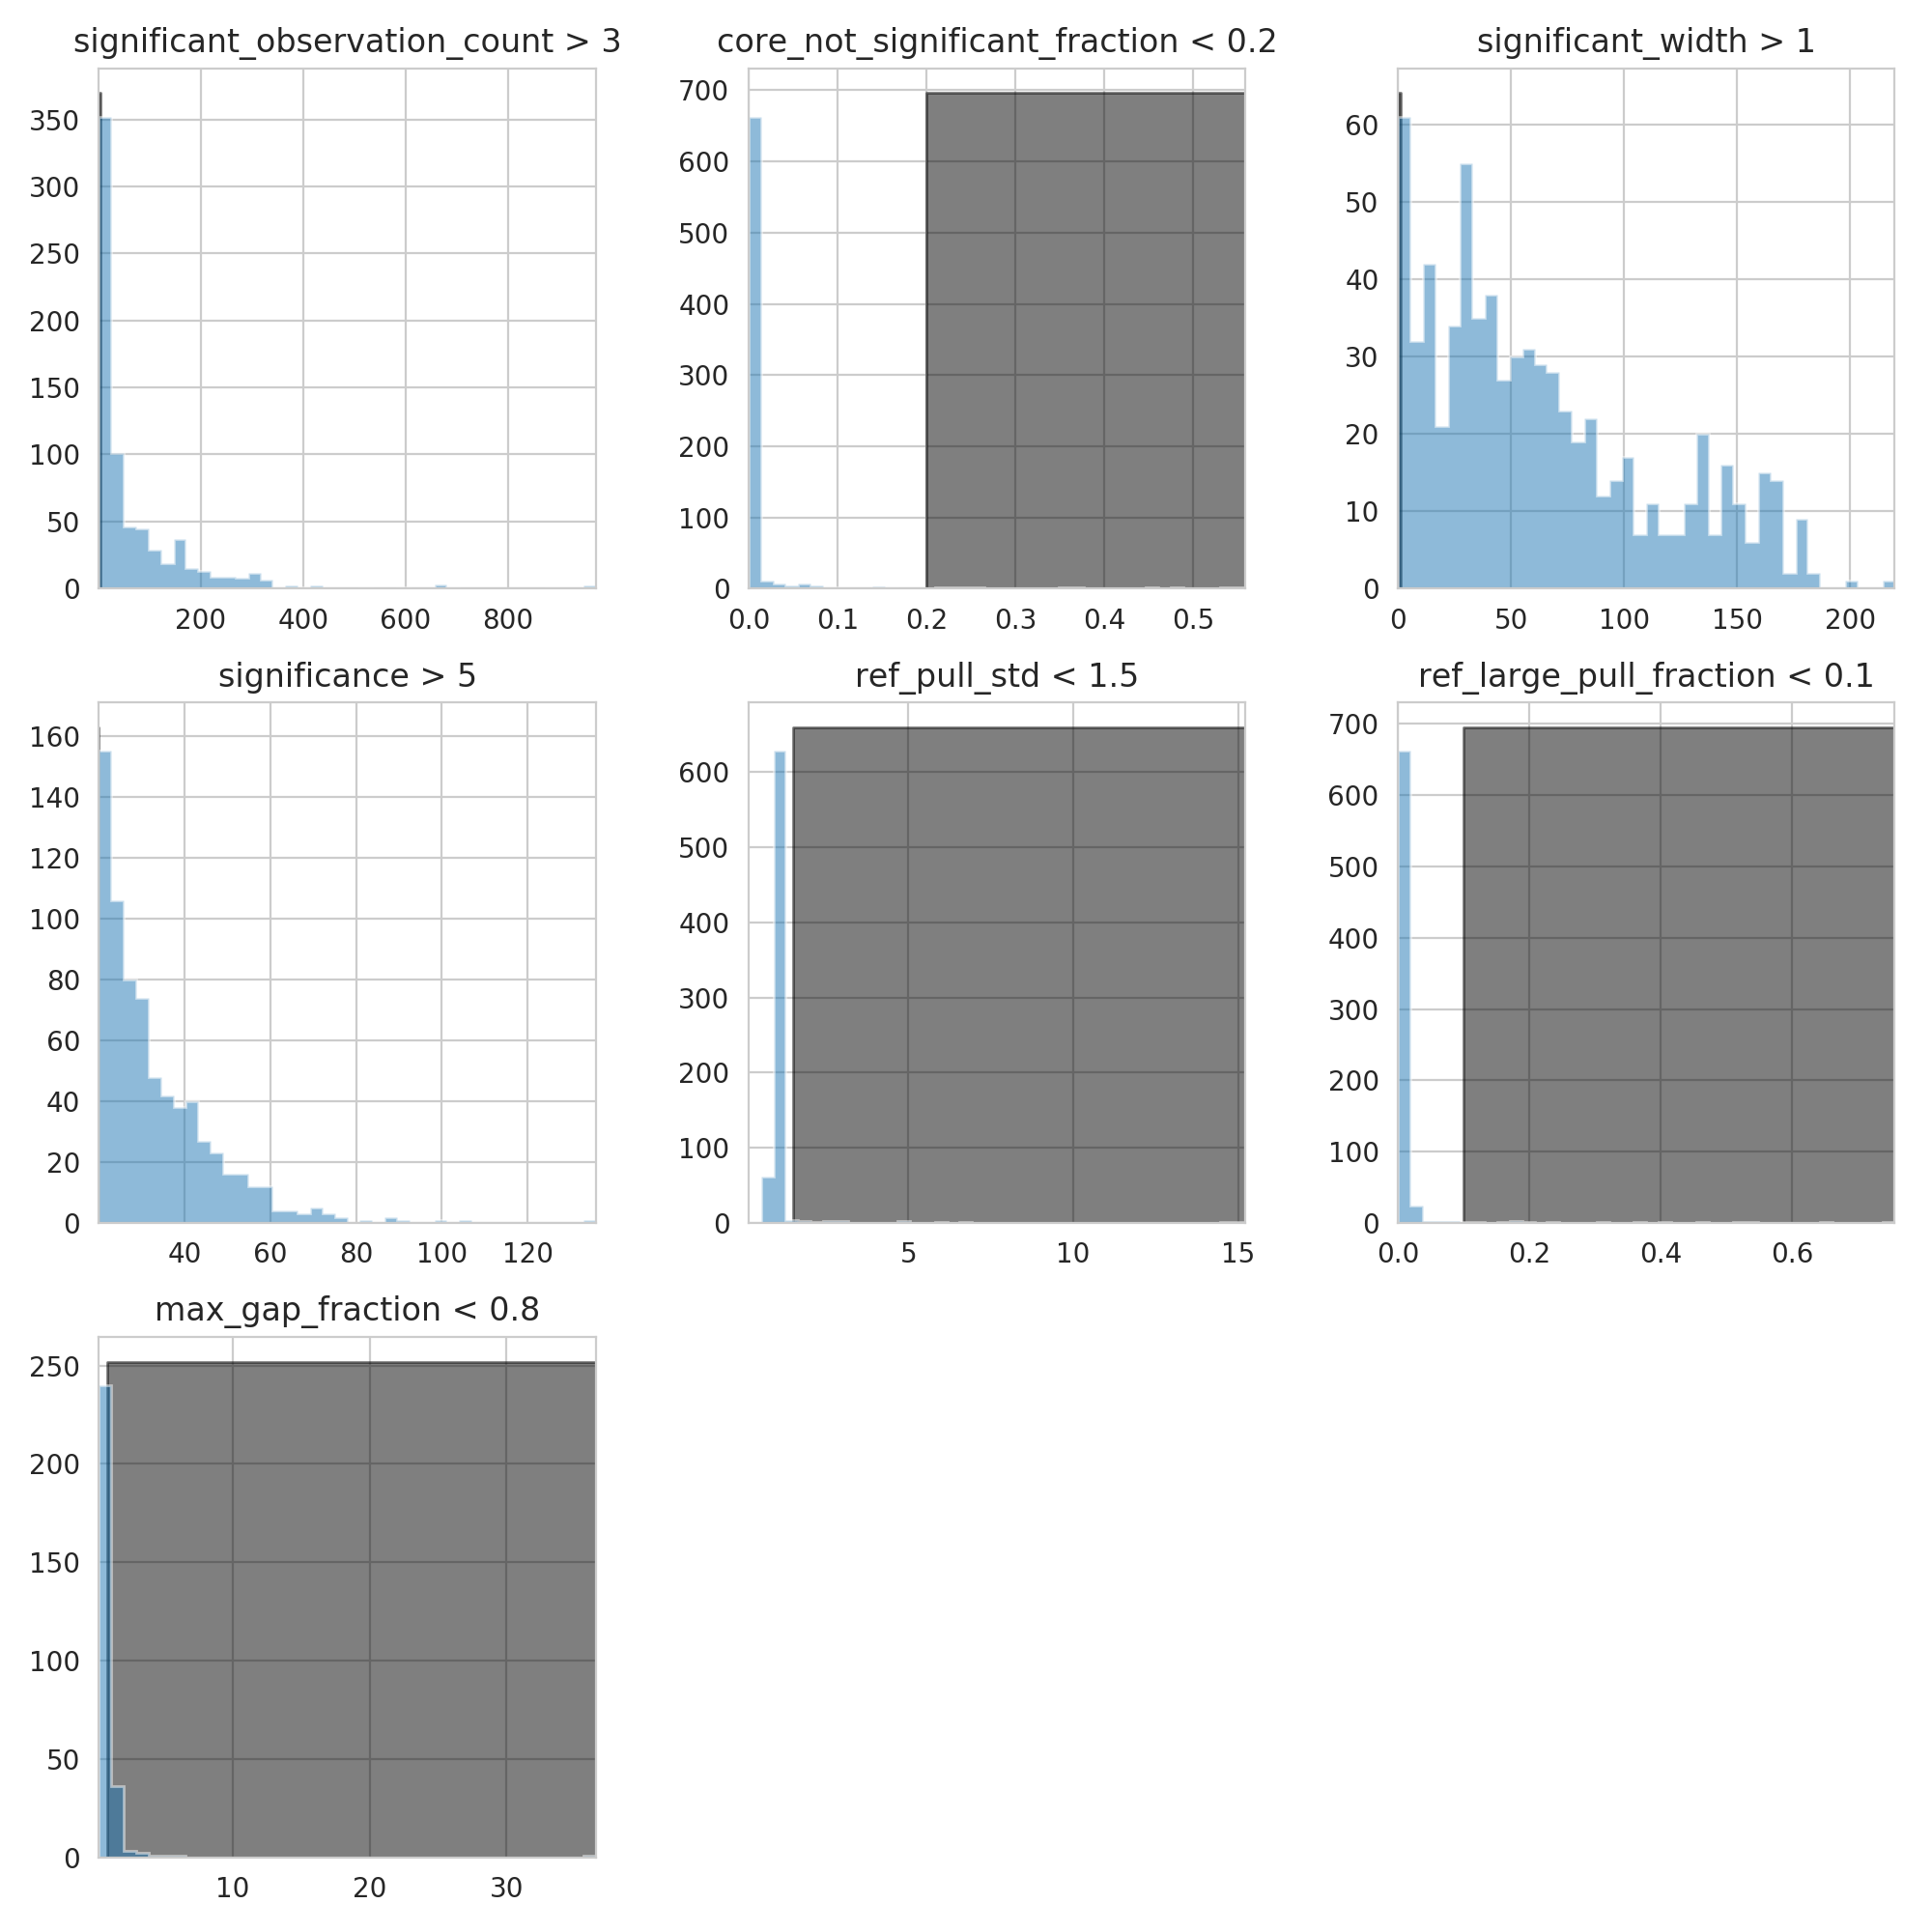

/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [228]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

axes = np.hstack(axes)

for i,c in enumerate(res_bool.columns):
    axes[i].hist(sig_nodips[c], bins=40, histtype="stepfilled", alpha=0.5)
    if limit_direction[i] == "gt":
        axes[i].fill_between([np.min(sig_nodips[c]), limits[i]], 
                             [axes[i].get_ylim()[1], axes[i].get_ylim()[1]], color="black", alpha=0.5)
        axes[i].set_title(c + " > " + str(limits[i]))
 

    else:
        axes[i].fill_between([limits[i], np.max(sig_nodips[c])], 
                             [axes[i].get_ylim()[1], axes[i].get_ylim()[1]], color="black", alpha=0.5)
        axes[i].set_title(c + " < " + str(limits[i]))


        
    axes[i].set_xlim(np.min(sig_nodips[c]), np.max(sig_nodips[c]))



axes[-2].set_visible(False)
axes[-1].set_visible(False)
plt.tight_layout()

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


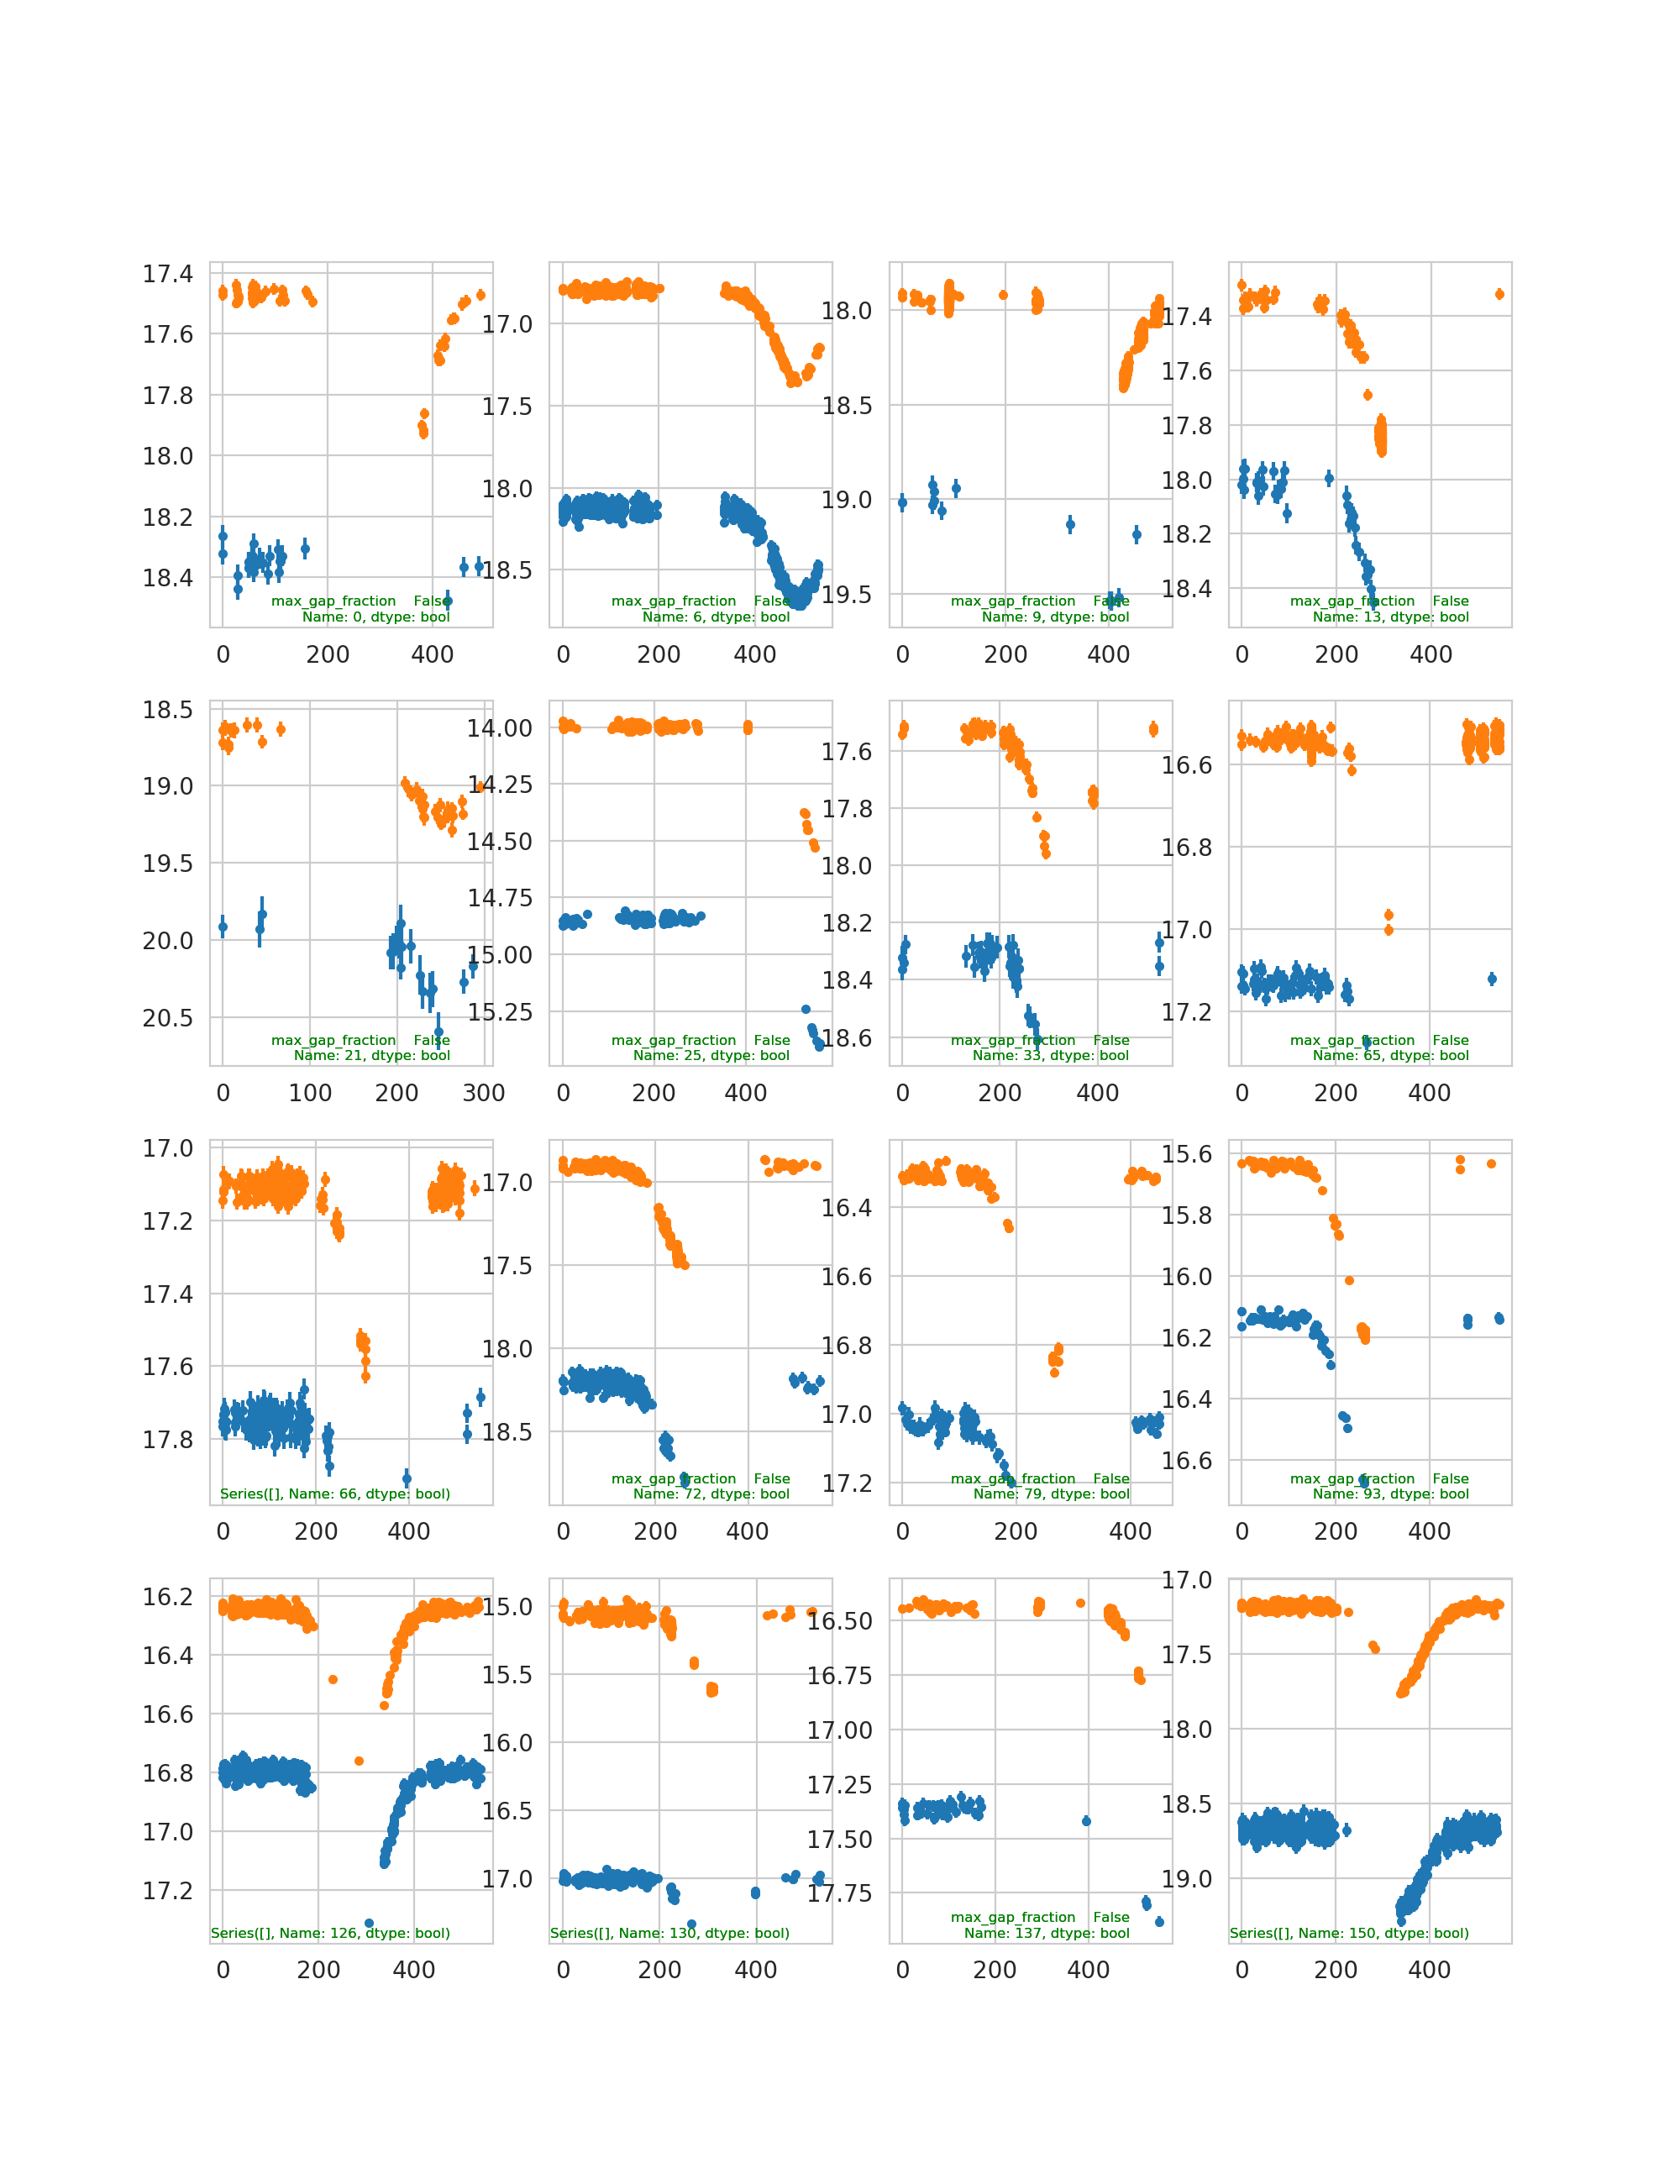

In [229]:
fig, axes = plt.subplots(4, 4, figsize=(10,13))
nsims=16
axes = np.hstack(axes)

nodip_idx = sig_nodips.index

for i in range(nsims):
    idx = nodip_idx[i]
    lc_all = lc_all_sims[depth_idx][width_idx][idx]
    rb = res_bool.loc[idx]
    #print(rb[rb == False])
    #print(rb)
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=3)
        axes[i].text(0.85, 0.01, str(rb[rb == False]),
                verticalalignment='bottom', horizontalalignment='right',
                transform=axes[i].transAxes,
                color='green', fontsize=6)
    axes[i].set_ylim(axes[i].get_ylim()[::-1])